In [1]:
## Load packages
library(readxl)
library(stringr)
library(rentrez)
library(dplyr)
library(tidyr)
library(ggplot2)
library(cowplot)
library(gggenes)
library(ggtree)
library(Biostrings)
library(msa)
library(ape)
library(pheatmap)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


ggtree v3.14.0 Learn more at https://yulab-smu.top/contribution-tree-data/

Please cite:

Guangchuang Yu, David Smith, Huachen Zhu, Yi Guan, Tommy Tsan-Yuk Lam.
ggtree: an R package for visualization and annotation of phylogenetic
trees with their covariates and other associated data. Methods in
Ecology and Evolution. 2017, 8(1):28-36. doi:10.1111/2041-210X.12628


Attaching package: ‘ggtree’


The following object is masked from ‘package:tidyr’:

    expand


Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated,

In [2]:
# Adjust PATHs

## Location in directory
wd <- getwd()
subdir <- "/bin" # should be 'scripts' if location is ./scripts/thisfile
if (endsWith(wd, subdir)) {
    wd <- str_remove(wd, subdir)
    setwd(wd)
}
cat('Directory: ', getwd())

## Conda environment
conda_env <- paste0('/home/',Sys.getenv('USER'),'/miniconda3/envs/arabinosylation-anti-crispr/bin')
PATH <- Sys.getenv('PATH')
if (!str_detect(PATH, conda_env)) {
    Sys.setenv('PATH' = paste(conda_env, PATH, sep = ':'))
}
Sys.getenv('PATH')

Directory:  /projects/health_sciences/bms/microbiology/fineranlab/arabinosylation-anti-CRISPR

[1] "/home/dieol22p/miniconda3/envs/arabinosylation-anti-crispr/bin:/opt/conda/bin:/opt/conda/condabin:/opt/conda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin"

In [3]:
# Load internal functions
source('bin/hmm_utils.R')
source('bin/utils.R')

In [4]:
# Define variables

## Input files 
in_tables <- 'docs/supplementary-tables.xlsx'
url_millard <- 'https://millardlab-inphared.s3.climb.ac.uk/1Jan2025_data.tsv.gz'
in_inphared <- 'data/inphared.tsv'

## Data storage
in_path <- "data/"
overview <- paste0(in_path, 'overview.csv')

## Output files
out_path <- 'analysis/'
out_annotation <- 'analysis/annotation/'
dir.create(out_annotation, recursive=TRUE)
out_prediction <- 'analysis/prediction/'
dir.create(out_prediction)

Warning message in dir.create(out_annotation, recursive = TRUE):
“'analysis/annotation' already exists”
Warning message in dir.create(out_prediction):
“'analysis/prediction' already exists”


In [5]:
# Define colors
cols <- list()

cols$modification <- c(
    'None' = 'grey80',
    #'Unknown' = 'grey30',
    'glucose' = 'seagreen',
    #'arabinose' = 'yellow',
    '5ara-hdC' = 'darkorange',
    '5ara-ara-hdC' = 'indianred',
    '5ara-ara-ara-hdC' = 'purple',
    '>2 Aat genes' = 'pink'
)

cols$group <- c(
    'None'='grey80','Generic'='grey30','Glucosylation'='seagreen','Arabinosylation'='orange'
)

cols$annotation <- c(
    'DNA pol' = 'grey60',
    'DNA clamp' = 'black',
    'dCTPase' = 'purple',
    'HMase' = 'cyan3',
    'dNMP kinase' = 'dodgerblue',
    'Thy syn' = 'navy', # aquamarine
    'Glu transfer' = 'seagreen',
    'Ara iso' = 'darkorange',
    'NTP transfer' = 'yellow',
    'Thy kin' = 'hotpink',
    'Aat' = 'indianred',
    'Other' = 'grey90'
)

In [6]:
# Download data
download.file(url_millard, in_inphared)

In [7]:
# Read data

## Supplementary tables
tables <- list()
for (i in excel_sheets(in_tables)) {
    print(paste('Reading table', i))
    tables[[i]] <- read_excel(in_tables, sheet = i)
    }

## Millard lab INPARED database overview
inphared <- readr::read_tsv(in_inphared)

[1] "Reading table phages"
[1] "Reading table annotation"
[1] "Reading table predicted_arabinosylating_phage"
[1] "Reading table S7_phage-genomes"
[1] "Reading table proteins"
[1] "Reading table S4_phages"
[1] "Reading table S1_bacteria"
[1] "Reading table S6_ara-hC-transferases"
[1] "Reading table S8_glucosylation-enzymes"
[1] "Reading table S9_DNA-modification-enzymes"


Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Rows: 32043 Columns: 27
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (18): Accession, Description, Classification, Molecule, Modification Dat...
dbl  (7): Genome Length (bp), molGC (%), Number CDS, Positive Strand (%), Ne...
lgl  (2): Jumbophage, Low Coding Capacity Warning

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [8]:
# Read file structure
collections <- c('training','validation','test','test2')
fs <- list()
for (i in collections) {
    fs[[i]]$path <- paste0(in_path, i, '/')
    fs[[i]]$accession <- paste0(in_path, i, '/accession.txt')
    fs[[i]]$archive <- paste0(fs[[i]]$path, 'ncbi_dataset/', 'data/')
    for (ii in list.files(fs[[i]]$archive)) {
        key <- str_split(ii, '\\.')[[1]][[1]]
        fs[[i]][[key]] <- paste0(fs[[i]]$archive, ii)
    }
}
fs
all(file.exists(unlist(fs)))
which(!file.exists(unlist(fs)))

$training
$training$path
[1] "data/training/"

$training$accession
[1] "data/training/accession.txt"

$training$archive
[1] "data/training/ncbi_dataset/data/"

$training$annotation_report
[1] "data/training/ncbi_dataset/data/annotation_report.jsonl"

$training$biosample_report
[1] "data/training/ncbi_dataset/data/biosample_report.jsonl"

$training$cds
[1] "data/training/ncbi_dataset/data/cds.fna"

$training$data_report
[1] "data/training/ncbi_dataset/data/data_report.jsonl"

$training$dataset_catalog
[1] "data/training/ncbi_dataset/data/dataset_catalog.json"

$training$features
[1] "data/training/ncbi_dataset/data/features.gtf"

$training$genomic
[1] "data/training/ncbi_dataset/data/genomic.fna"

$training$metadata
[1] "data/training/ncbi_dataset/data/metadata.tsv"

$training$protein
[1] "data/training/ncbi_dataset/data/protein.faa"

$training$virus_dataset
[1] "data/training/ncbi_dataset/data/virus_dataset.md"


$validation
$validation$path
[1] "data/validation/"

$validation$accession
[1] "data/validation/accession.txt"

$validation$archive
[1] "data/validation/ncbi_dataset/data/"

$validation$annotation_report
[1] "data/validation/ncbi_dataset/data/annotation_report.jsonl"

$validation$biosample_report
[1] "data/validation/ncbi_dataset/data/biosample_report.jsonl"

$validation$cds
[1] "data/validation/ncbi_dataset/data/cds.fna"

$validation$data_report
[1] "data/validation/ncbi_dataset/data/data_report.jsonl"

$validation$dataset_catalog
[1] "data/validation/ncbi_dataset/data/dataset_catalog.json"

$validation$features
[1] "data/validation/ncbi_dataset/data/features.gtf"

$validation$genomic
[1] "data/validation/ncbi_dataset/data/genomic.fna"

$validation$metadata
[1] "data/validation/ncbi_dataset/data/metadata.tsv"

$validation$protein
[1] "data/validation/ncbi_dataset/data/protein.faa"

$validation$virus_dataset
[1] "data/validation/ncbi_dataset/data/virus_dataset.md"


$test
$test$path
[1] "data/test/"

$test$accession
[1] "data/test/accession.txt"

$test$archive
[1] "data/test/ncbi_dataset/data/"

$test$annotation_report
[1] "data/test/ncbi_dataset/data/annotation_report.jsonl"

$test$biosample_report
[1] "data/test/ncbi_dataset/data/biosample_report.jsonl"

$test$cds
[1] "data/test/ncbi_dataset/data/cds.fna"

$test$data_report
[1] "data/test/ncbi_dataset/data/data_report.jsonl"

$test$dataset_catalog
[1] "data/test/ncbi_dataset/data/dataset_catalog.json"

$test$features
[1] "data/test/ncbi_dataset/data/features.gtf"

$test$genomic
[1] "data/test/ncbi_dataset/data/genomic.fna"

$test$metadata
[1] "data/test/ncbi_dataset/data/metadata.tsv"

$test$protein
[1] "data/test/ncbi_dataset/data/protein.faa"

$test$virus_dataset
[1] "data/test/ncbi_dataset/data/virus_dataset.md"


$test2
$test2$path
[1] "data/test2/"

$test2$accession
[1] "data/test2/accession.txt"

$test2$archive
[1] "data/test2/ncbi_dataset/data/"

$test2$annotation_report
[1] "data/test2/ncbi_dataset/data/annotation_report.jsonl"

$test2$biosample_report
[1] "data/test2/ncbi_dataset/data/biosample_report.jsonl"

$test2$cds
[1] "data/test2/ncbi_dataset/data/cds.fna"

$test2$data_report
[1] "data/test2/ncbi_dataset/data/data_report.jsonl"

$test2$dataset_catalog
[1] "data/test2/ncbi_dataset/data/dataset_catalog.json"

$test2$features
[1] "data/test2/ncbi_dataset/data/features.gtf"

$test2$genomic
[1] "data/test2/ncbi_dataset/data/genomic.fna"

$test2$metadata
[1] "data/test2/ncbi_dataset/data/metadata.tsv"

$test2$protein
[1] "data/test2/ncbi_dataset/data/protein.faa"

$test2$virus_dataset
[1] "data/test2/ncbi_dataset/data/virus_dataset.md"

[1] TRUE

integer(0)

In [9]:
# Read data

## Training data
training <- list(
    'metadata' = read.delim(fs$training$metadata),
    'features' = read.delim(fs$training$features),
    'protein' = readAAStringSet(fs$training$protein)
)
str(training, max.level = 1)

## Validation data
validation <- list(
    'metadata' = read.delim(fs$validation$metadata),
    'features' = read.delim(fs$validation$features),
    'protein' = readAAStringSet(fs$validation$protein)
)
str(validation, max.level = 1)

## Test data
test <- list(
    'metadata' = read.delim(fs$test$metadata),
    'features' = read.delim(fs$test$features),
    'protein' = readAAStringSet(fs$test$protein)
)
str(test, max.level = 1)

## Test2 data
test2 <- list(
    'metadata' = read.delim(fs$test2$metadata),
    'features' = read.delim(fs$test2$features),
    'protein' = readAAStringSet(fs$test2$protein)
)
str(test2, max.level = 1)

List of 3
 $ metadata:'data.frame':	35 obs. of  49 variables:
 $ features:'data.frame':	9641 obs. of  70 variables:
 $ protein :Formal class 'AAStringSet' [package "Biostrings"] with 5 slots
List of 3
 $ metadata:'data.frame':	93 obs. of  49 variables:
 $ features:'data.frame':	22533 obs. of  70 variables:
 $ protein :Formal class 'AAStringSet' [package "Biostrings"] with 5 slots


Warning message in scan(file = file, what = what, sep = sep, quote = quote, dec = dec, :
“EOF within quoted string”


List of 3
 $ metadata:'data.frame':	22467 obs. of  49 variables:
 $ features:'data.frame':	3376199 obs. of  70 variables:
 $ protein :Formal class 'AAStringSet' [package "Biostrings"] with 5 slots
List of 3
 $ metadata:'data.frame':	44226 obs. of  49 variables:
 $ features:'data.frame':	2515207 obs. of  70 variables:
 $ protein :Formal class 'AAStringSet' [package "Biostrings"] with 5 slots


In [10]:
# Create summary report

## Add dataset info
training$metadata$set <- 'training'
validation$metadata$set <- 'validation'
test$metadata$set <- 'test'
test2$metadata$set <- 'test2'

## Combine
report <- rbind(
    training$metadata,
    validation$metadata,
    test$metadata,
    test2$metadata
)
any(duplicated(report$Accession))

## View
rbind(head(report,3),tail(report,3))
str(report, max.level = 0)

[1] FALSE

Accession  BioProjects            BioSample.accession Completeness
1     AF158101.6                                            COMPLETE    
2     MK639187.1                                            COMPLETE    
3     MK962754.1                                            COMPLETE    
66819 BK056824.1 PRJEB6997,PRJNA573942  SAMEA2737722        PARTIAL     
66820 BK056880.1 PRJNA48479,PRJNA573942 SAMN00038409        PARTIAL     
66821 BK056923.1 PRJEB6997,PRJNA573942  SAMEA2737799        PARTIAL     
      Gene.count Geographic.Location Geographic.Region Geographic.State
1     278                                                              
2     266        China               Asia                              
3     280        Ireland             Europe                            
66819  22        USA                 North America                     
66820  26        USA                 North America                     
66821 103        USA                 North America                     
      Host.Common.Name Host.Infraspecific.Names.Breed ⋯
1     NA               NA                             ⋯
2     NA               NA                             ⋯
3     NA               NA                             ⋯
66819 NA               NA                             ⋯
66820 NA               NA                             ⋯
66821 NA               NA                             ⋯
      Virus.Infraspecific.Names.Breed Virus.Infraspecific.Names.Cultivar
1     NA                              NA                                
2     NA                              NA                                
3     NA                              NA                                
66819 NA                              NA                                
66820 NA                              NA                                
66821 NA                              NA                                
      Virus.Infraspecific.Names.Ecotype Virus.Infraspecific.Names.Isolate
1     NA                                NA                               
2     NA                                NA                               
3     NA                                NA                               
66819 NA                                NA                               
66820 NA                                NA                               
66821 NA                                NA                               
      Virus.Infraspecific.Names.Sex Virus.Infraspecific.Names.Strain
1     NA                            NA                              
2     NA                            NA                              
3     NA                            NA                              
66819 NA                            NA                              
66820 NA                            NA                              
66821 NA                            NA                              
      Virus.Name           Virus.Pangolin.Classification Virus.Taxonomic.ID
1     Escherichia phage T4 NA                            2681598           
2     Shigella phage SSE1  NA                            2562131           
3     Shigella phage JK36  NA                            2591060           
66819 Bacteriophage sp.    NA                              38018           
66820 Bacteriophage sp.    NA                              38018           
66821 Bacteriophage sp.    NA                              38018           
      set     
1     training
2     training
3     training
66819 test2   
66820 test2   
66821 test2

'data.frame':	66821 obs. of  50 variables:


In [11]:
# Intersect with Millard list
table(report$Completeness)
millard_acc <- inphared$Accession
report$millard <- str_split(report$Accession,'\\.',simplify=TRUE)[,1] %in% millard_acc
table(millard_acc %in% str_split(report$Accession,'\\.',simplify=TRUE)[,1])
table(report$millard)


COMPLETE  PARTIAL 
   32697    34124 


FALSE  TRUE 
  133 31910 


FALSE  TRUE 
34911 31910 

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


[1] 26501

Warning message:
“Removed 18000 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 18000 rows containing non-finite outside the scale range
(`stat_bin()`).”


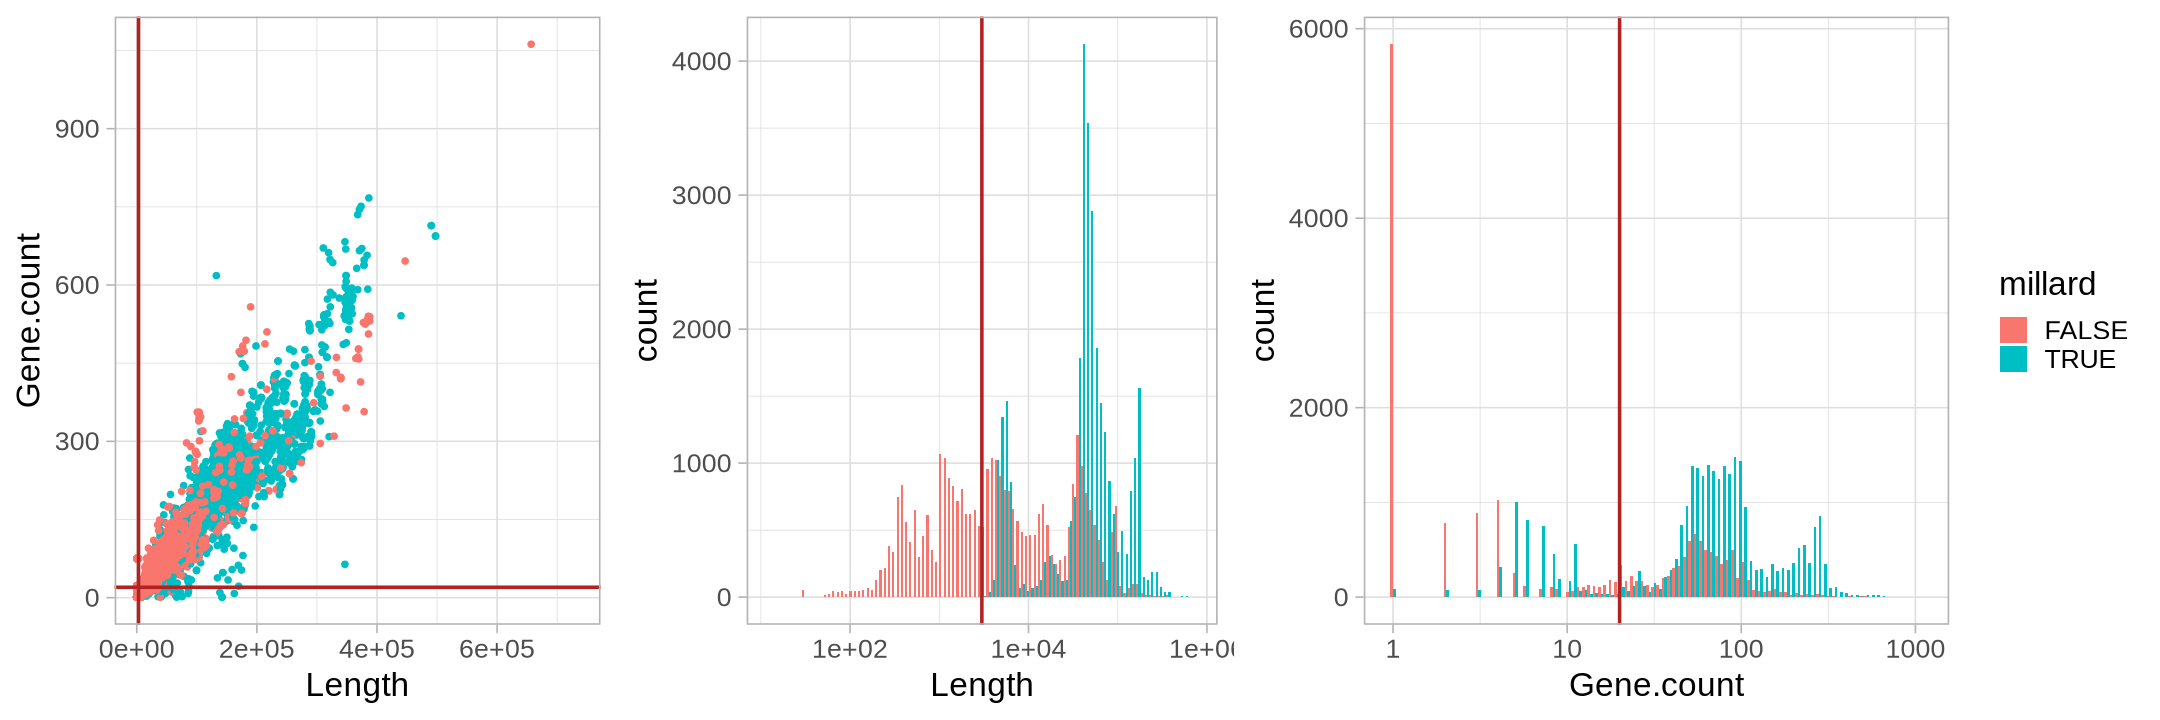

In [12]:
# Genome QC
options(repr.plot.width=18, repr.plot.height=6)

## Thresholds
min_genes <- 20
min_length <- 3000

## Plot
p1 <- ggplot(report, aes(Length, Gene.count, col=millard)) +
  geom_point() +
  geom_hline(yintercept = min_genes, size=1, col='firebrick') +
  geom_vline(xintercept = min_length, size=1, col='firebrick') +
  theme_light(20) +
  guides(col = guide_none())

## Plot
p2 <- ggplot(report, aes(Length, fill=millard)) +
  geom_histogram(bins = 100, position = 'dodge') +
  scale_x_continuous(trans='log10') +
  geom_vline(xintercept = min_length, size=1, col='firebrick') +
  theme_light(20) +
  guides(fill = guide_none())

## Plot
p3 <- ggplot(report, aes(Gene.count, fill=millard)) +
  geom_histogram(bins = 100, position = 'dodge') +
  scale_x_continuous(trans='log10') +
  geom_vline(xintercept = min_genes, size=1, col='firebrick') +
  theme_light(20)

## Quantify
length(unique(report$Virus.Name))

## Arrange
plot_grid(p1, p2, p3, nrow = 1, rel_widths = c(1,1,1.5))

In [13]:
# Filter

## Report
report <- report[which(report$millard), ]
report <- report[which(report$Length > min_length), ]
report <- report[which(report$Gene.count > min_genes), ]
#report <- report[!is.na(report$Accession),]
report <- report[which(!duplicated(report$Virus.Name)), ]

## Check for introduced NAs
any(is.na(report$Accession))

## View
str(report, max.level = 0)

[1] FALSE

'data.frame':	18891 obs. of  51 variables:


[1] 18891

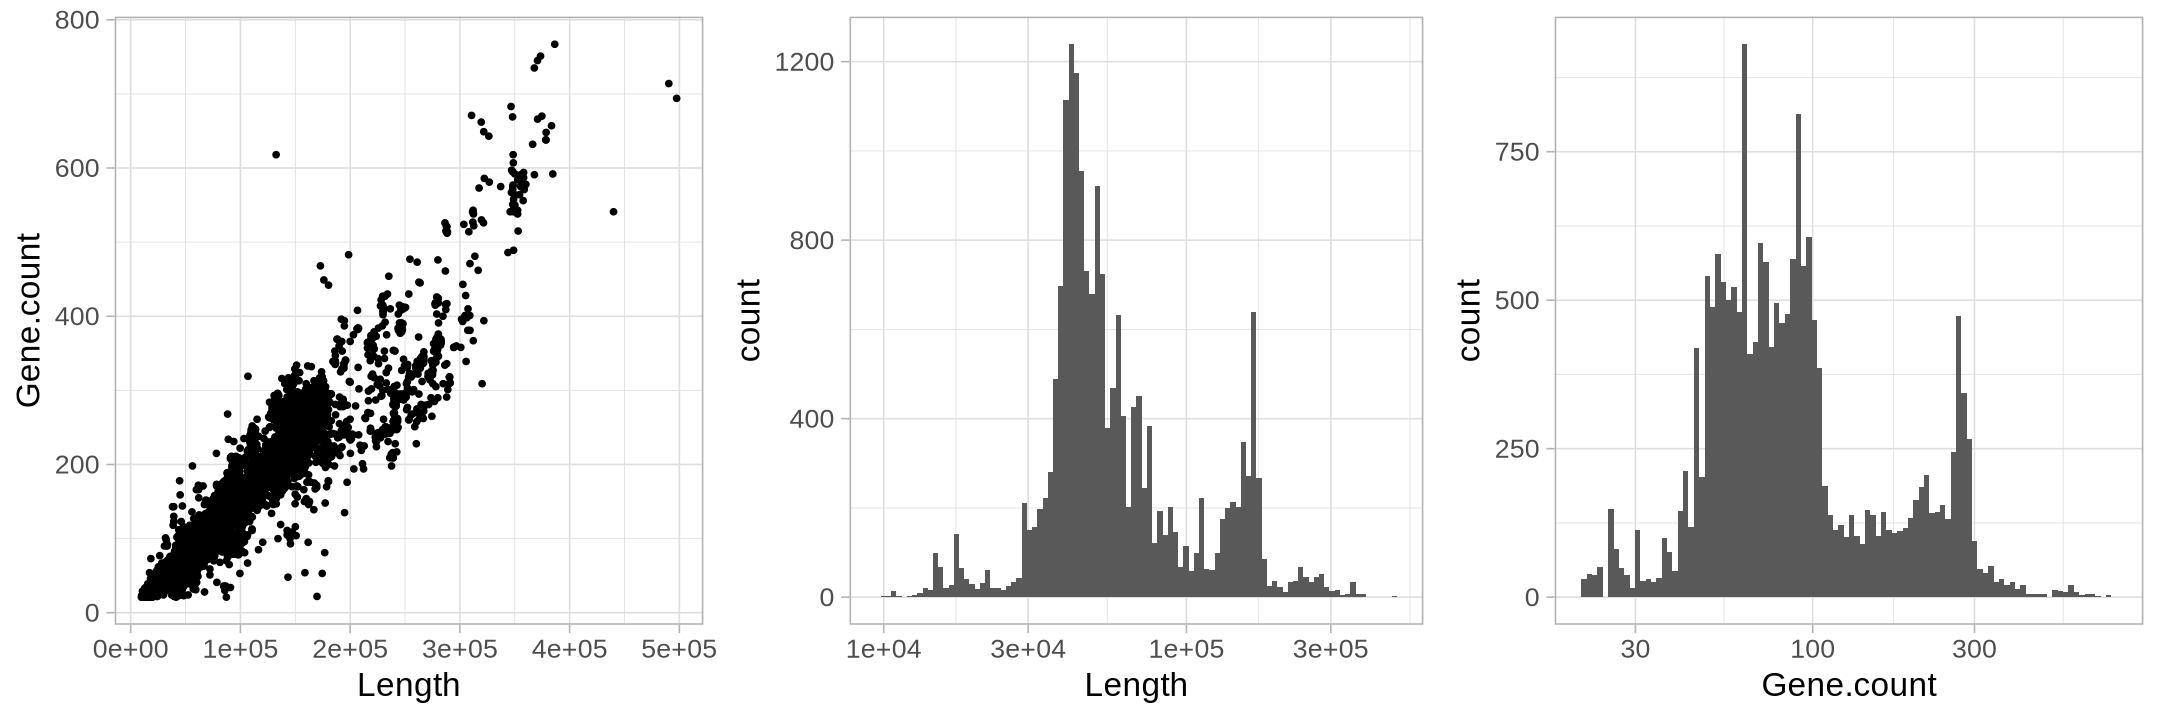

In [14]:
# Genome QC
options(repr.plot.width=18, repr.plot.height=6)

## Plot
p1 <- ggplot(report, aes(Length, Gene.count)) +
  geom_point() +
  theme_light(20)

## Plot
p2 <- ggplot(report, aes(Length)) +
  geom_histogram(bins = 100) +
  scale_x_continuous(trans='log10') +
  theme_light(20)

## Plot
p3 <- ggplot(report, aes(Gene.count)) +
  geom_histogram(bins = 100) +
  scale_x_continuous(trans='log10') +
  theme_light(20)

## Quantify
length(unique(report$Virus.Name))

## Arrange
plot_grid(p1, p2, p3, nrow = 1, rel_widths = c(1,1,1))

In [15]:
# Combine GTF

## Add set
training$features$set <- 'training'
validation$features$set <- 'validation'
test$features$set <- 'test'
test2$features$set <- 'test2'

## Combine
features <- rbind(
    training$features,
    validation$features,
    test$features,
    test2$features
)

## Create keys
features$protein_key <- paste(
    features$Gene.CDS.Protein.FASTA.Sequence.ID, 
    features$Gene.CDS.Protein.FASTA.Title
)
features$acc_protein_key <- paste(sep='__',
    features$Accession, features$protein_key
)

## Add protein sequences
features$protein_seq <- NA

### Training
index_a <- features$set == 'training'
index_b <- match(features$protein_key[index_a], names(training$protein))
features$protein_seq[index_a] <- as.character(training$protein)[index_b]

## View
str(features, max.level = 0)
length(unique(features$Accession))
table(features$Accession %in% report$Accession)

## Filter
features <- features[which(features$Accession %in% report$Accession), ]

## View
str(features, max.level = 0)

'data.frame':	5923580 obs. of  74 variables:


[1] 66821


  FALSE    TRUE 
2502766 3420814 

'data.frame':	3420814 obs. of  74 variables:


In [16]:
## Duplicated genes
features$is_unique <- !duplicated(features$Gene.CDS.Protein.FASTA.Accession)
table(features$is_unique, features$set)

       
           test   test2 training validation
  FALSE   43439 1367859      229        350
  TRUE  1977989       0     9412      21536

In [17]:
# Modify report
options(repr.plot.width=10, repr.plot.height=5)

## Variables
genus_size <- 30

## Extract host genus
report$genus <- case_when(
    report$Host.Name == 'human metagenome' ~ "Metagenome",
    report$Host.Name == 'Homo sapiens' ~ "Metagenome",
    report$Host.Name == 'Bos taurus' ~ "Metagenome",
    report$Host.Name == 'Sus scrofa' ~ "Metagenome",
    str_detect(report$Host.Name, 'Aves') ~ "Metagenome",
    str_detect(report$Host.Name, 'Apis') ~ "Metagenome",
    str_detect(report$Host.Name, 'Bombyx') ~ "Metagenome",
    str_detect(report$Host.Name, '\\[Arthrobacter') ~ "Arthrobacter",
    str_detect(report$Host.Name, '\\[Clostridium') ~ "Clostridium",
    str_detect(report$Host.Name, '\\[Ruminococcus') ~ "Ruminococcus",
    report$Host.Name == '' ~ "Unknown",
    .default = report$Host.Name
)
report$genus <- str_split(report$genus, ' ', simplify=TRUE)[,1]

## Manually correct artifacts
report$genus[which(report$genus == '[Brevibacterium]')] <- 'Brevibacterium'

## Order genus
length(unique(report$genus)) # Too many to plot
index <- sort(table(report$genus), decreasing=TRUE)
report$genus <- factor(report$genus, names(index))

## Create cleaned genus
report$genus_cleaned <- as.character(report$genus)
report$genus_cleaned[report$genus %in% names(index[which(index < genus_size)])] <- 'Other'
index <- sort(table(report$genus_cleaned), decreasing=TRUE)
genus_levels <- names(index)
genus_levels <- c(genus_levels[which(genus_levels != 'Other')],'Other')
report$genus_cleaned <- factor(report$genus_cleaned, genus_levels)

## Add millard lab entries
index <- match(str_split(report$Accession,'\\.',simplify=TRUE)[,1], inphared$Accession)
report$Host_Genus <- inphared$Host[index]
report$Phage_Genus <- inphared$Genus[index]
report$Phage_Family <- inphared$Family[index]
report$Phage_Class <- inphared$Class[index]

### Order & clean host genus
index <- sort(table(report$Host_Genus), decreasing=TRUE)
report$Host_Genus <- factor(report$Host_Genus, names(index))
report$genus_cleaned <- as.character(report$Host_Genus)
report$genus_cleaned[report$Host_Genus %in% names(index[which(index < genus_size)])] <- 'Other'
index <- sort(table(report$genus_cleaned), decreasing=TRUE)
genus_levels <- names(index)
genus_levels <- c(genus_levels[which(genus_levels != 'Other')],'Other')
report$genus_cleaned <- factor(report$genus_cleaned, genus_levels)

#### Order & clean phage family
index <- sort(table(report$Phage_Family), decreasing=TRUE)
report$Phage_Family <- factor(report$Phage_Family, names(index))
report$Phage_Family <- as.character(report$Phage_Family)
report$Phage_Family[report$Phage_Family %in% names(index[which(index < 50)])] <- 'Other'
index <- sort(table(report$Phage_Family), decreasing=TRUE)
genus_levels <- names(index)
genus_levels <- c(genus_levels[which(genus_levels != 'Other')],'Other')
report$Phage_Family <- factor(report$Phage_Family, genus_levels)

[1] 359

`summarise()` has grouped output by 'set', 'genus_cleaned', 'Phage_Family'. You
can override using the `.groups` argument.


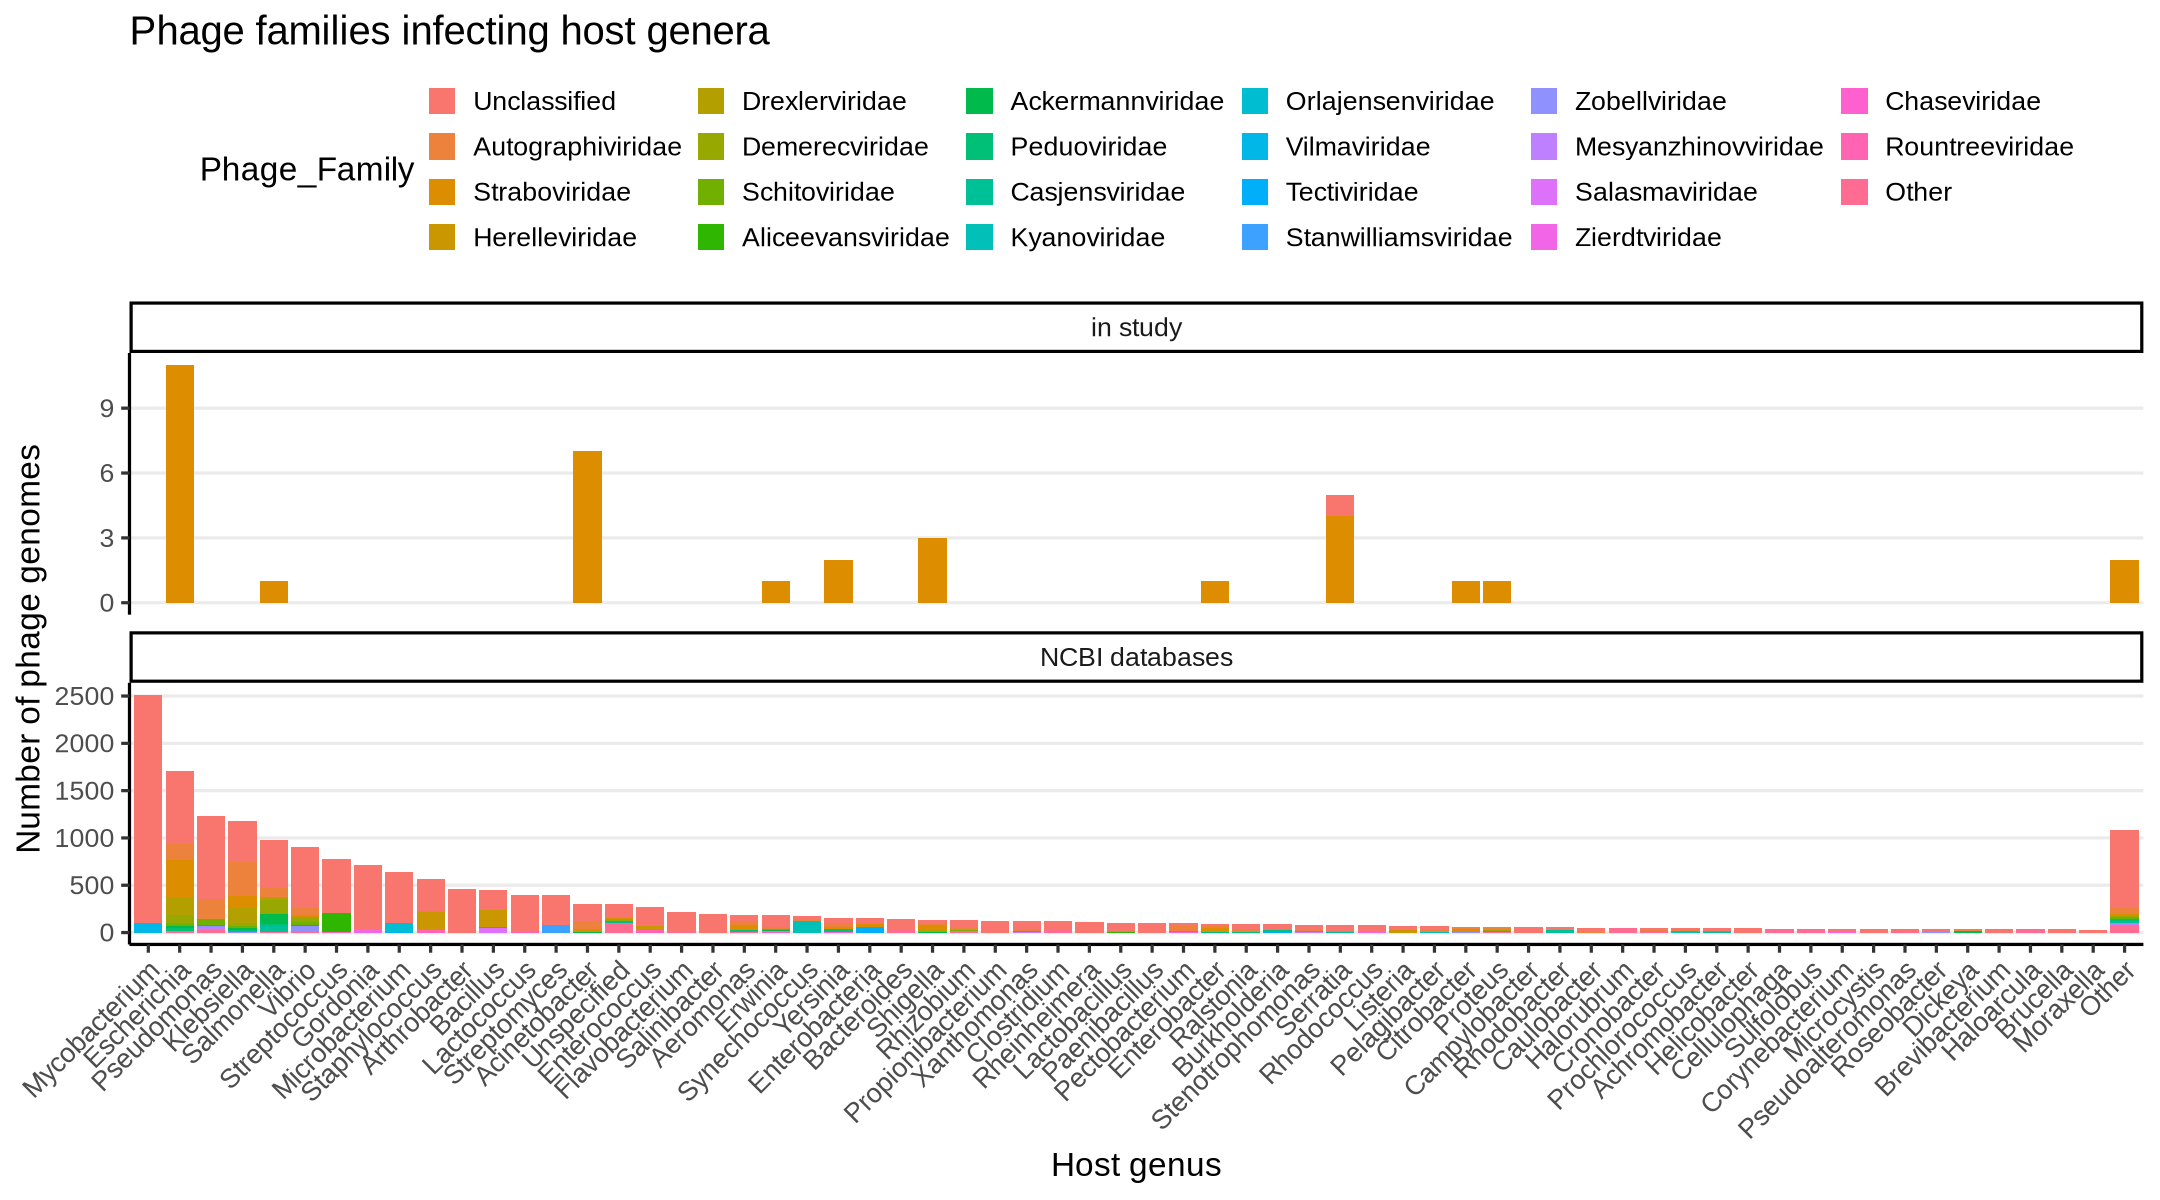

In [18]:
# Representativeness of data sets
options(repr.plot.width=18, repr.plot.height=10)

## Select
df <- report
df$N <- 1

## Summarize
df <- df %>% group_by(set, genus_cleaned, Phage_Family, Source.database) %>% summarize(total = sum(N))

## Create facets
df$facet <- NA
df$facet[df$set %in% c('training')] <- 'in study'
df$facet[df$set %in% c('test','test2','validation')] <- 'NCBI databases'
df$set <- factor(df$set, c('training','validation','test','test2'))

## Plot
ggplot(df, aes(genus_cleaned, total, fill=Phage_Family)) +
  geom_col() +
  facet_wrap(~facet, nrow = 2, scales = 'free_y') +
#  scale_fill_manual(values=c('cyan3','black')) +
  theme_classic(20) +
  theme(
      axis.text.x = element_text(angle=45,hjust=1,vjust=1),
      panel.grid.major.y = element_line()
  ) +
  guides(
      fill = guide_legend(position = 'top', nrow = 4)
  ) +
  labs(title='Phage families infecting host genera', x = 'Host genus', y='Number of phage genomes')

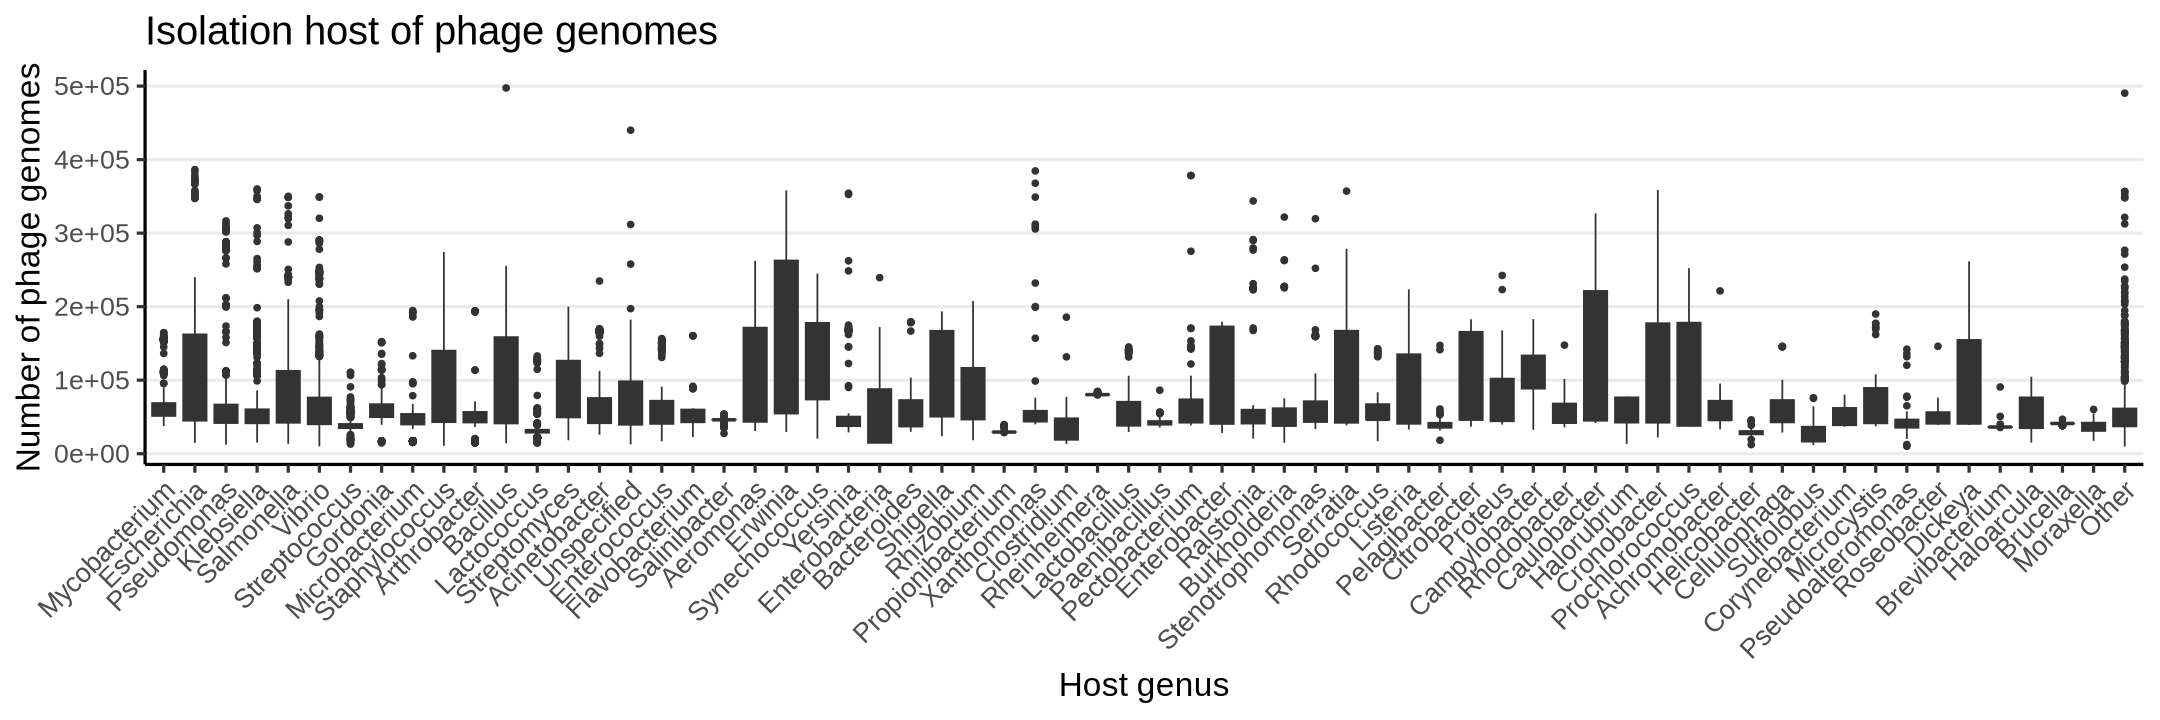

In [19]:
# Representativeness of data sets
options(repr.plot.width=18, repr.plot.height=6)

## Select
df <- report

## Plot
ggplot(df, aes(genus_cleaned, Length)) +
  geom_boxplot(fill='grey20') +
  theme_classic(20) +
  #scale_y_continuous(trans='log10') +
  theme(
      axis.text.x = element_text(angle=45,hjust=1,vjust=1),
      panel.grid.major.y = element_line()
  ) +
  guides(
      fill = guide_none()
  ) +
  labs(title='Isolation host of phage genomes', x = 'Host genus', y='Number of phage genomes')

In [20]:
# Check for duplicated accession numbers
report$is_unique <- !duplicated(report$Accession)
table(report$is_unique, report$set)

      
        test test2 training validation
  TRUE  6006 12762       35         88

In [21]:
# Annotation

## Fetch data
data <- features[features$set == 'training',]
length(unique(data$Gene.CDS.Name))

## Look up gene 
data$Gene.CDS.Name[str_detect(data$Gene.CDS.Name, 'ara') & str_detect(data$Gene.CDS.Name, 'transfer')]

# Transfer into new vector
data$annotation <- data$Gene.CDS.Name
data$annotation <- 'Other'

## Step 0 - Conserved genes
data$annotation[data$Gene.CDS.Name == 'DNA polymerase'] <- 'DNA pol'
data$annotation[str_detect(data$Gene.CDS.Name, 'clamp loader')] <- 'DNA clamp'
data$annotation[str_detect(data$Gene.CDS.Name, 'dNMP kinase')] <- 'dNMP kinase'

## Step A - dCTP modification
data$annotation[str_detect(data$Gene.CDS.Name, 'dCTP') & str_detect(data$Gene.CDS.Name, 'ase')] <- 'dCTPase'
data$annotation[str_detect(data$Gene.CDS.Name, 'peptidase') & str_detect(data$Gene.CDS.Name, 'U32')] <- 'Pep U32'
data$annotation[str_detect(data$Gene.CDS.Name, 'dCMP') & str_detect(data$Gene.CDS.Name, 'hydroxy')] <- 'Hydroxylase'

## Step B - UTP arabinosylation
data$annotation[str_detect(data$Gene.CDS.Name, 'arabinose') & str_detect(data$Gene.CDS.Name, 'isomerase')] <- 'Ara iso'
data$annotation[str_detect(data$Gene.CDS.Name, 'phosphoheptose') & str_detect(data$Gene.CDS.Name, 'isomerase')] <- 'pHep iso'
data$annotation[str_detect(data$Gene.CDS.Name, 'NTP') & str_detect(data$Gene.CDS.Name, 'transfer')] <- 'NTP transfer'
data$annotation[str_detect(data$Gene.CDS.Name, 'nucleotidyl') & str_detect(data$Gene.CDS.Name, 'transfer')] <- 'NTP transfer'

## Step C - Glucosylation
data$annotation[str_detect(data$Gene.CDS.Name, 'glucos') & str_detect(data$Gene.CDS.Name, 'transfer')] <- 'Glu transfer'

## Step D - Ararbinosylation
data$annotation[str_detect(data$Gene.CDS.Name, 'ara') & str_detect(data$Gene.CDS.Name, 'transfer')] <- 'Aat'
# Most Aat genes are not annotated !!!

## Step E - function?
data$annotation[str_detect(data$Gene.CDS.Name, 'thymidylate') & str_detect(data$Gene.CDS.Name, 'synthase')] <- 'Thy syn'
data$annotation[str_detect(data$Gene.CDS.Name, 'thymidylate') & str_detect(data$Gene.CDS.Name, 'kinase')] <- 'Thy kin'

unique(data$annotation)
length(unique(data$annotation))


[1] 1086

[1] "putative hmC-arabinosyltransferase" "putative hmC-arabinosyltransferase"

[1] "Other"        "dCTPase"      "Glu transfer" "Hydroxylase"  "DNA clamp"   
 [6] "dNMP kinase"  "Thy syn"      "NTP transfer" "DNA pol"      "Ara iso"     
[11] "Pep U32"      "Thy kin"      "Aat"          "pHep iso"

[1] 14

In [22]:
cols$annotation <- c(
    'DNA pol' = 'grey50',
    'DNA clamp' = 'grey60',
    'dCTPase' = 'purple',
    'Pep U32' = 'cyan2',
    'Hydroxylase' = 'cyan3',
    'dNMP kinase' = 'dodgerblue',
    'Thy syn' = 'navy', # aquamarine
    'Glu transfer' = 'seagreen',
    'Ara iso' = 'darkorange',
    'pHep iso' = 'orange',
    'NTP transfer' = 'yellow',
    'Thy kin' = 'hotpink',
    'Aat' = 'indianred',
    'Other' = 'grey90'
)

In [23]:
## Look up gene 
data$Gene.CDS.Name[str_detect(data$Gene.CDS.Name, 'nucleotidyl') & str_detect(data$Gene.CDS.Name, 'transfer')]
#data$Gene.CDS.Name[data$Gene.CDS.Name == 'DNA polymerase']

[1] "putative nucleotidyltransferase" "putative nucleotidyltransferase"
 [3] "putative nucleotidyltransferase" "putative nucleotidyltransferase"
 [5] "putative nucleotidyltransferase" "nucleotidyltransferase"         
 [7] "nucleotidyltransferase"          "nucleotidyltransferase"         
 [9] "nucleotidyltransferase"          "nucleotidyltransferase"         
[11] "nucleotidyltransferase"          "nucleotidyltransferase"         
[13] "nucleotidyltransferase"          "putative nucleotidyltransferase"
[15] "nucleotidyltransferase"          "nucleotidyltransferase"         
[17] "nucleotidyltransferase"          "nucleotidyltransferase"         
[19] "nucleotidyltransferase"          "nucleotidyltransferase"         
[21] "nucleotidyltransferase"          "nucleotidyltransferase"         
[23] "nucleotidyltransferase"

In [24]:
# Modify data

## Modification group
index <- match(data$Accession, tables$phages$accession)
data$aat <- tables$phages$group_aat[index]
data$modification <- tables$phages$group_modification[index]

## Genome size
data <- data %>% group_by(Accession) %>% mutate(
    genomeSize = max(Gene.CDS.Nucleotide.FASTA.Range.Stop, na.rm=TRUE) - min(Gene.CDS.Nucleotide.FASTA.Range.Start, na.rm=TRUE)
)

## Add virus name
index <- match(data$Accession, report$Accession)
data$Name <- report$Virus.Name[index]

## Manually edit annotations

### Aat
data$annotation[data$annotation == 'Glu transfer' & data$modification != 'glucose'] <- 'Aat'

## Convert to factor
data$annotation <- factor(data$annotation, names(cols$annotation))

Warning message in geom_point(data = ann, aes(x = -5000, y = Name, col = modification, :
“Ignoring unknown aesthetics: label”
Warning message:
“Removed 223 rows containing missing values or values outside the scale range
(`geom_gene_arrow()`).”


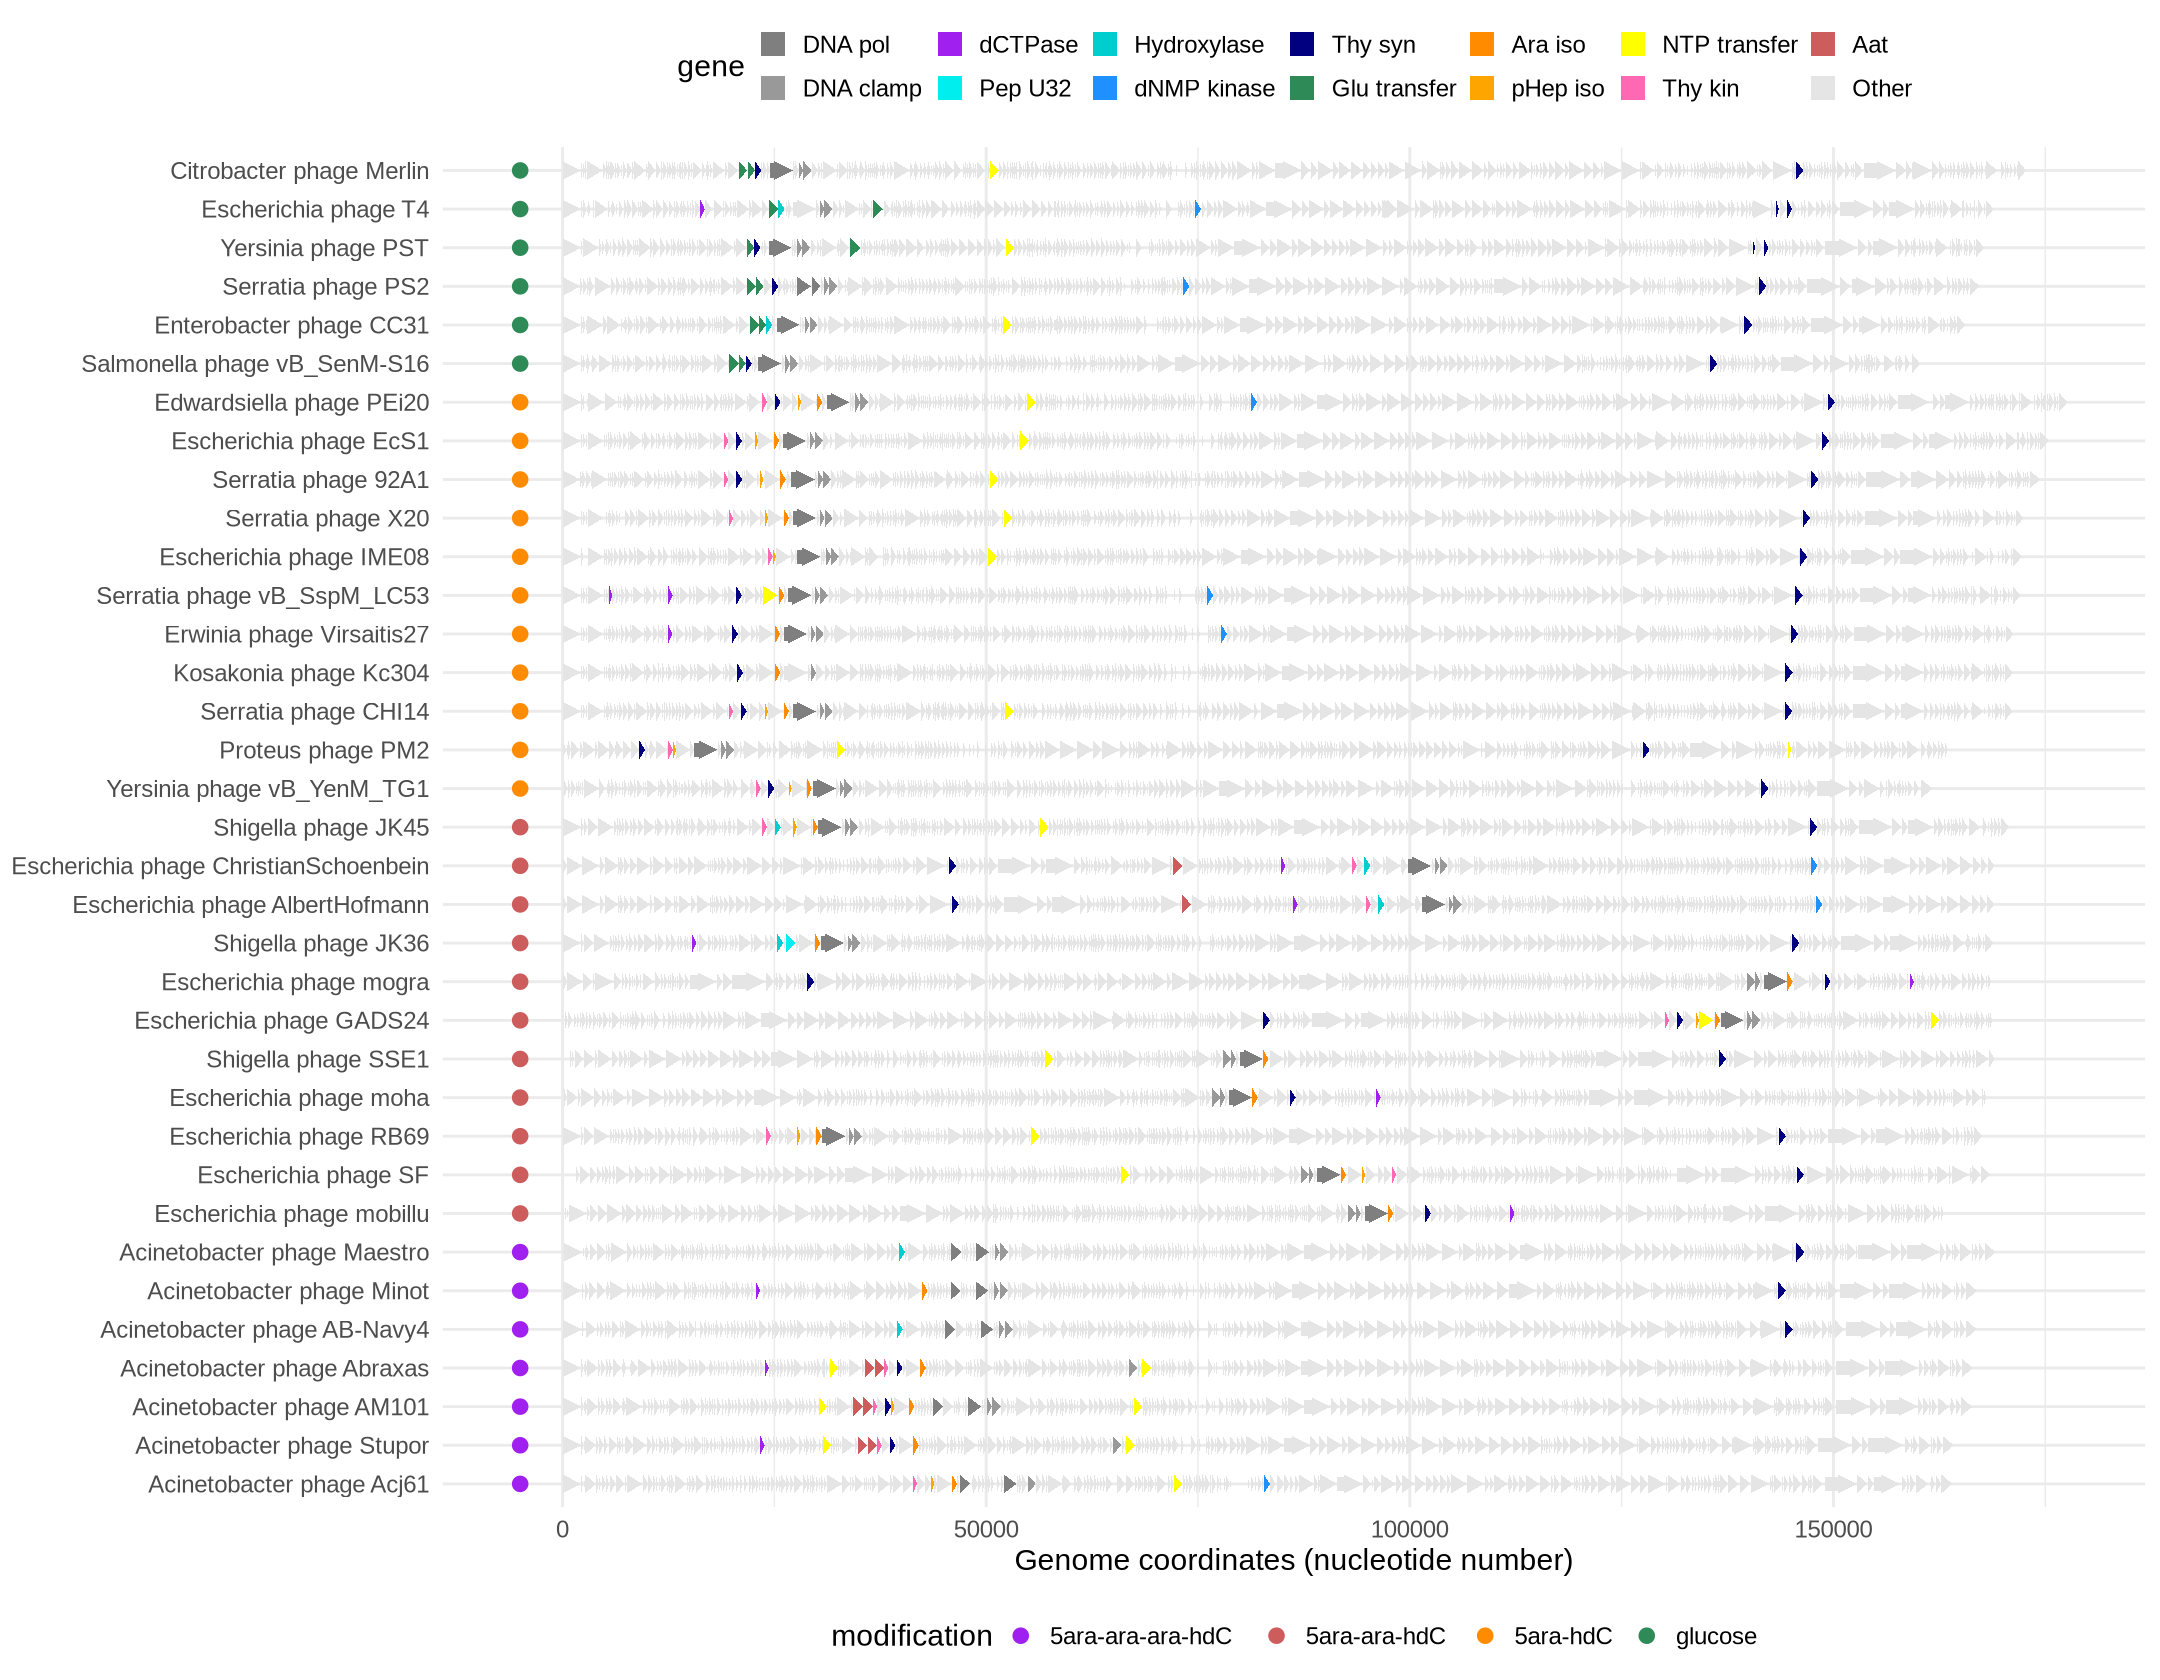

In [25]:
# Visualize genomes
options(repr.plot.width=18, repr.plot.height=14)

## Fetch data
df <- data

## Create annotations
ann <- df %>% select(Accession, modification, aat, Name) %>% unique()

## Order
df <- df[order(df$modification, df$genomeSize), ]
df$Name <- factor(df$Name, unique(df$Name))

# Plot
ggplot(df) +
    geom_gene_arrow(aes(
        xmin = Gene.CDS.Nucleotide.FASTA.Range.Start, xmax = Gene.CDS.Nucleotide.FASTA.Range.Stop, 
        y = Name, fill = annotation), col=NA
                   ) +
    scale_fill_manual(values = cols$annotation) +
    scale_color_manual(values = cols$modification) +
    geom_point(data=ann, aes(x=-5000, y=Name, col=modification, label=modification), size=4) +
    theme_minimal(18) +
    guides(fill = guide_legend(position = 'top', nrow=2), 
           col = guide_legend(position = 'bottom', nrow=1)
          ) +
    labs(x = "Genome coordinates (nucleotide number)", y = NULL, fill='gene')

In [26]:
# Annotation

## Fetch data
df <- tables$annotation
df <- df[!is.na(df$protein_id), ]
index <- match(df$protein_id, data$Gene.CDS.Protein.FASTA.Accession)

## Transfer annotation
data$annotation <- 'Other'
data$annotation[index] <- df$annotation

## View
unique(data$annotation)

[1] "Other"                        "dCTPase"                     
 [3] "beta-glucosyl-transferase"    "dCMP hydroxymethylase"       
 [5] "DNA polymerase"               "alpha-glucosyl-transferase"  
 [7] "dNMP kinase"                  "aat 2"                       
 [9] "aat 1"                        "thymidylate kinase"          
[11] "putative glycosyltransferase" "dCMP hydroxylase"            
[13] "phosphoheptose isomerase"     "NTP transferase"             
[15] "arabinose isomerase"          "aat"                         
[17] "peptidase U32"

In [27]:
cols$annotation <- c(
    'DNA polymerase' = 'grey50',
    #'DNA clamp' = 'grey60',
    'dCTPase' = 'purple',
    'peptidase U32' = 'cyan2',
    'dCMP hydroxylase' = 'cyan3',
    'dCMP hydroxymethylase' = 'cyan4',
    'dNMP kinase' = 'dodgerblue',
    #'Thy syn' = 'navy', # aquamarine
    'putative glycosyltransferase' = 'seagreen',
    'alpha-glucosyl-transferase' = 'seagreen1',
    'beta-glucosyl-transferase' = 'seagreen3',
    'arabinose isomerase' = 'darkorange',
    'phosphoheptose isomerase' = 'orange',
    'NTP transferase' = 'yellow',
    'thymidylate kinase' = 'hotpink',
    'aat' = 'firebrick',
    'aat 1' = 'indianred',
    'aat 2' = 'red',
    'Other' = 'grey90'
)

## Check overlap
index <- unique(data$annotation) %in% names(cols$annotation)
table(index)
unique(data$annotation)[which(!index)]

## Convert to factor
data$annotation <- factor(data$annotation, names(cols$annotation))

index
TRUE 
  17 

character(0)

Warning message in geom_point(data = ann, aes(x = -5000, y = Name, col = modification, :
“Ignoring unknown aesthetics: label”
Warning message:
“Removed 25 rows containing missing values or values outside the scale range
(`geom_gene_arrow()`).”


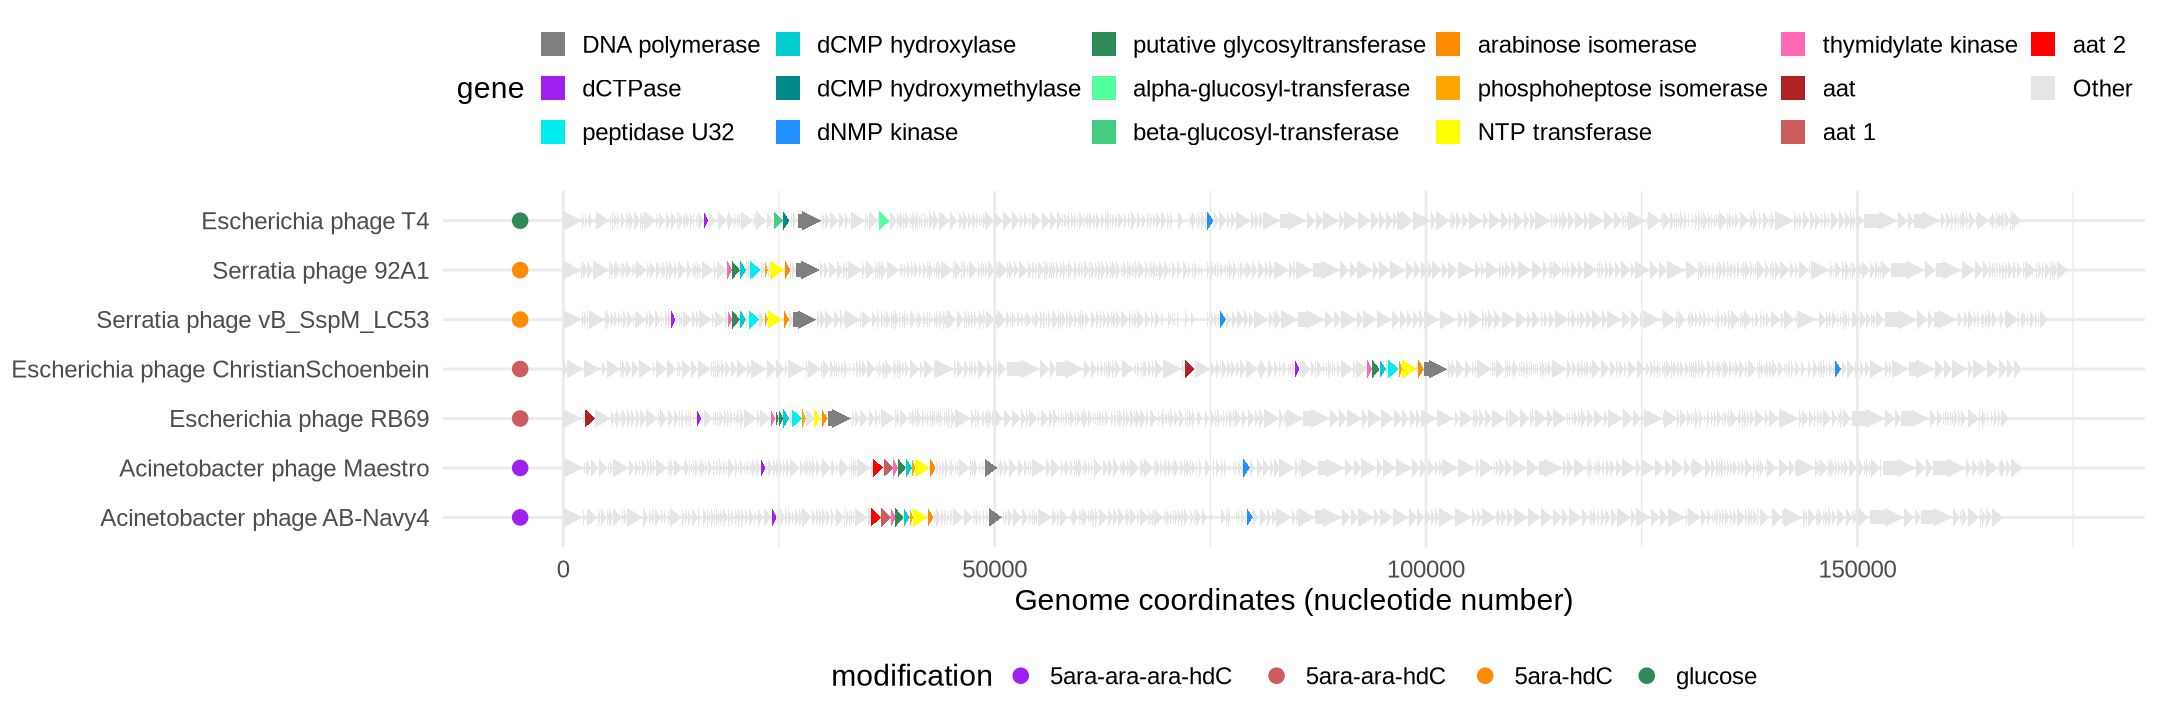

In [28]:
# Visualize genomes
options(repr.plot.width=18, repr.plot.height=6)

## Fetch data
df <- data

## Subset to annotated phages
index <- df %>% group_by(Accession) %>% summarise(annotated = sum(annotation != 'Other')) %>% subset(annotated > 0)
index <- which(df$Accession %in% index[['Accession']])
df <- df[index,]

## Create annotations
ann <- df %>% select(Accession, modification, aat, Name) %>% unique()

## Order
df <- df[order(df$modification, df$genomeSize), ]
df$Name <- factor(df$Name, unique(df$Name))

# Plot
ggplot(df) +
    geom_gene_arrow(aes(
        xmin = Gene.CDS.Nucleotide.FASTA.Range.Start, xmax = Gene.CDS.Nucleotide.FASTA.Range.Stop, 
        y = Name, fill = annotation), col=NA
                   ) +
    scale_fill_manual(values = cols$annotation) +
    scale_color_manual(values = cols$modification) +
    geom_point(data=ann, aes(x=-5000, y=Name, col=modification, label=modification), size=4) +
    theme_minimal(18) +
    guides(fill = guide_legend(position = 'top', nrow=3), 
           col = guide_legend(position = 'bottom', nrow=1)
          ) +
    labs(x = "Genome coordinates (nucleotide number)", y = NULL, fill='gene')

In [29]:
# Investigate gene annotations
options(repr.plot.width=15, repr.plot.height=12)
set.seed(42)

## Select genes
genes <- levels(data$annotation)
genes <- genes[genes != 'Other']

## Align sequences
index <- which(data$annotation %in% genes)
seq <- AAStringSet(data$protein_seq[index])
names(seq) <- paste(data$acc_protein_key[index])
result <- msa(seq)

use default substitution matrix


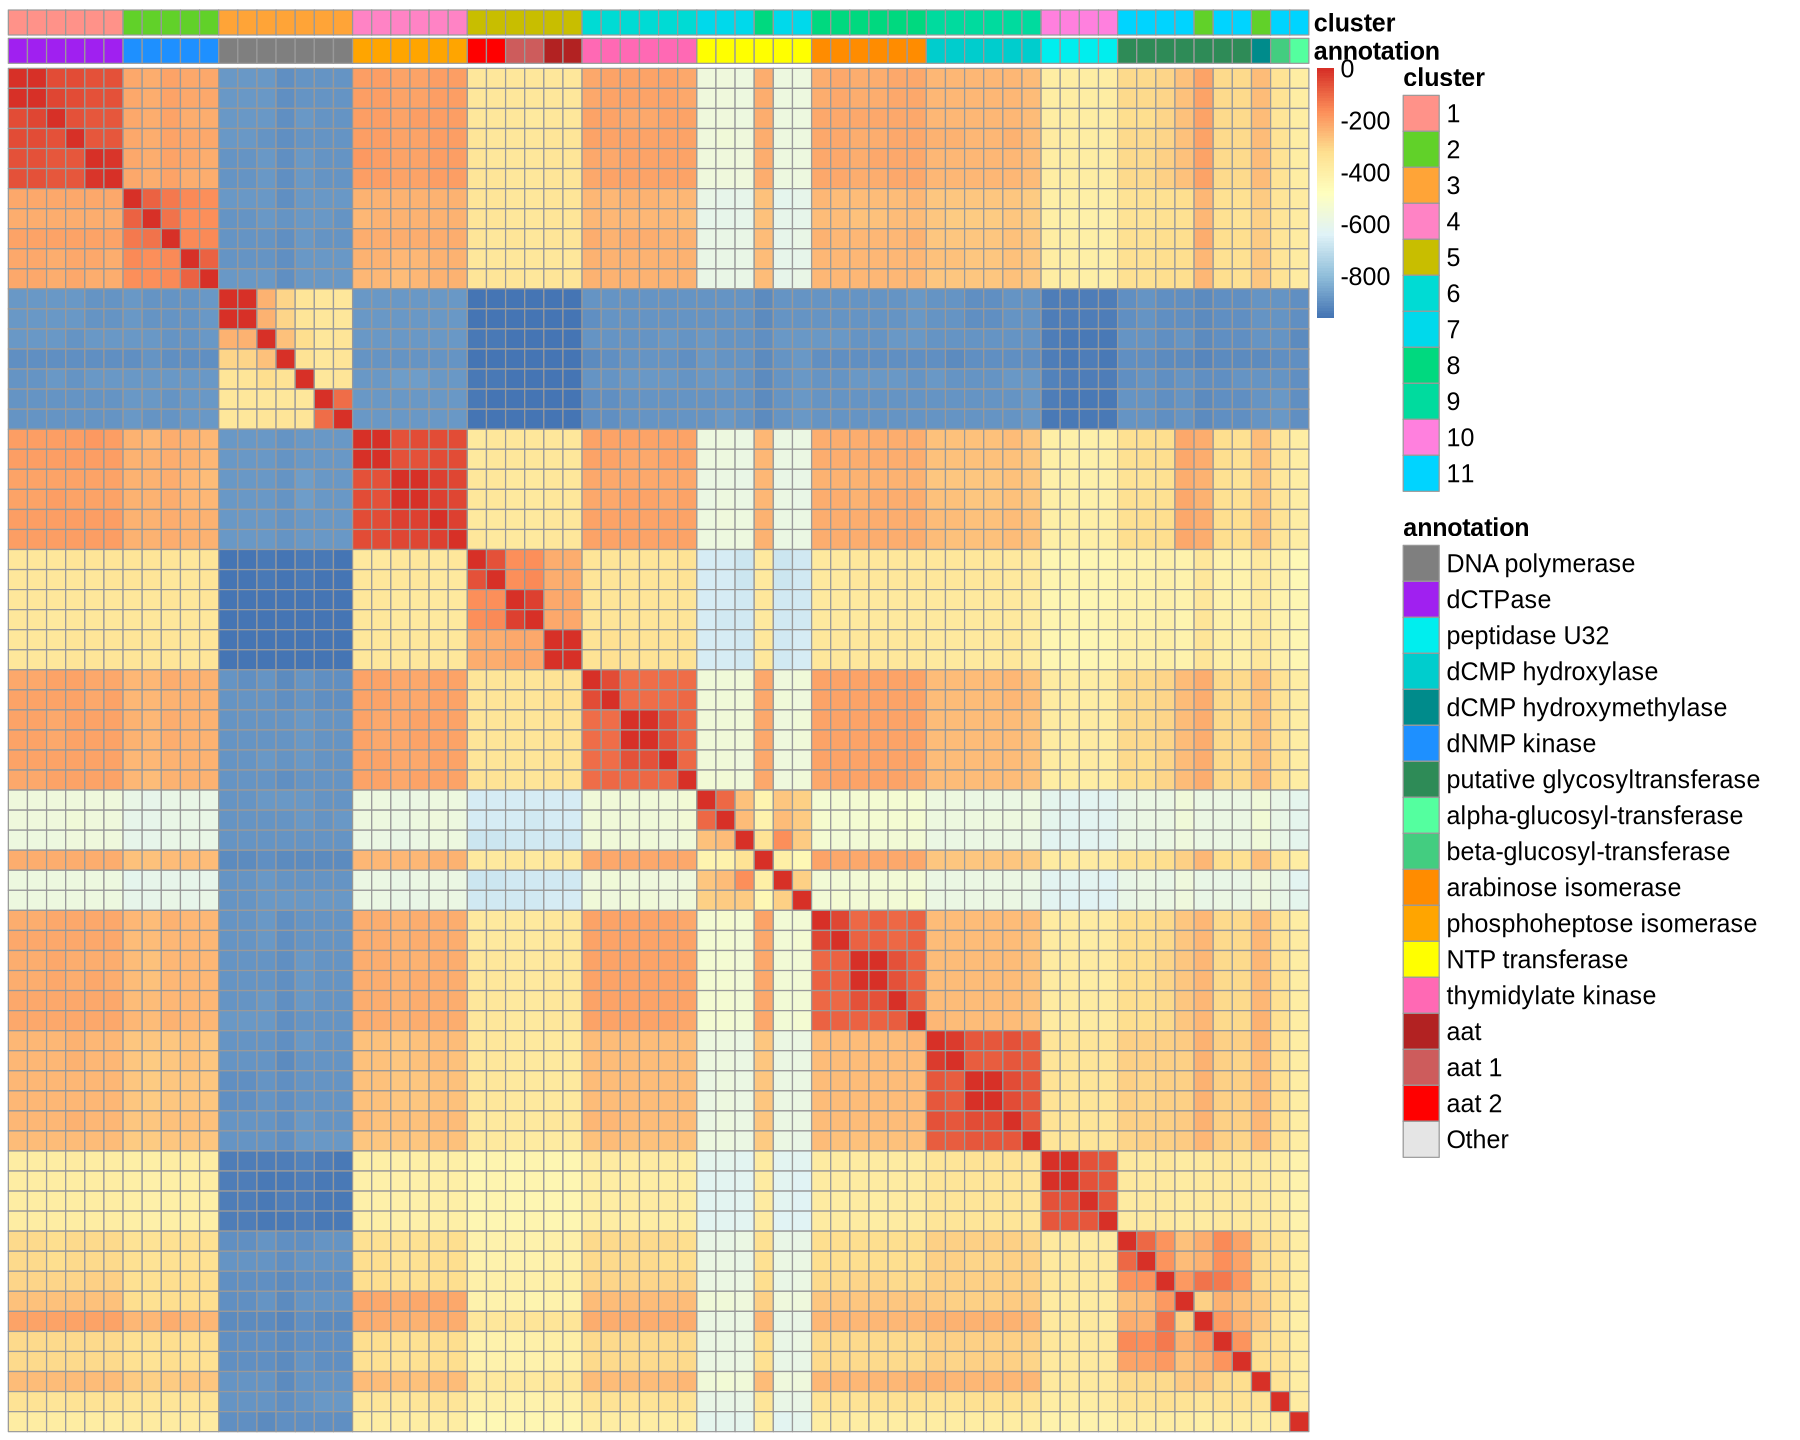

In [30]:
## Calculate distances
dist <- dist.gene(as.AAbin(result))

## Index
ind <- match(result@unmasked@ranges@NAMES, data$acc_protein_key)

## Annotate
rann <- data.frame(
    row.names = make.unique(result@unmasked@ranges@NAMES, sep = '-'),
    annotation = as.character(data$annotation)[ind]
)

## Cluster (TODO: set distance threshold instead of clustering...)
graph <- bluster::makeSNNGraph(minmax(dist), k=5)
clust <- igraph::cluster_leiden(graph, resolution_parameter = 1)
rann$cluster <- factor(clust$membership)

## Order
dist <- as.matrix(dist)
dist <- 1-dist

## Plot
pheatmap(
    mat = dist,
    show_rownames=FALSE, show_colnames=FALSE,
    cluster_rows=FALSE, cluster_cols=FALSE,
    annotation_col = rann, annotation_colors = cols,
    fontsize=15
)

use default substitution matrix
use default substitution matrix


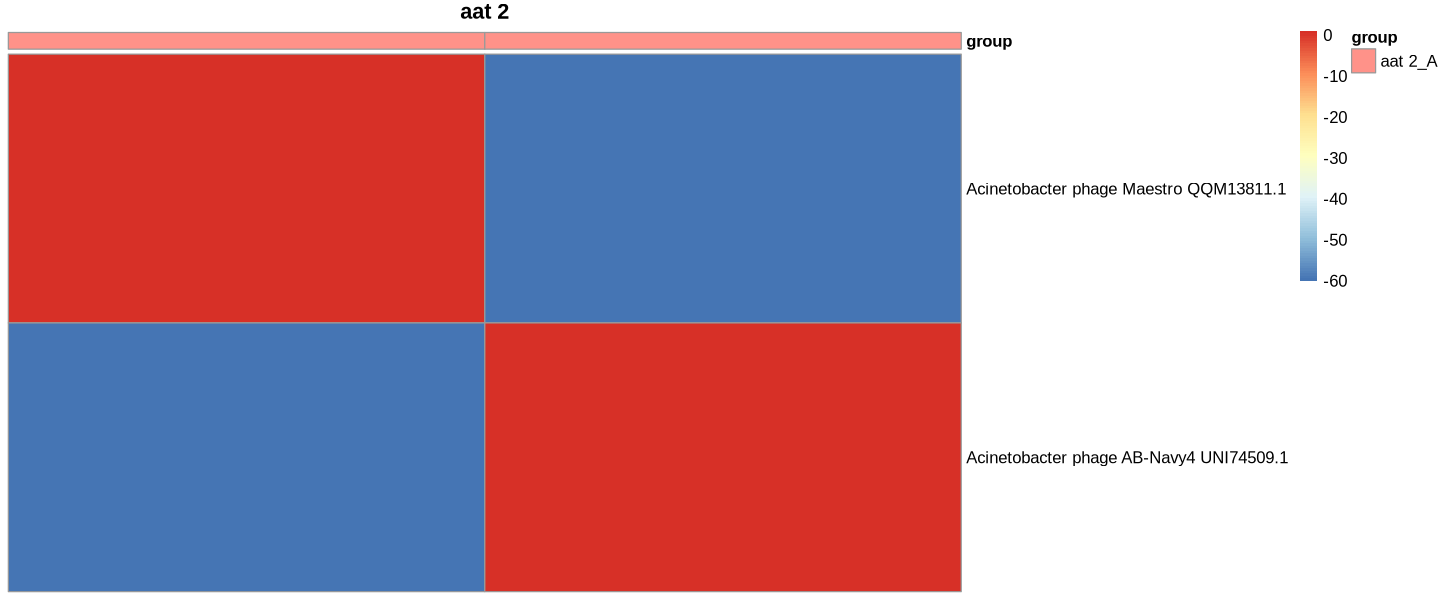

use default substitution matrix


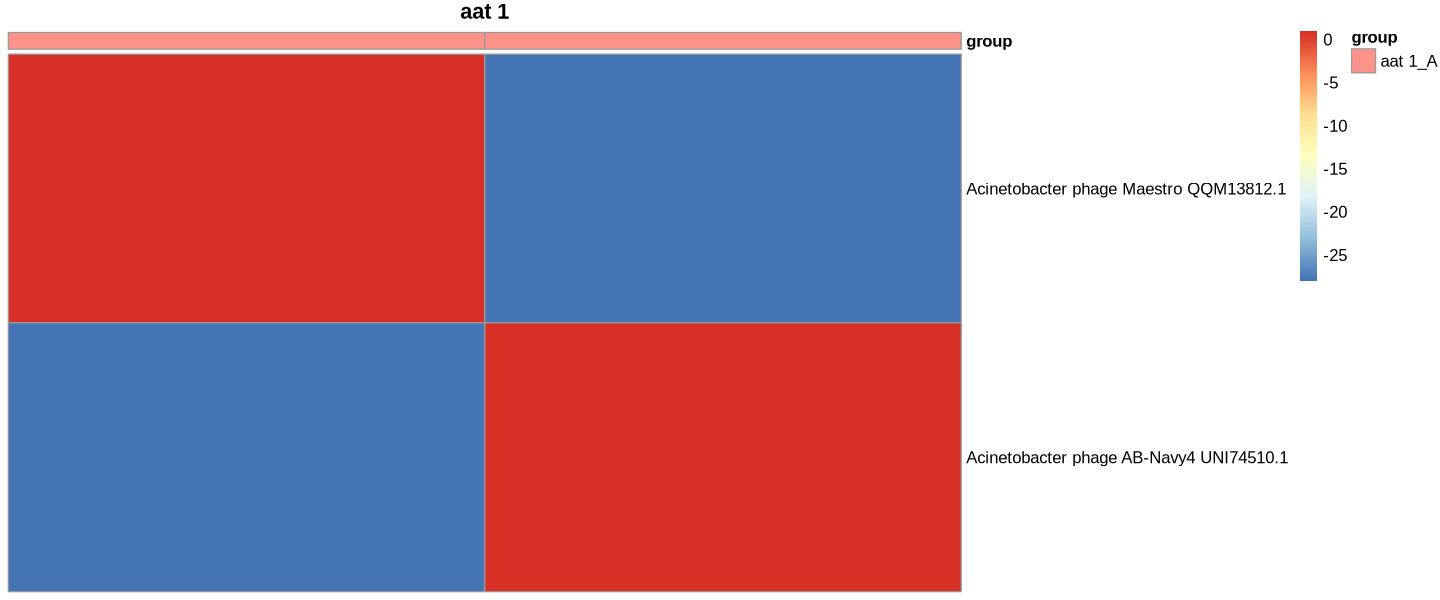

use default substitution matrix


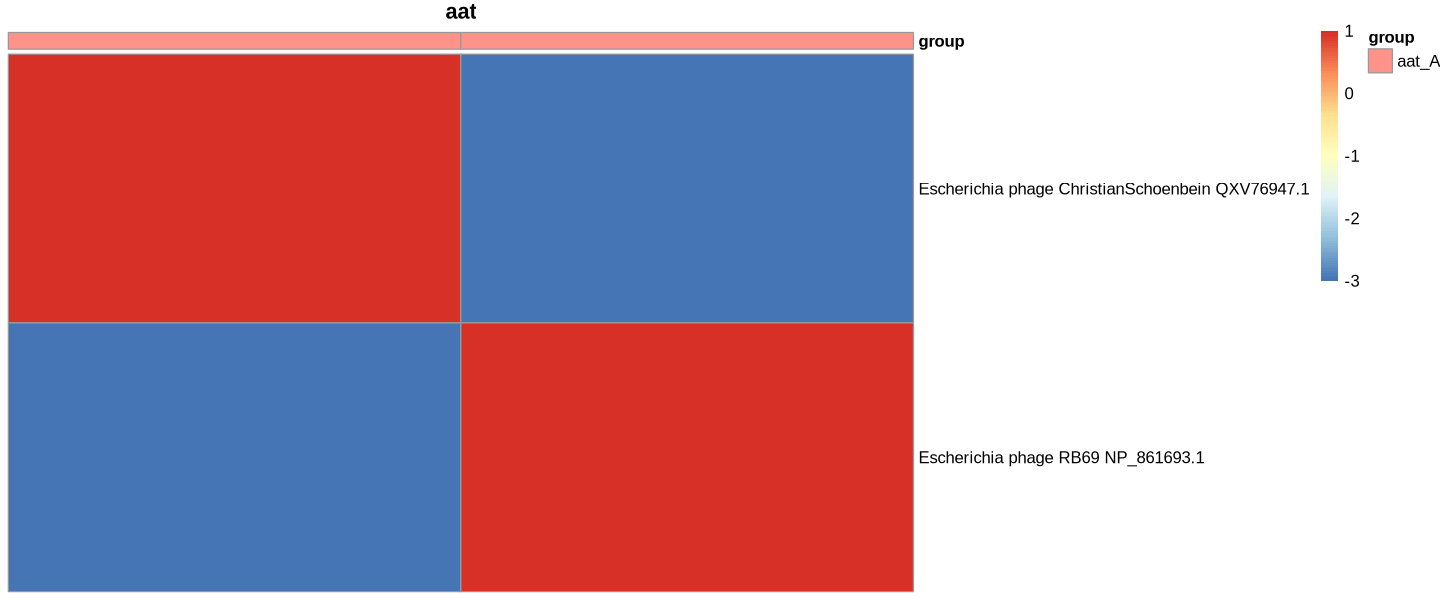

use default substitution matrix


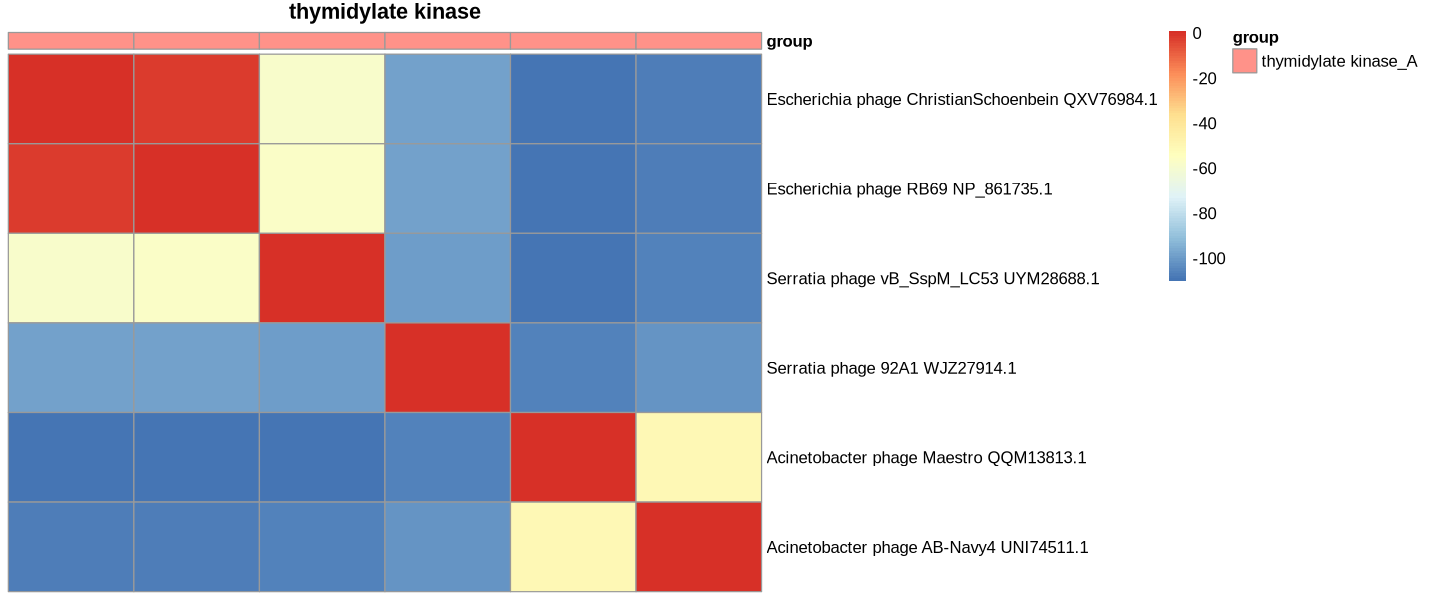

use default substitution matrix


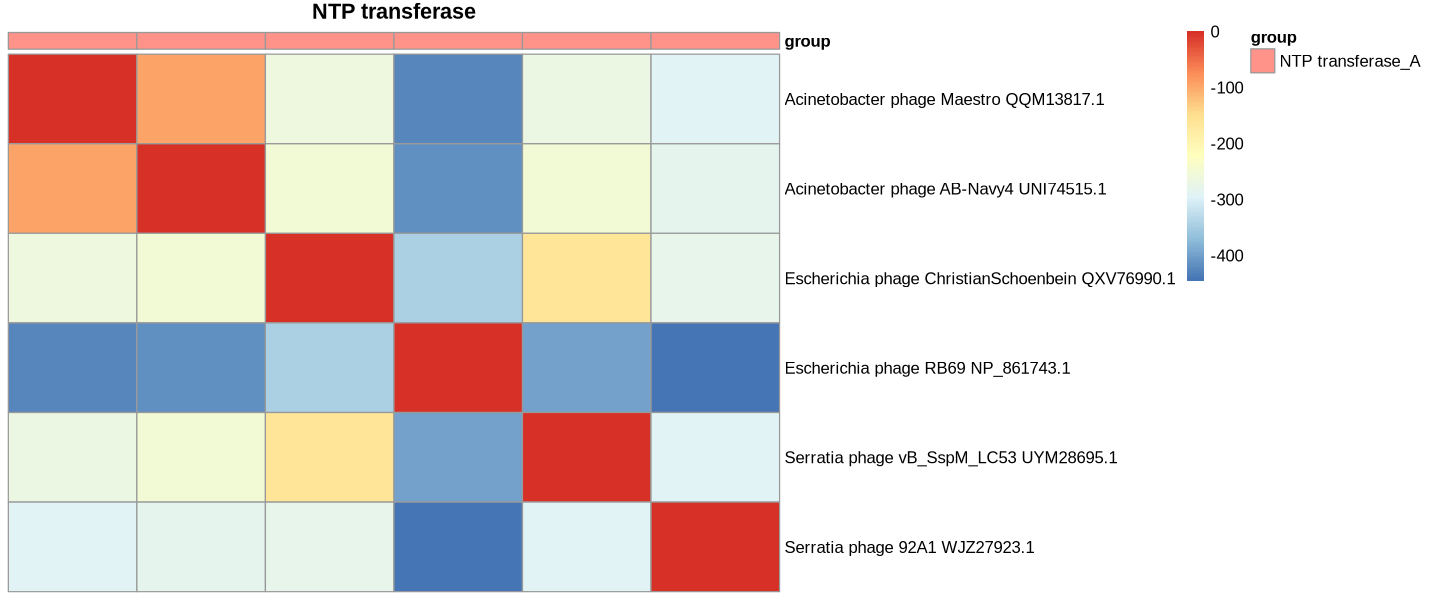

use default substitution matrix


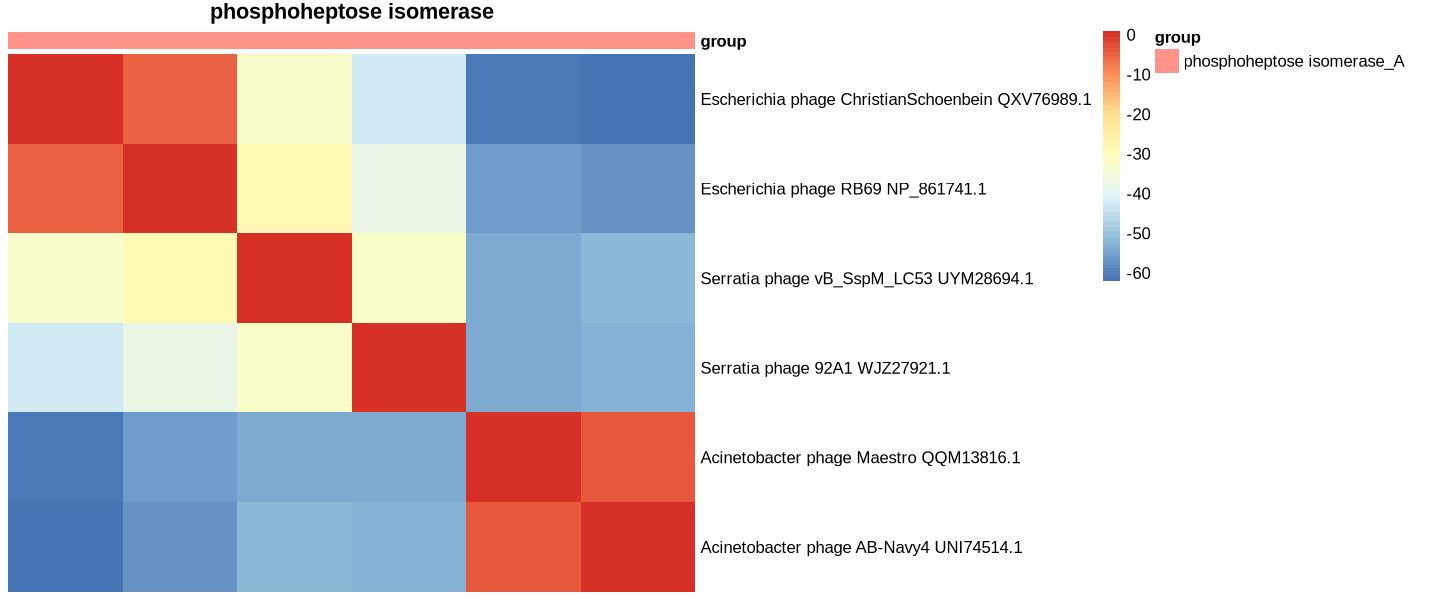

use default substitution matrix


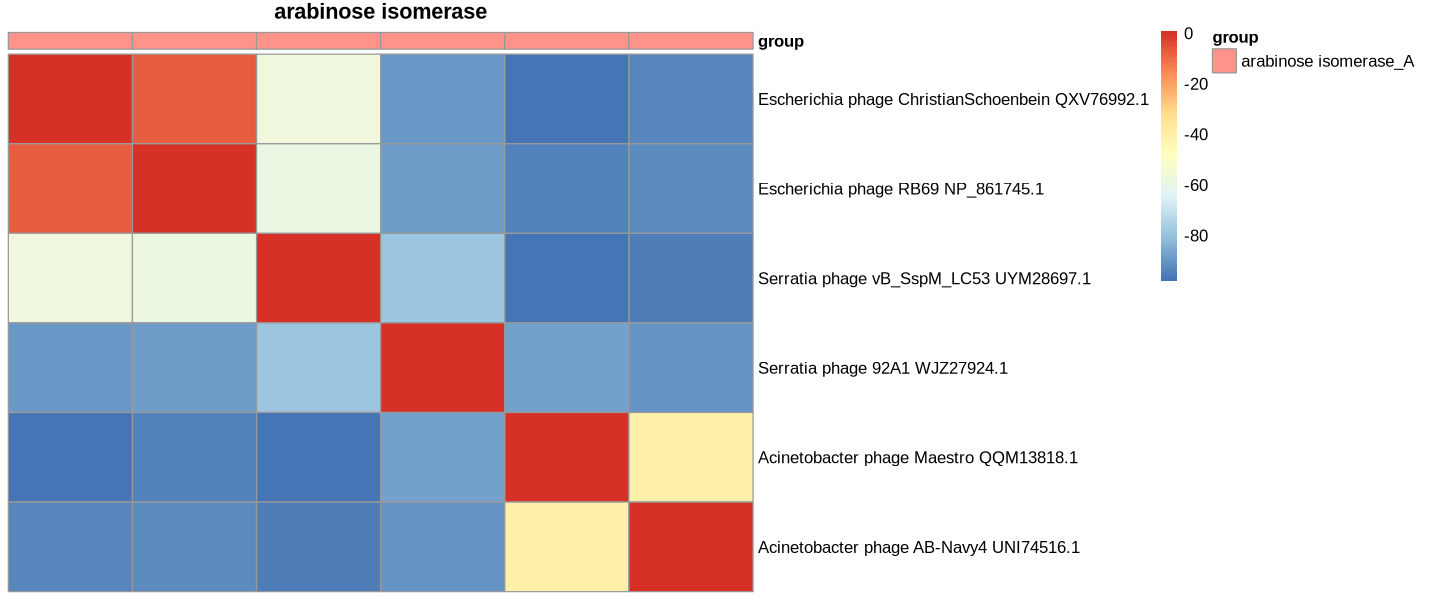

use default substitution matrix


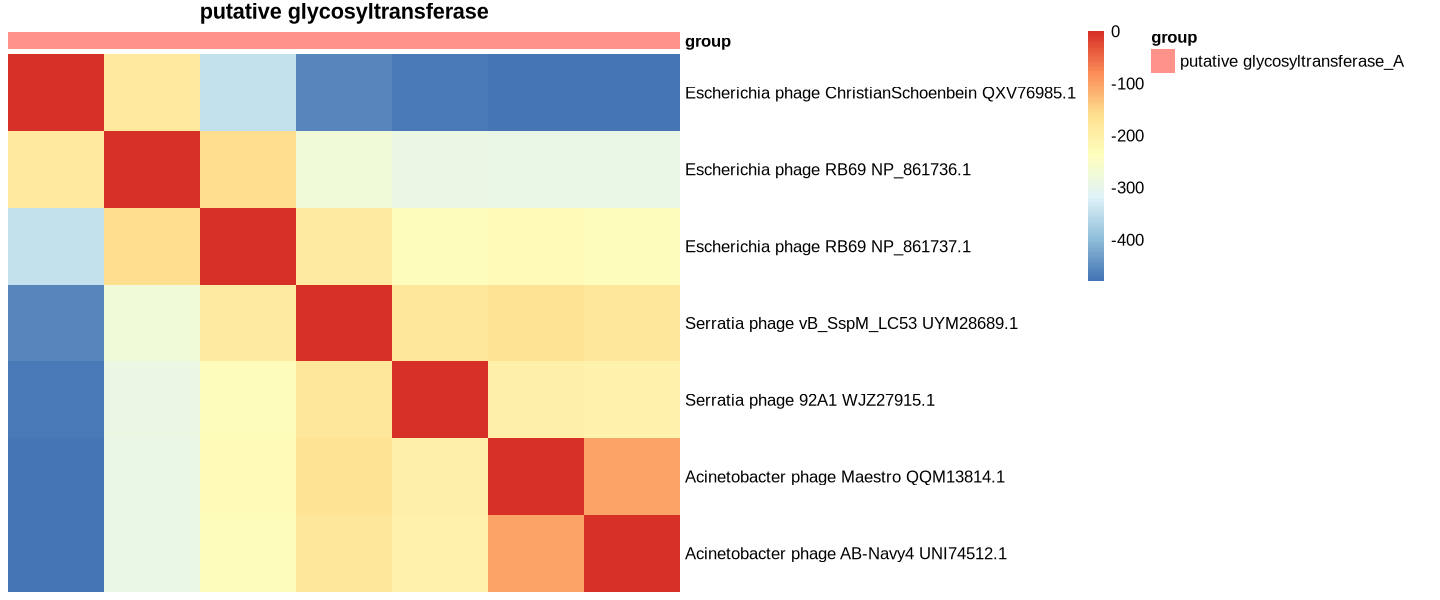

use default substitution matrix


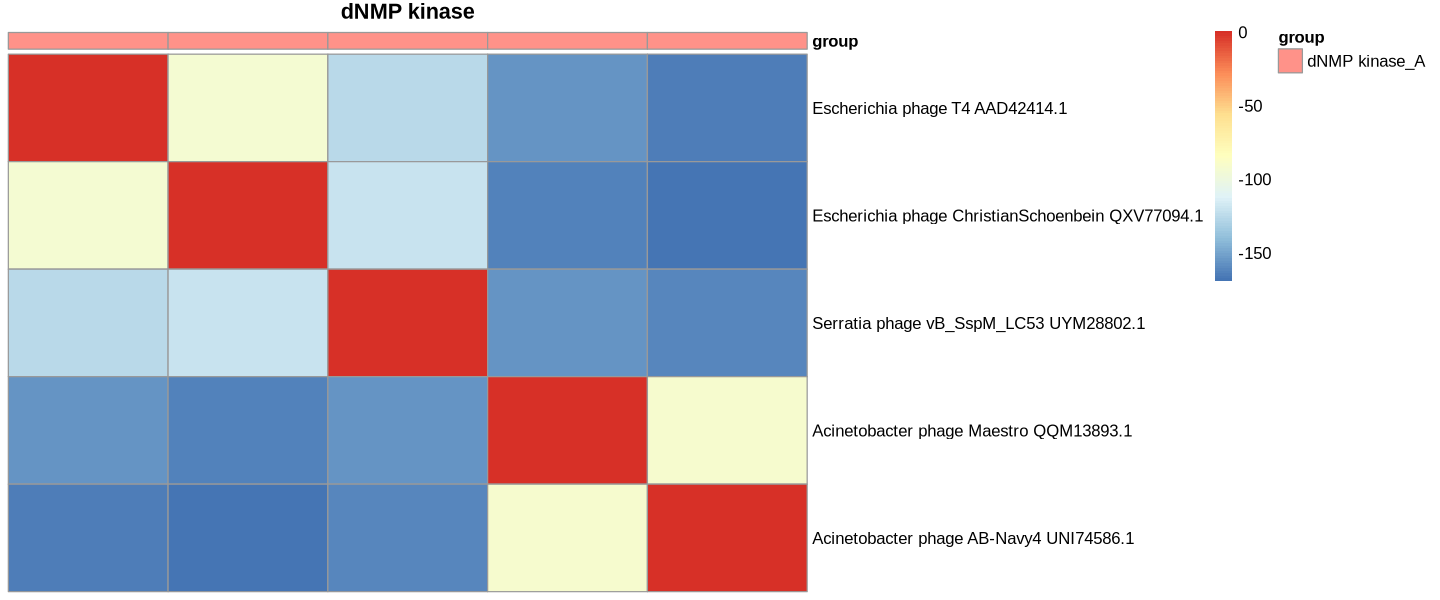

use default substitution matrix


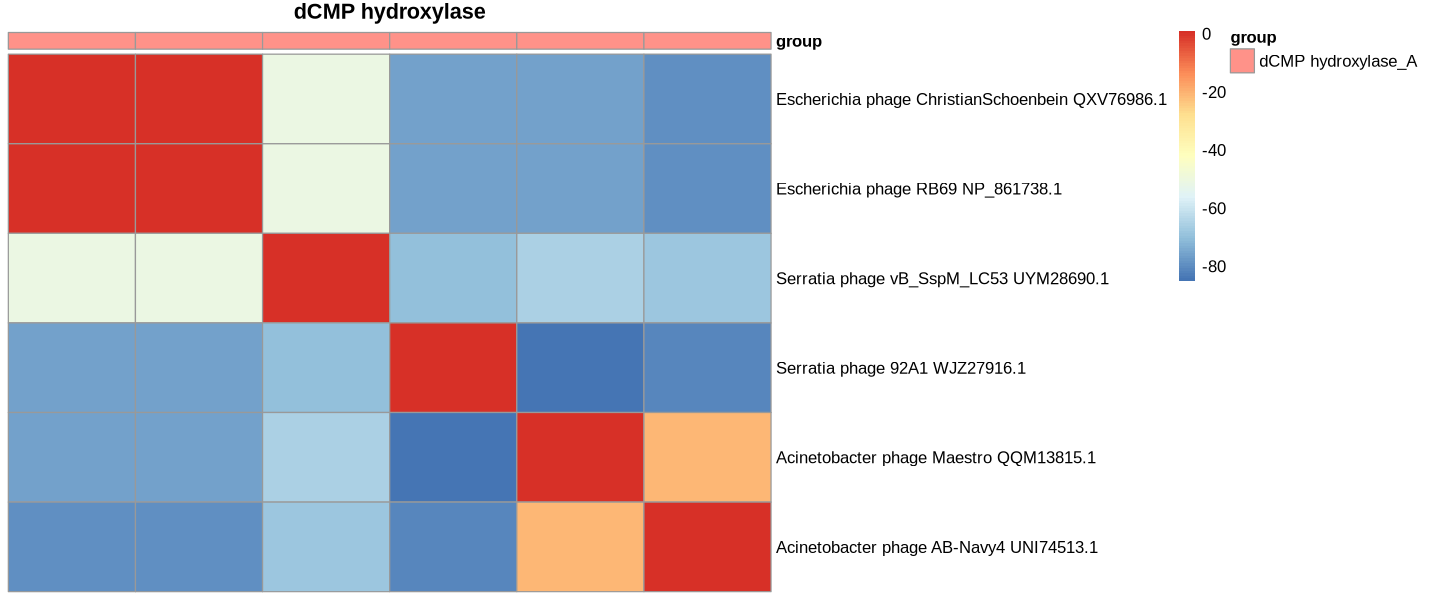

use default substitution matrix


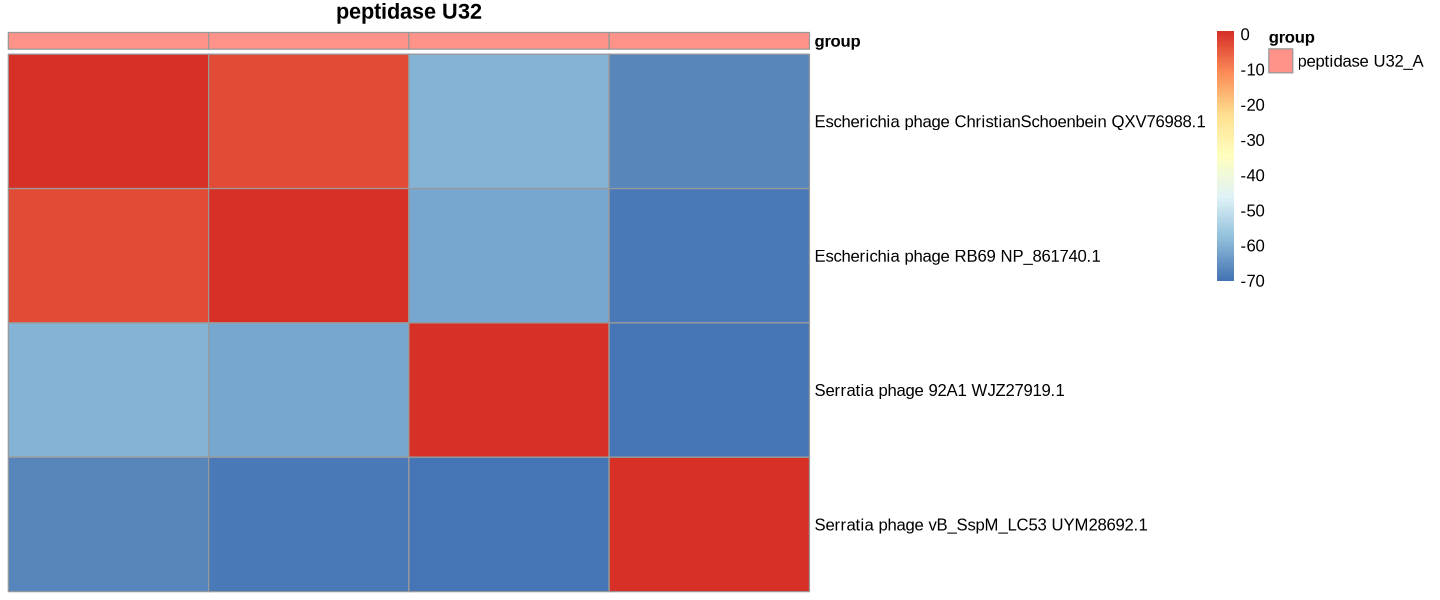

use default substitution matrix


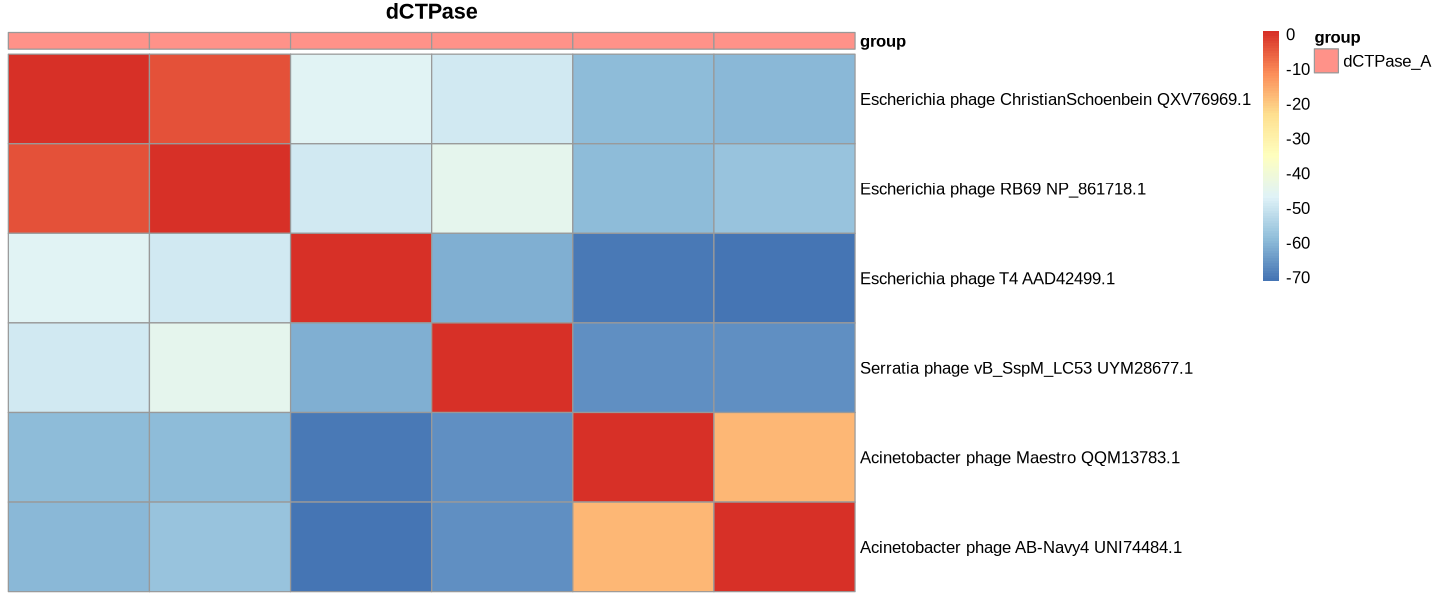

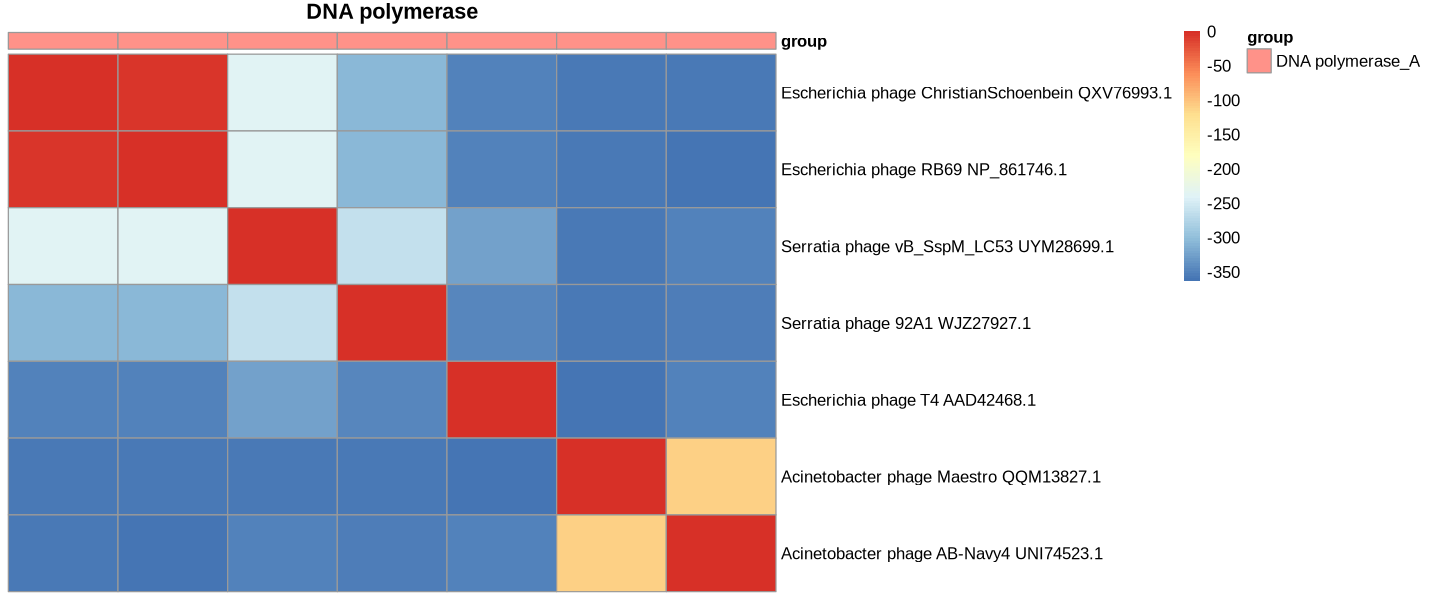

In [31]:
# Clean gene annotations
options(repr.plot.width=12, repr.plot.height=5)

## Variables
dist_threshold <- 1000
data$key <- paste(data$Name, data$Gene.CDS.Protein.FASTA.Accession)

## Set up ann_level_2
data$ann_level_2 <- 'Other'

## Fetch genes
genes <- levels(data$annotation)
genes <- genes[genes != 'Other']
genes <- rev(genes)

## Iterate over genes
for (i in genes) {
    index <- which(data$annotation == i)

    if (length(index) < 2) {
        data$ann_level_2[index] <- i
        next
    }
    
    ## MSA
    seq <- AAStringSet(data$protein_seq[index])
    names(seq) <- data$key[index]
    result <- msa(seq)
    result
    
    ## Distance matrix
    dist <- as.matrix(dist.gene(as.AAbin(result)))

    ## Split alignment to homogeneous groups
    x <- dist < dist_threshold
    x <- apply(x, 1, which, simplify = FALSE)
    x <- lapply(x, paste0, collapse='-')
    x <- unlist(x)
    lookup <- LETTERS[1:length(unique(x))]
    names(lookup) <- unique(x)

    ## Annotate groups
    cann <- data.frame(
        row.names = rownames(dist),
        group = paste(i, lookup[x], sep = '_')
    )

    ## Transfer annotation
    index <- match(rownames(cann), data$key)
    data$ann_level_2[index] <- cann$group
    
    ## Plot
    pheatmap(1-dist, 
             cluster_cols = FALSE, cluster_rows = FALSE,
             annotation_col = cann, show_colnames=FALSE,
             show_rownames = TRUE, labels_row = result@unmasked@ranges@NAMES, fontsize=10, main=i
            )
}

In [32]:
# Convert ann_level to factor
data$ann_level_2 <- factor(data$ann_level_2, unique(data$ann_level_2[order(data$annotation, decreasing = FALSE)]))
levels(data$ann_level_2)

[1] "DNA polymerase_A"               "dCTPase_A"                     
 [3] "peptidase U32_A"                "dCMP hydroxylase_A"            
 [5] "dCMP hydroxymethylase"          "dNMP kinase_A"                 
 [7] "putative glycosyltransferase_A" "alpha-glucosyl-transferase"    
 [9] "beta-glucosyl-transferase"      "arabinose isomerase_A"         
[11] "phosphoheptose isomerase_A"     "NTP transferase_A"             
[13] "thymidylate kinase_A"           "aat_A"                         
[15] "aat 1_A"                        "aat 2_A"                       
[17] "Other"

[1] "aat 2_A"                        "aat 1_A"                       
 [3] "aat_A"                          "thymidylate kinase_A"          
 [5] "NTP transferase_A"              "phosphoheptose isomerase_A"    
 [7] "arabinose isomerase_A"          "beta-glucosyl-transferase"     
 [9] "alpha-glucosyl-transferase"     "putative glycosyltransferase_A"
[11] "dNMP kinase_A"                  "dCMP hydroxymethylase"         
[13] "dCMP hydroxylase_A"             "peptidase U32_A"               
[15] "dCTPase_A"                      "DNA polymerase_A"

[1] TRUE

Warning message in dir.create(out_ann):
“'analysis/annotation' already exists”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`).”
Warning message in dir.create(out_ann):
“'analysis/annotation' already exists”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`).”


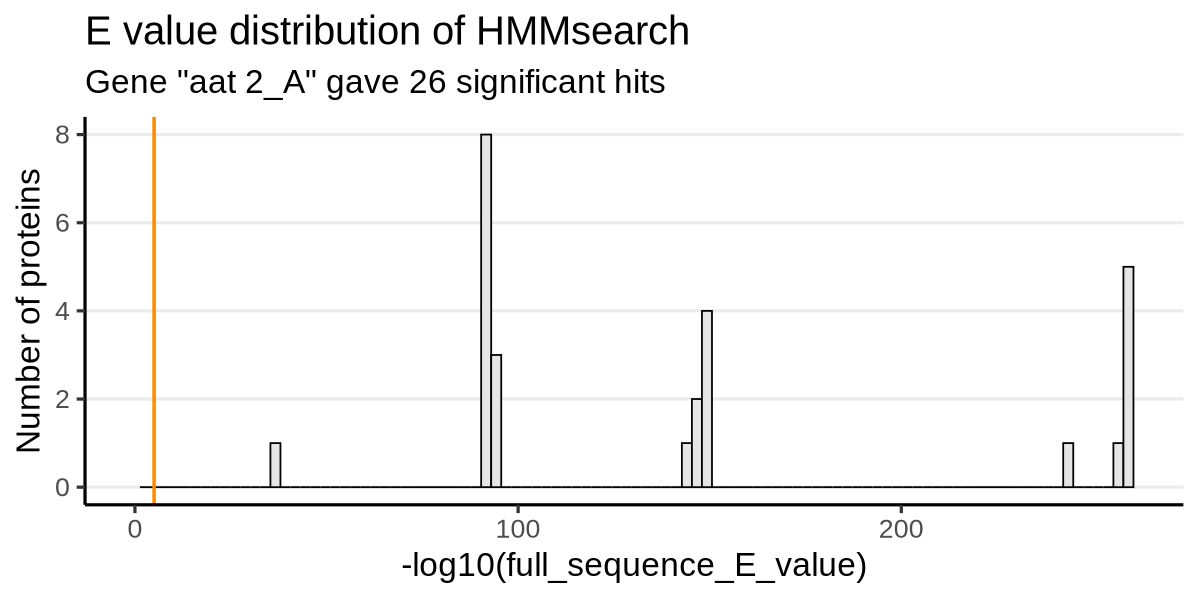

Warning message in dir.create(out_ann):
“'analysis/annotation' already exists”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`).”


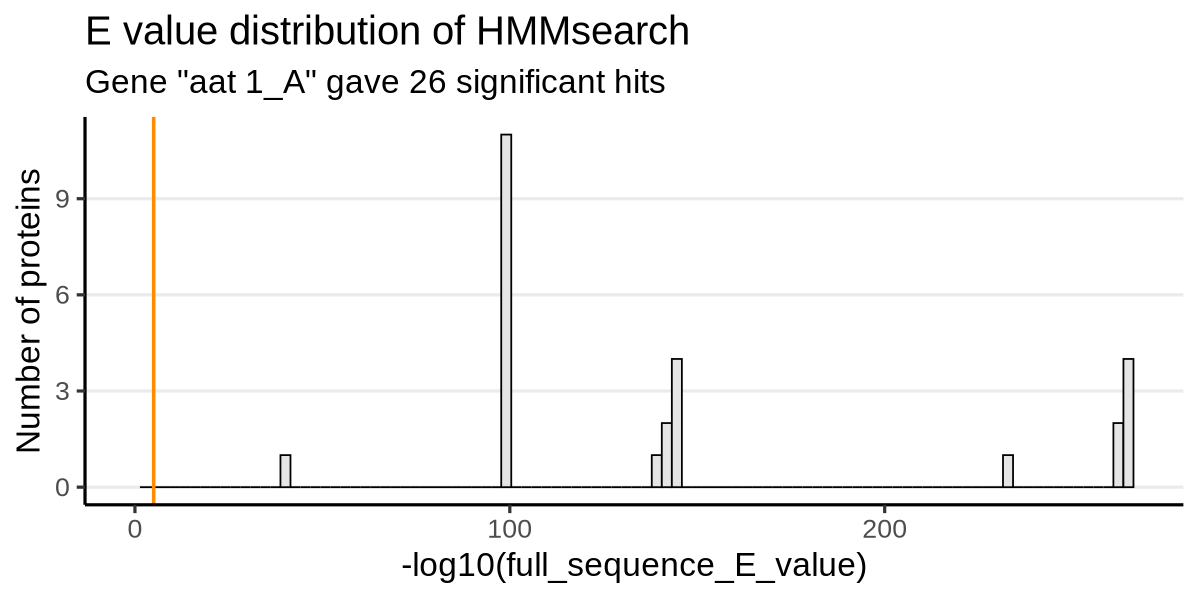

Warning message in dir.create(out_ann):
“'analysis/annotation' already exists”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`).”


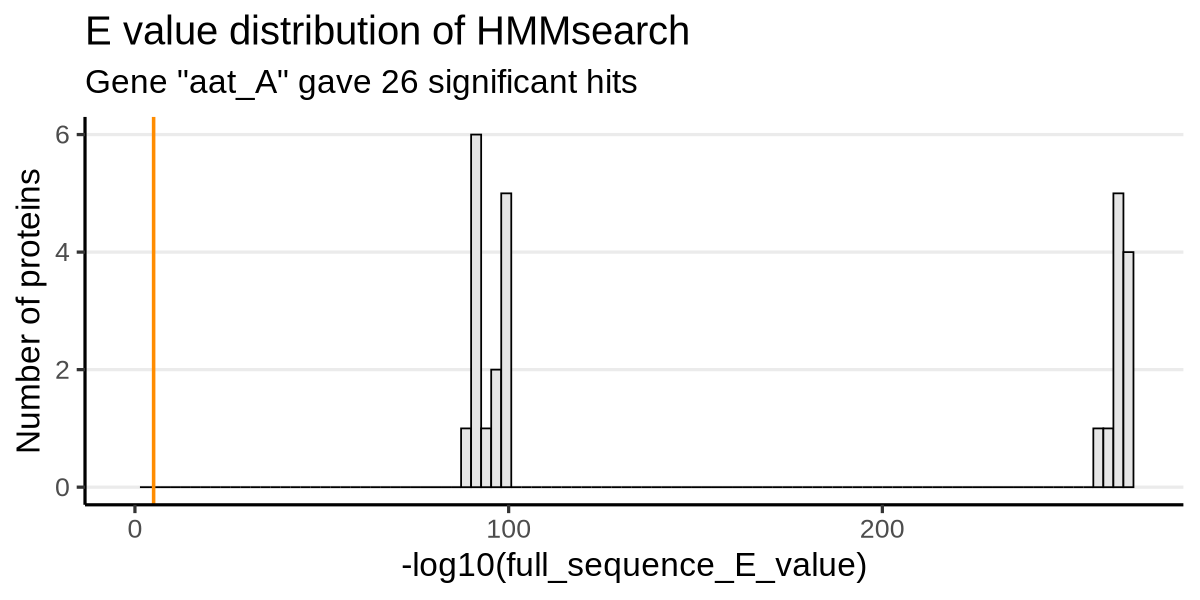

Warning message in dir.create(out_ann):
“'analysis/annotation' already exists”
Warning message in (function (..., deparse.level = 1, make.row.names = TRUE, stringsAsFactors = FALSE, :
“number of columns of result, 10, is not a multiple of vector length 4 of arg 32”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message:
“Removed 22 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 1 row conta

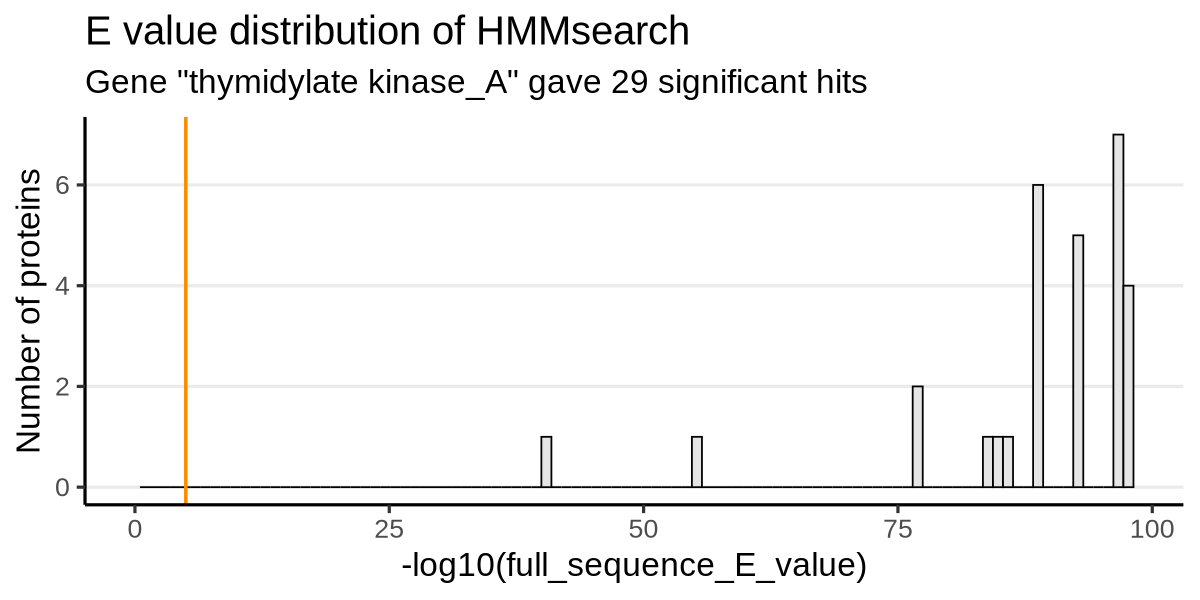

Warning message in dir.create(out_ann):
“'analysis/annotation' already exists”
Warning message in (function (..., deparse.level = 1, make.row.names = TRUE, stringsAsFactors = FALSE, :
“number of columns of result, 10, is not a multiple of vector length 4 of arg 31”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message:
“Removed 1 row containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 1 row contain

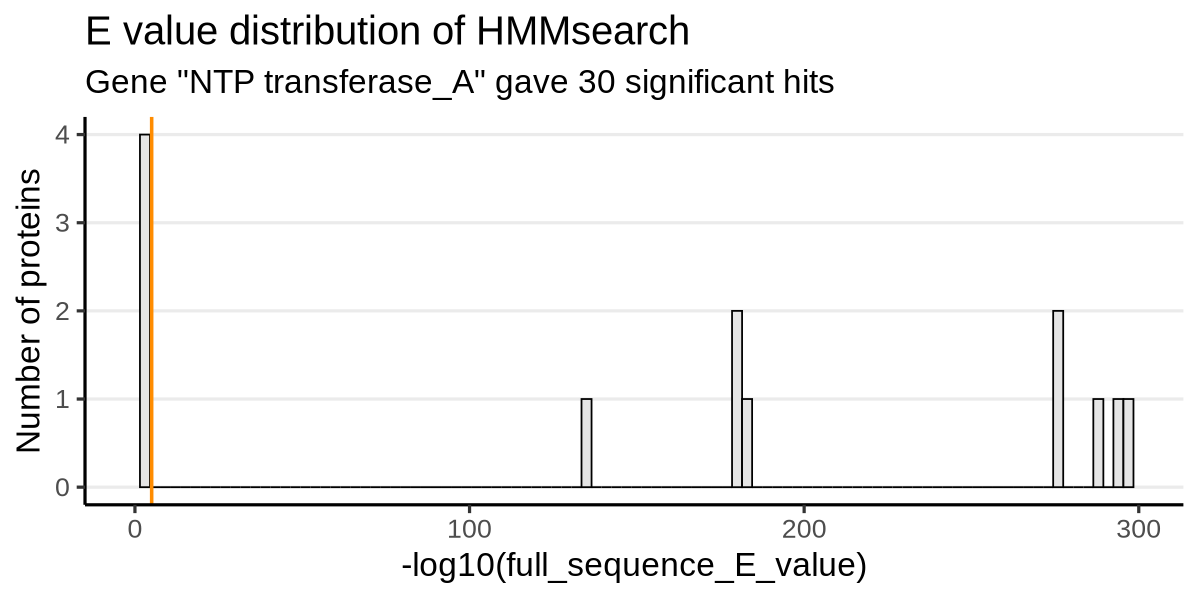

Warning message in dir.create(out_ann):
“'analysis/annotation' already exists”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`).”


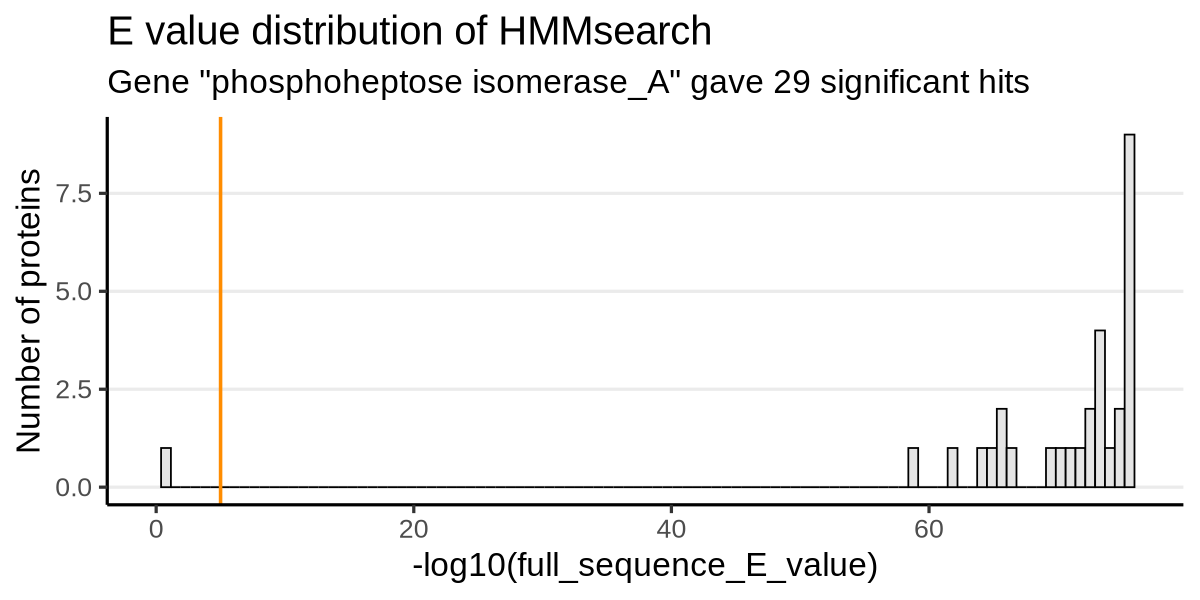

Warning message in dir.create(out_ann):
“'analysis/annotation' already exists”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`).”


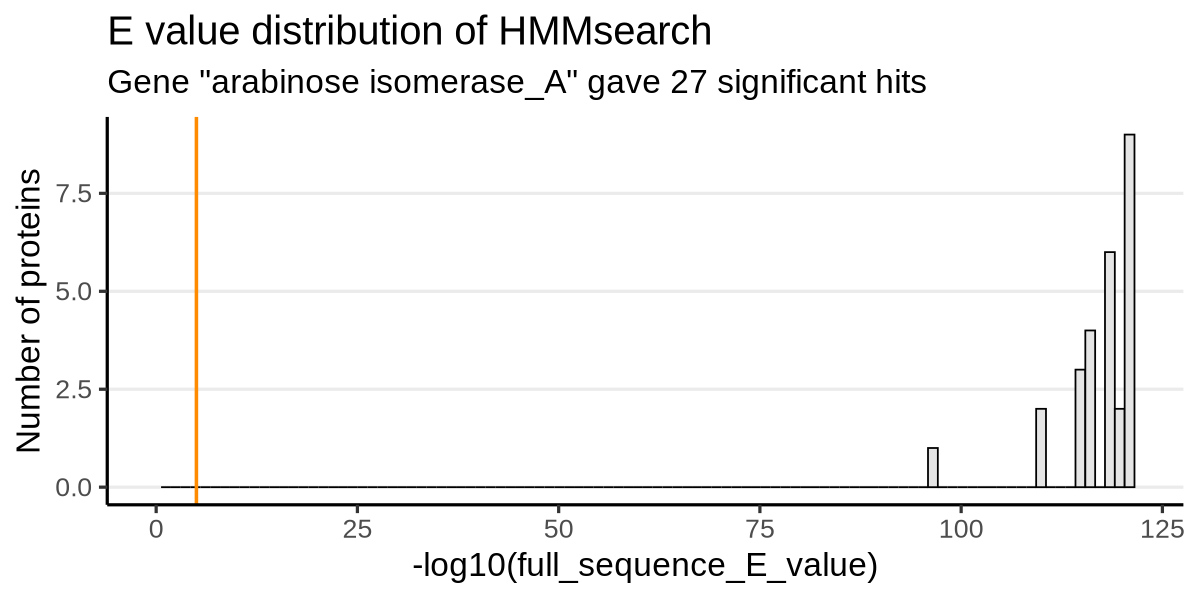

Warning message in dir.create(out_ann):
“'analysis/annotation' already exists”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`).”


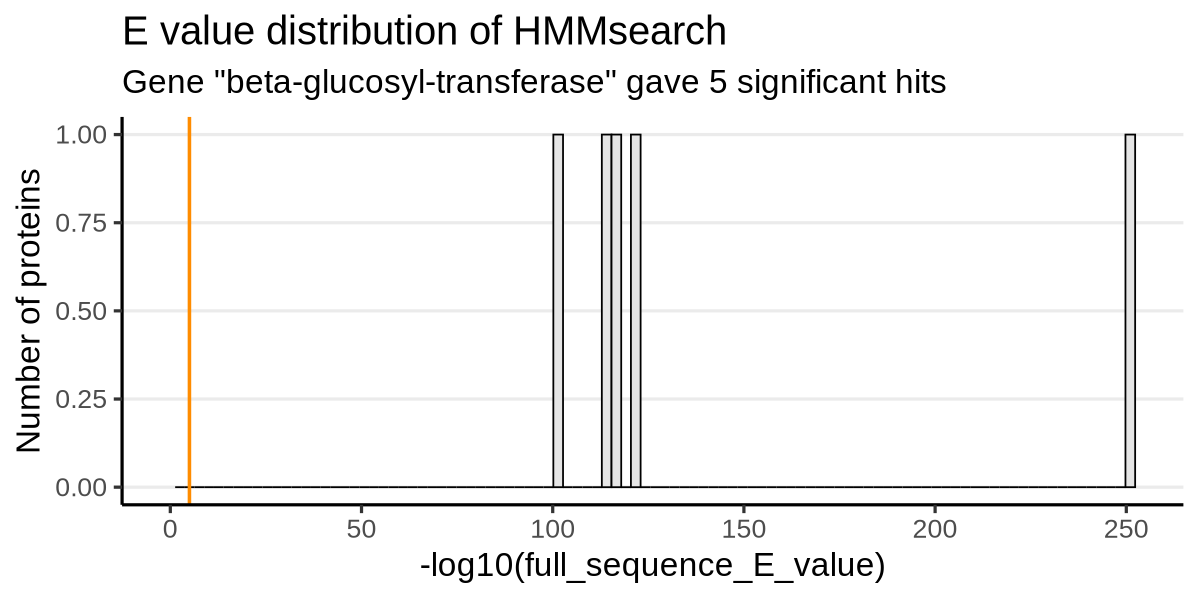

Warning message in dir.create(out_ann):
“'analysis/annotation' already exists”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`).”


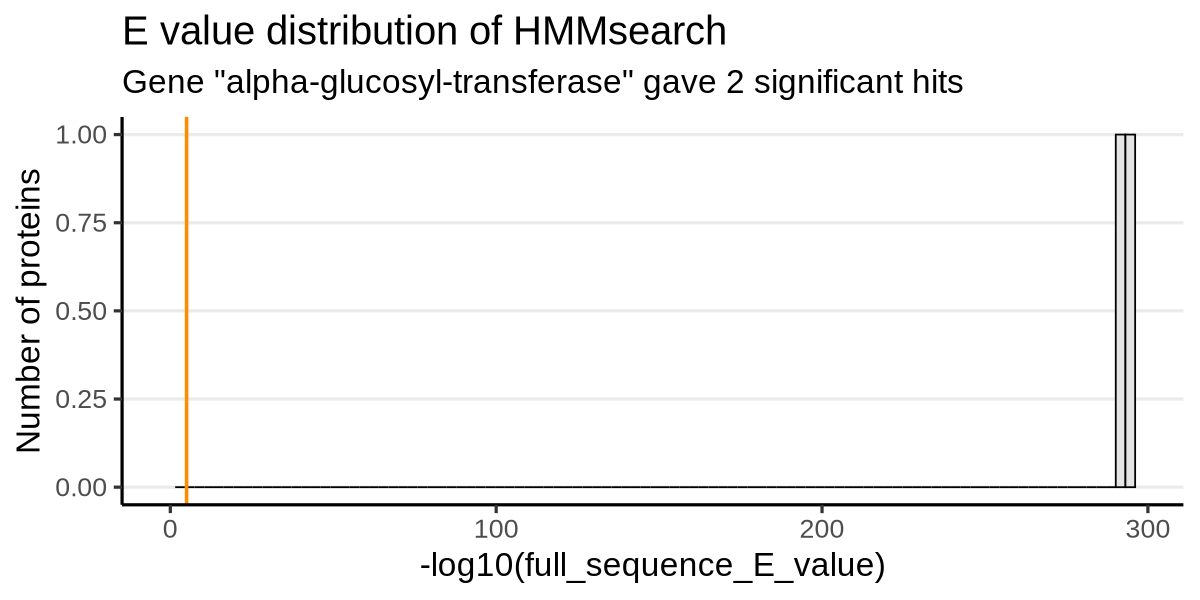

Warning message in dir.create(out_ann):
“'analysis/annotation' already exists”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`).”


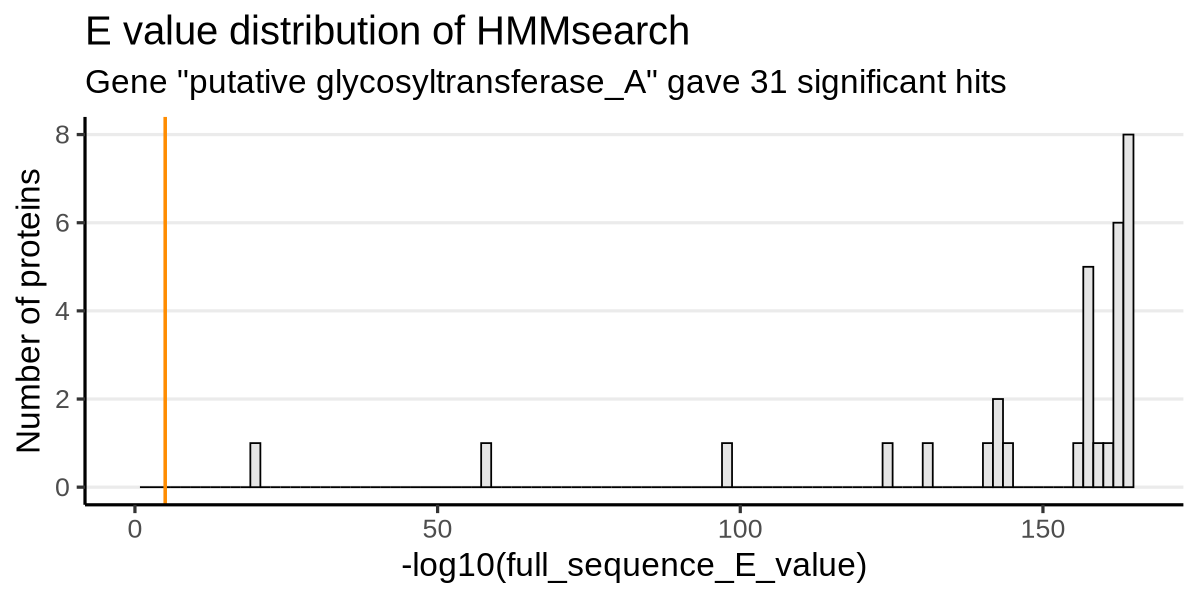

Warning message in dir.create(out_ann):
“'analysis/annotation' already exists”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`).”


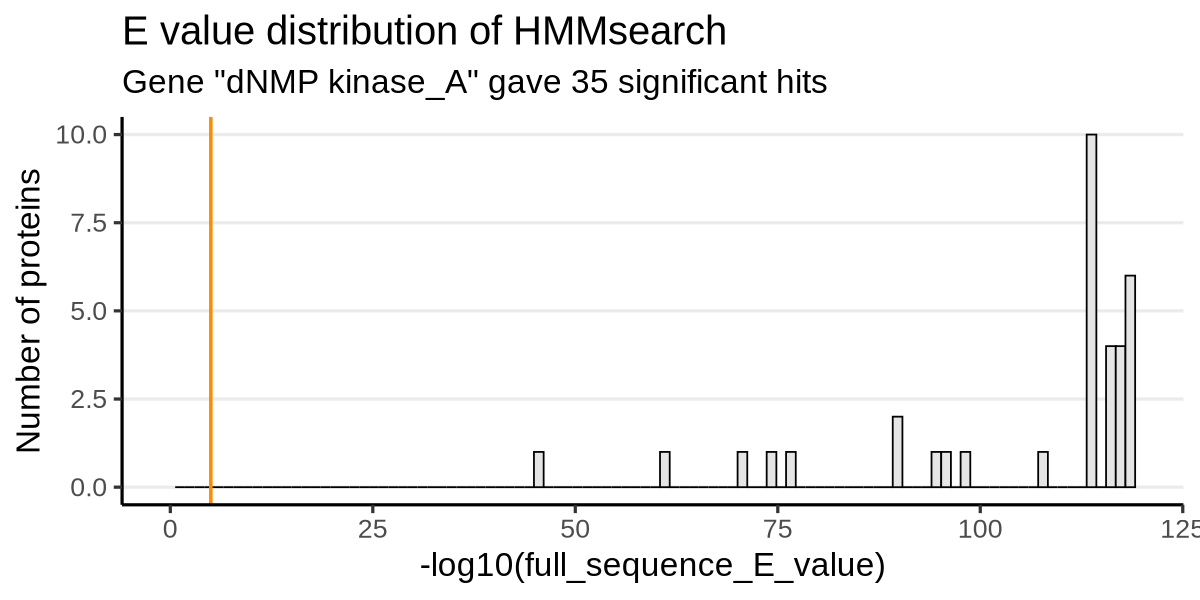

Warning message in dir.create(out_ann):
“'analysis/annotation' already exists”
Warning message in (function (..., deparse.level = 1, make.row.names = TRUE, stringsAsFactors = FALSE, :
“number of columns of result, 10, is not a multiple of vector length 4 of arg 59”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message:
“Removed 1 row containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 1 row contain

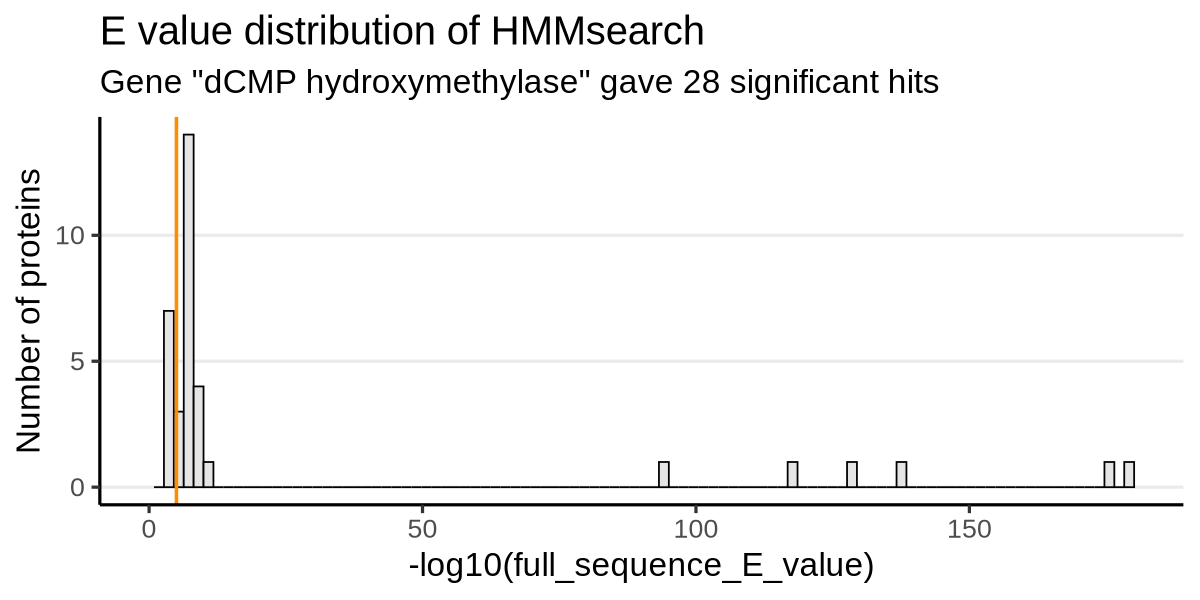

Warning message in dir.create(out_ann):
“'analysis/annotation' already exists”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`).”


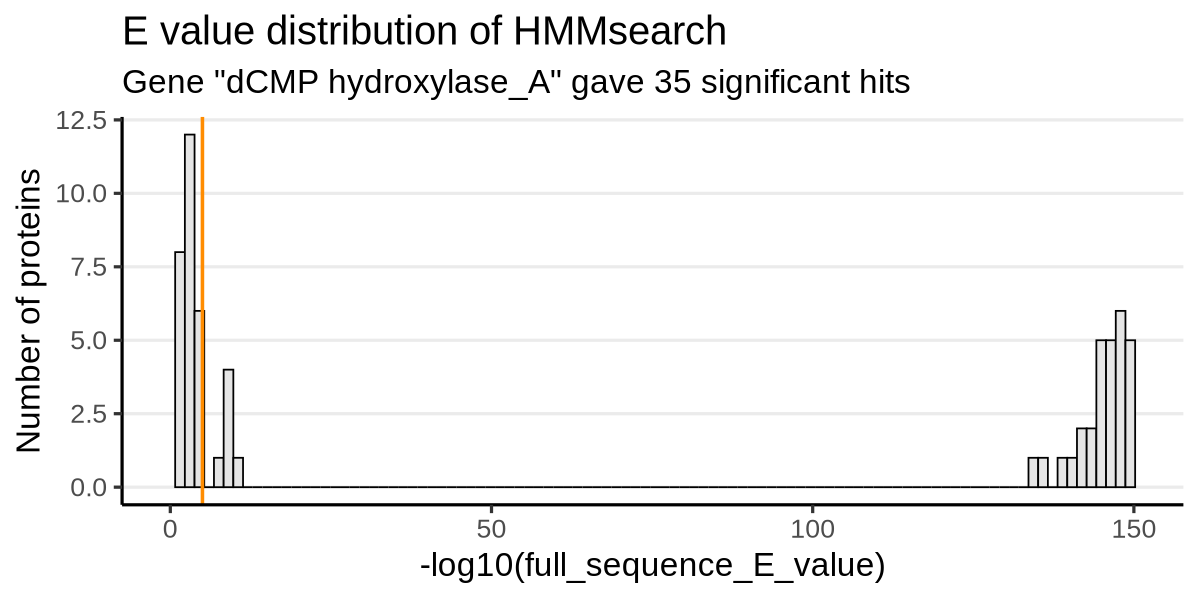

Warning message in dir.create(out_ann):
“'analysis/annotation' already exists”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`).”


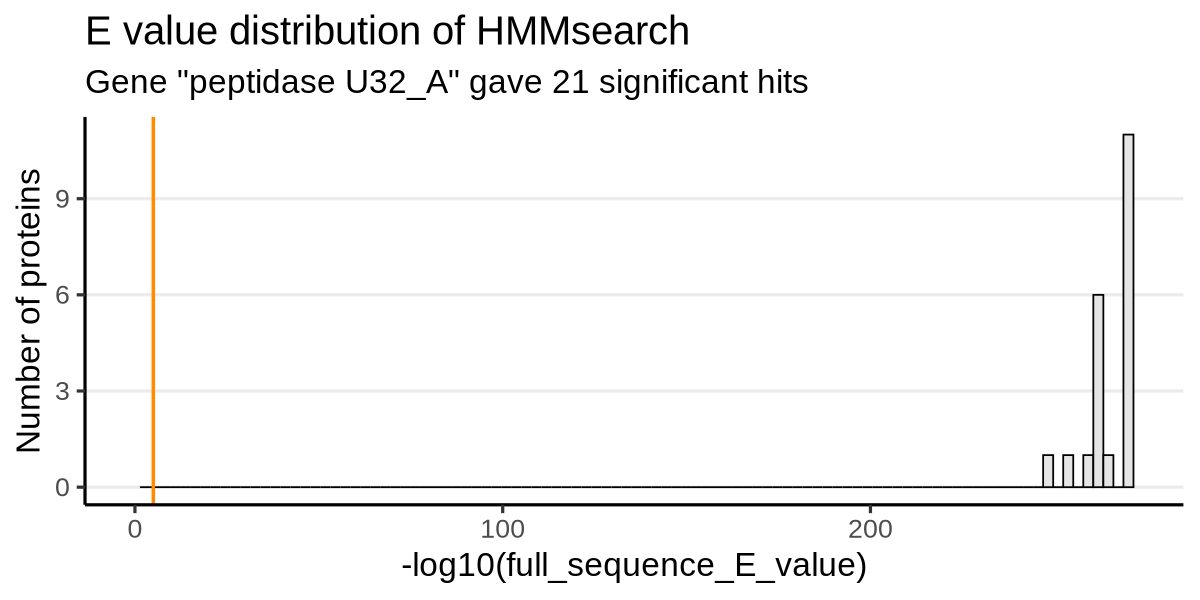

Warning message in dir.create(out_ann):
“'analysis/annotation' already exists”
Warning message:
“Removed 30 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`).”


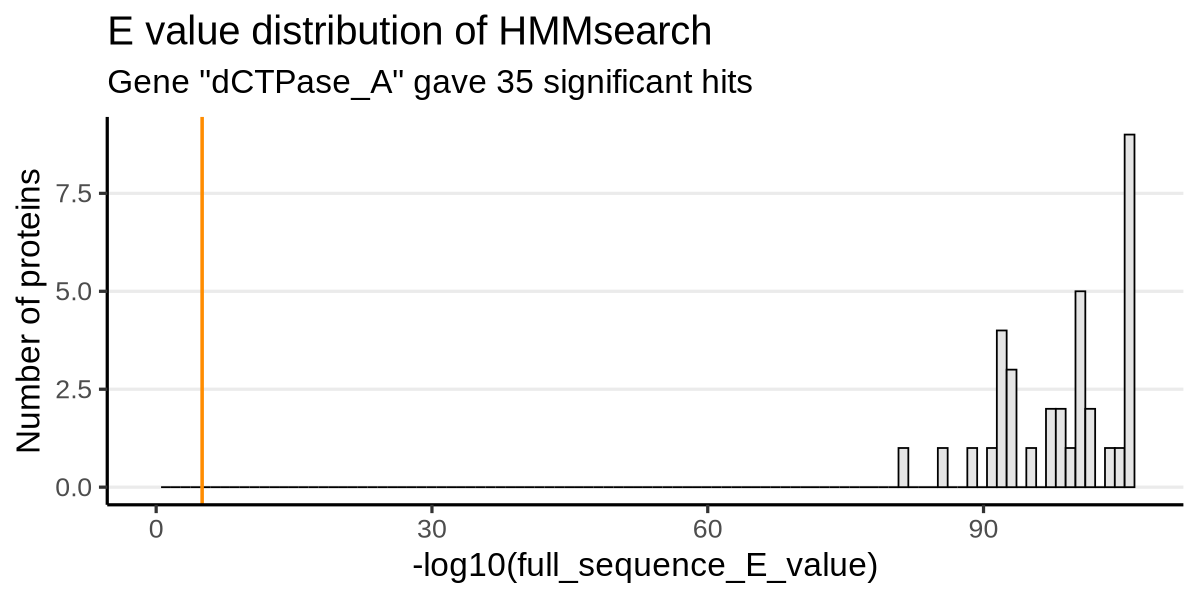

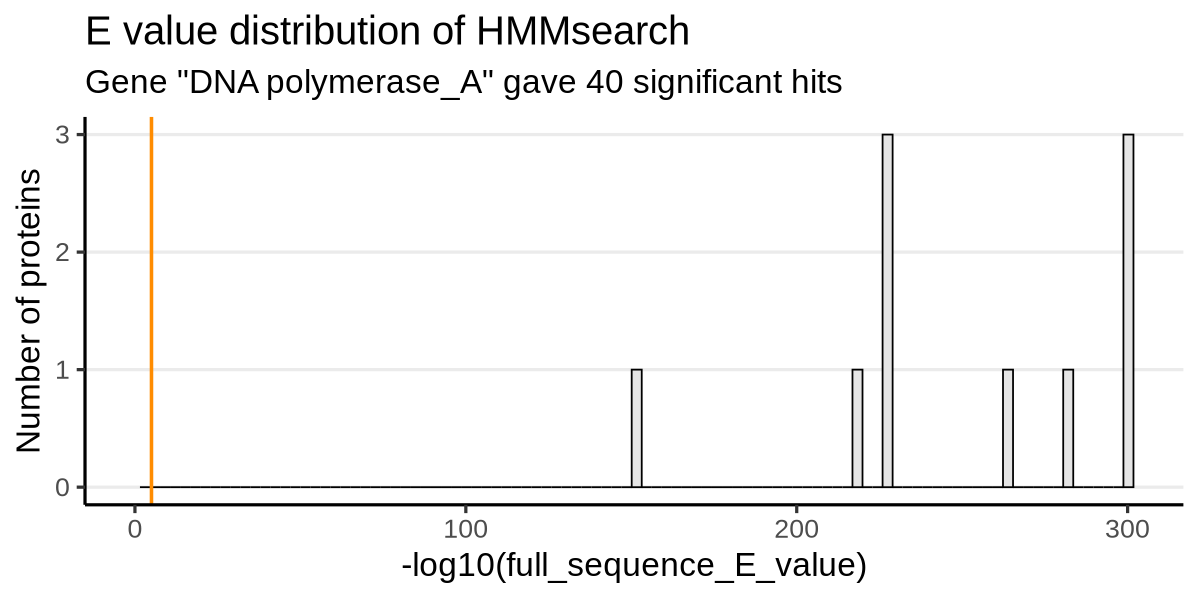

In [33]:
# Refine annotations
options(repr.plot.width=10, repr.plot.height=5)

genes <- levels(data$ann_level_2)
genes <- genes[genes != 'Other']
genes <- rev(genes)
genes

## Check spelling
all(genes %in% levels(data$ann_level_2))

## Iterate annotation over genes
pred <- list()
for (gene in genes) {
    pred[[gene]] <- annotate_gene_by_hmm_profile(
        data, annotation = 'ann_level_2', gene = gene, 
        search_db = fs$training$protein, 
        e_value_treshold = 1e-5, dir = out_annotation
    )
    pred[[gene]]$annotation <- gene
}

In [34]:
## Pool
result <- do.call('rbind', pred) %>% select(Sequence, annotation, full_sequence_E_value)
result <- pivot_wider(result, names_from = Sequence, values_from = full_sequence_E_value, values_fill = 1)
result <- result %>% as.data.frame()
row.names(result) <- result$annotation
result <- result[,-1]
result[result == 0] <- 1e-300

Adding missing grouping variables: `Accession`


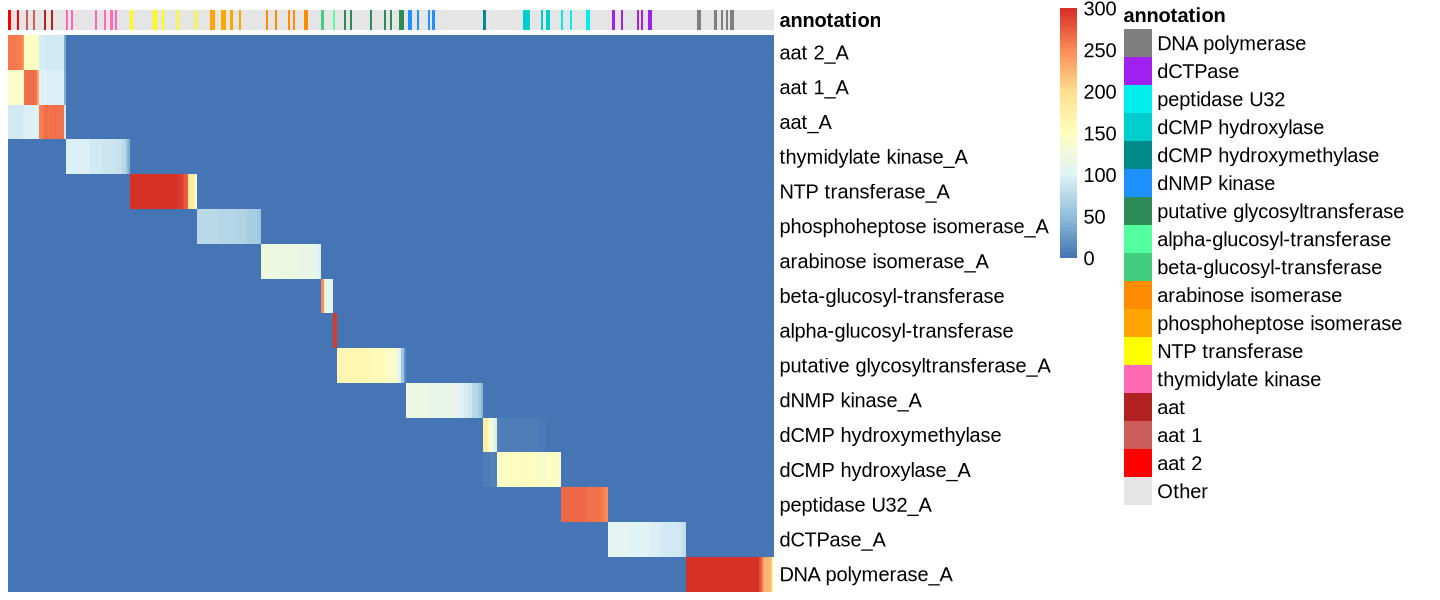

In [35]:
options(repr.plot.width=12, repr.plot.height=5)

## Column annotation
index <- match(colnames(result), data$Gene.CDS.Protein.FASTA.Sequence.ID)
cann <- data[index,] %>% select(Gene.CDS.Protein.FASTA.Sequence.ID, annotation) %>% as.data.frame()
rownames(cann) <- cann$Gene.CDS.Protein.FASTA.Sequence.ID
cann <- cann %>% select(annotation)

## Plot
pheatmap(
    -log10(result), 
    cluster_cols = FALSE, cluster_rows = FALSE,
    annotation_col = cann, annotation_colors = cols,
    show_colnames=FALSE,
    fontsize=12
)

In [36]:
## Vote
lookup <- character(length = ncol(result))
for (n in 1:ncol(result)) {
    v <- result[,n]
    names(v) <- str_split(rownames(result), '_', simplify = TRUE)[,1]
    n_min <- min(v)
    lookup[[n]] <- unique(names(which(v == min(v))))
}
index <- match(colnames(result), data$Gene.CDS.Protein.FASTA.Sequence.ID)
data$annotation[index] <- lookup

In [37]:
# Manually re-name putative glucosyltransferase
index <- data$modification == 'glucose' & data$annotation == 'putative glycosyltransferase'
data$Name[index]
data$annotation[index]
data$annotation[index] <- 'alpha-glucosyl-transferase'

[1] "Serratia phage PS2"

[1] putative glycosyltransferase
17 Levels: DNA polymerase dCTPase peptidase U32 ... Other

Warning message:
“Removed 223 rows containing missing values or values outside the scale range
(`geom_gene_arrow()`).”


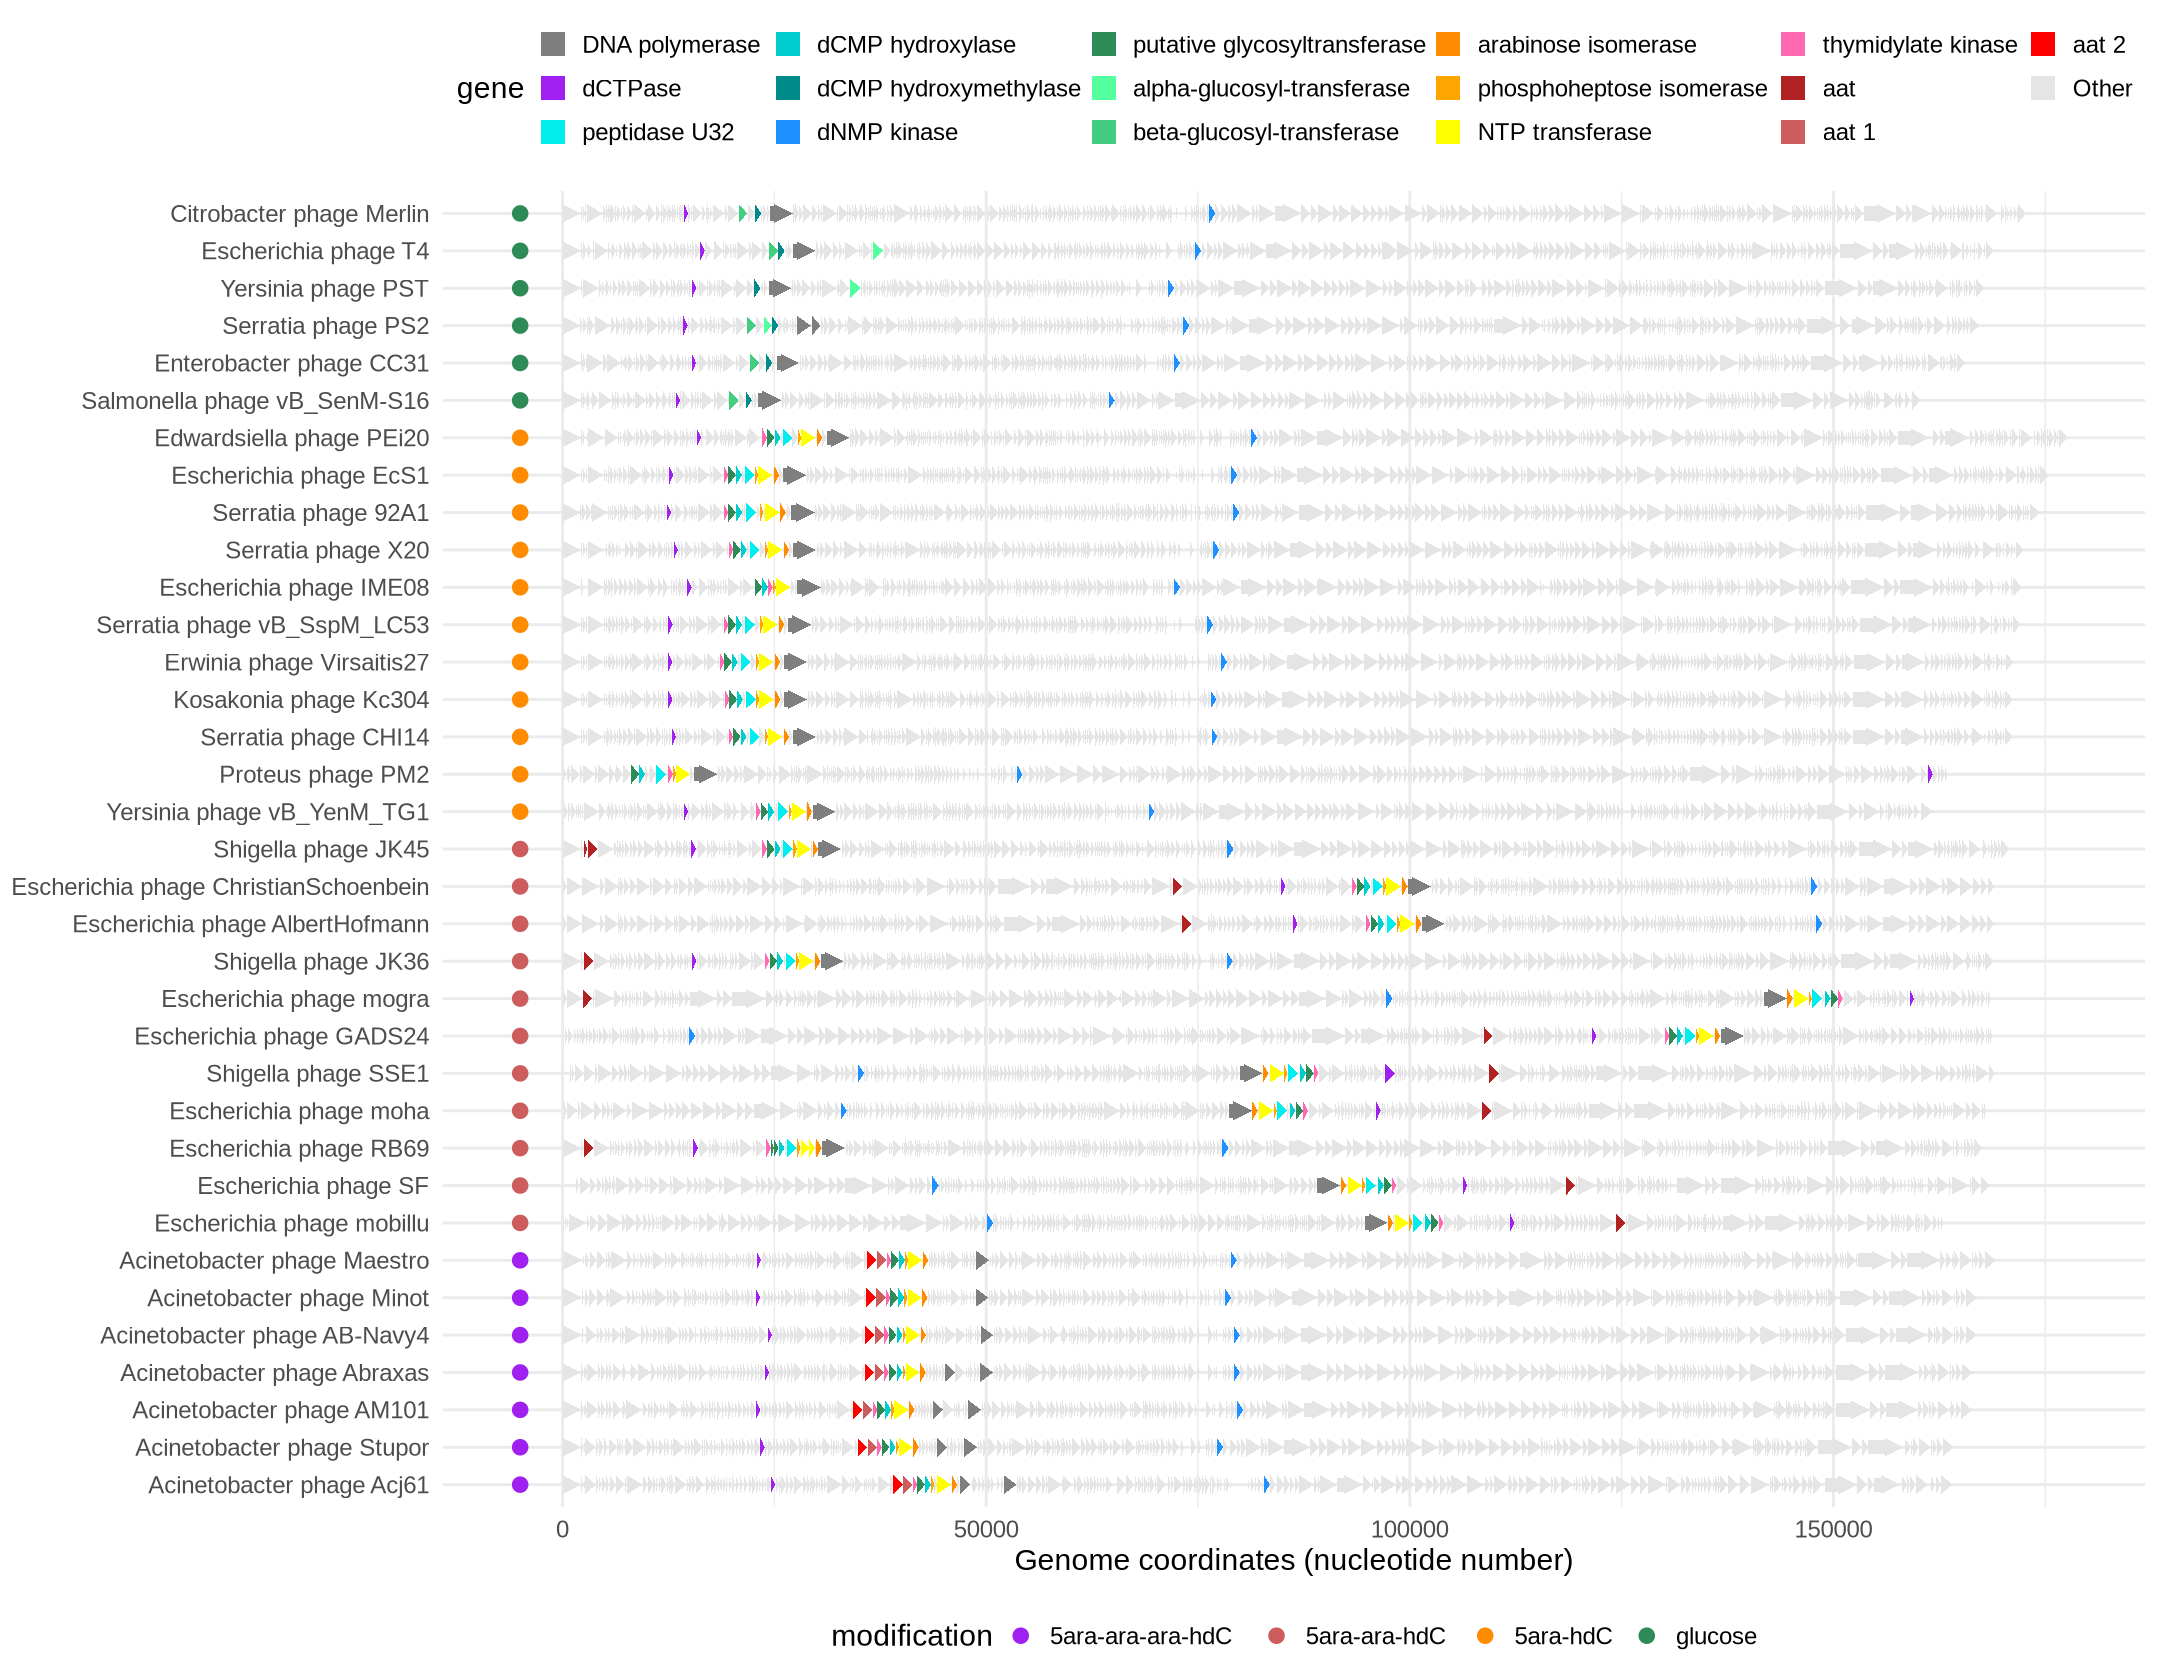

In [38]:
# Visualize genomes
options(repr.plot.width=18, repr.plot.height=14)

## Fetch data
df <- data

## Create annotations
ann <- df %>% select(Accession, modification, aat, Name) %>% unique()

## Order
df <- df[order(df$modification, df$genomeSize), ]
df$Name <- factor(df$Name, unique(df$Name))

# Plot
ggplot(df) +
    geom_gene_arrow(aes(
        xmin = Gene.CDS.Nucleotide.FASTA.Range.Start, xmax = Gene.CDS.Nucleotide.FASTA.Range.Stop, 
        y = Name, fill = annotation), col=NA
                   ) +
    scale_fill_manual(values = cols$annotation) +
    scale_color_manual(values = cols$modification) +
    geom_point(data=ann, aes(x=-5000, y=Name, col=modification), size=4) +
    theme_minimal(18) +
    guides(fill = guide_legend(position = 'top', nrow=3), 
           col = guide_legend(position = 'bottom', nrow=1)
          ) +
    labs(x = "Genome coordinates (nucleotide number)", y = NULL, fill='gene')

In [39]:
# Save training features
fn <- paste0(out_path,'training_features','.Rds')
saveRDS(data, fn)

`summarise()` has grouped output by 'Accession'. You can override using the
`.groups` argument.


< table of extent 0 >


5ara-ara-ara-hdC     5ara-ara-hdC         5ara-hdC          glucose 
               7               11               11                6 

[1] "DNA polymerase"               "dCTPase"                     
 [3] "peptidase U32"                "dCMP hydroxylase"            
 [5] "dCMP hydroxymethylase"        "dNMP kinase"                 
 [7] "putative glycosyltransferase" "alpha-glucosyl-transferase"  
 [9] "beta-glucosyl-transferase"    "arabinose isomerase"         
[11] "phosphoheptose isomerase"     "NTP transferase"             
[13] "thymidylate kinase"           "aat"                         
[15] "aat 1"                        "aat 2"                       
[17] "Other"

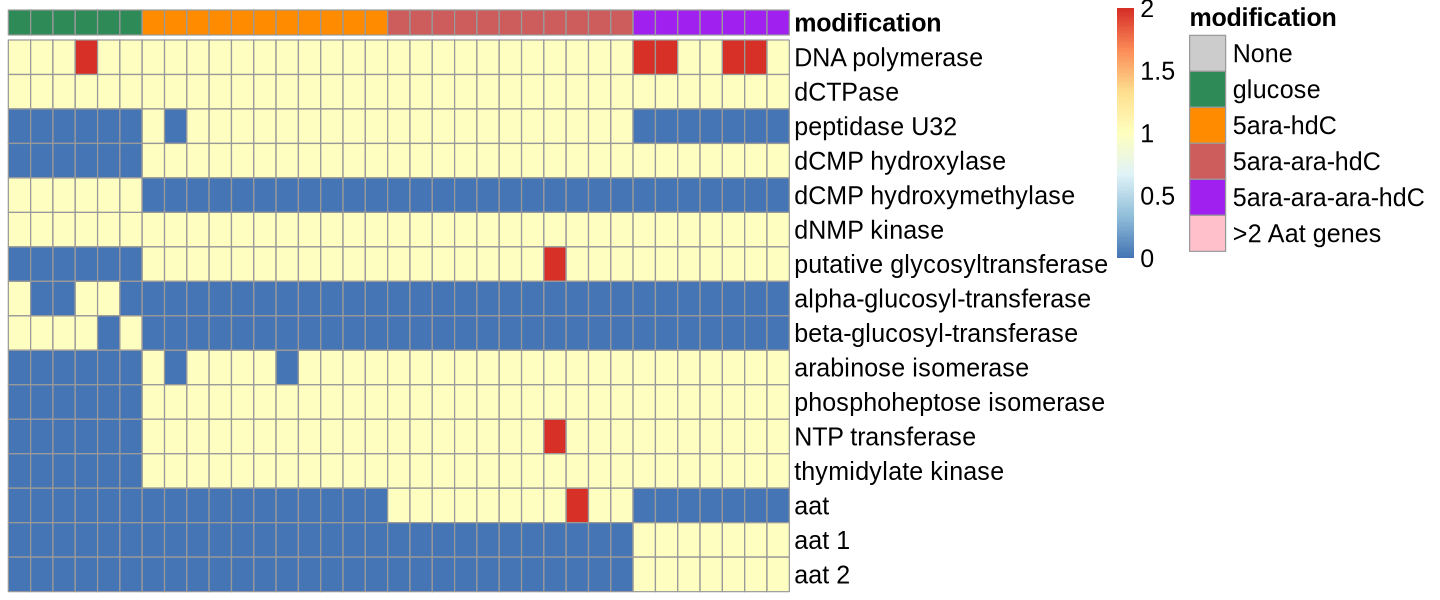

In [40]:
# Feature quantification
options(repr.plot.width=12, repr.plot.height=5)

heatmap_genes <- c('DNA pol','DNA clamp','NTP transfer','Thy syn','dCTPase','Hydroxylase','Pep U32','dNMP kinase','Glu transfer',
                   'Ara iso','pHep iso','Thy kin','Aat')
heatmap_genes <- levels(data$annotation)
heatmap_genes <- heatmap_genes[heatmap_genes != 'Other']

## Summarize gene counts
df <- data %>% mutate(N=1) %>% group_by(Accession, annotation) %>% summarize(total = sum(N))

## Filter
index <- df$annotation %in% heatmap_genes
df <- df[index,]

## Reshape
mat <- df %>% pivot_wider(names_from = Accession, values_from = total, values_fill = 0) %>% as.data.frame()
rownames(mat) <- mat$annotation
mat <- mat[heatmap_genes, -1] %>% as.matrix()

### Row
rann <- data.frame(
    row.names = rownames(mat)#, group = c('Generic','Generic','Generic','Glucosylation','Arabinosylation','Arabinosylation','Generic','Generic','Arabinosylation','Arabinosylation','Arabinosylation')
)
#rann$group <- factor(rann$group, names(cols$group))

### Col
index <- match(colnames(mat), data$Accession)
cann <- data.frame(
    row.names = colnames(mat),
    modification = data$modification[index]
)

##  Cluster

### Level 1
cann$group <- 'None'
cann$group[mat['dCTPase',] > 0] <- 'Generic'
cann$group[cann$group == 'Generic' & mat['dCMP hydroxymethylase',] > 0] <- 'Glucosylation'
cann$group[cann$group == 'Generic' & mat['phosphoheptose isomerase',] > 0] <- 'Arabinosylation'
cann$group <- factor(cann$group, names(cols$group))
cann$group <- NULL

### Level 2
#cann$modification <- 'none'
#cann$modification[cann$group == 'Glucosylation'] <- 'glucose'
#cann$modification[cann$group == 'Arabinosylation' & mat['aat',]==1] <- '5ara-hdC'
#cann$modification[cann$group == 'Arabinosylation' & mat['aat 1',]==1] <- '5ara-ara-hdC'
#cann$modification[cann$group == 'Arabinosylation' & mat['aat 2',]==1] <- '5ara-ara-ara-hdC'

## Order
#mat <- mat[,order(cann$group, cann$modification, decreasing = c(FALSE, TRUE), method = 'radix')]
mat <- mat[,order(cann$modification, decreasing = TRUE, method = 'radix')]

## Plot
p1 <- pheatmap(mat, 
               cluster_rows = FALSE, cluster_cols=FALSE,
               show_colnames=FALSE, annotation_colors=cols,
               annotation_col = cann,
               fontsize = 15,
               #gaps_col             = head(as.numeric(cumsum(table(cann$group)[table(cann$group) > 0])), -1),
               #gaps_row             = head(as.numeric(cumsum(table(rann$group)[table(rann$group) > 0])), -1)
              )

## Quantify
table(cann$group)
table(cann$modification)
levels(data$annotation)

In [41]:
index <- data$Accession %in% names(which(mat['DNA polymerase',] > 1)) & data$annotation == 'DNA polymerase'
data[index, c('Name','Gene.CDS.Name')]

Name                        Gene.CDS.Name       
1  Acinetobacter phage Stupor  split DNA polymerase
2  Acinetobacter phage Stupor  split DNA polymerase
3  Acinetobacter phage Abraxas split DNA polymerase
4  Acinetobacter phage Abraxas split DNA polymerase
5  Acinetobacter phage Acj61   DNA polymerase      
6  Acinetobacter phage Acj61   DNA polymerase      
7  Serratia phage PS2          DNA polymerase      
8  Serratia phage PS2          DNA polymerase      
9  Acinetobacter phage AM101   DNA polymerase      
10 Acinetobacter phage AM101   DNA polymerase

In [42]:
index <- data$Accession %in% names(which(mat['aat',] > 1)) & data$annotation == 'aat'
data[index, c('Name','Gene.CDS.Name','Gene.CDS.Protein.FASTA.Sequence.ID')]

Name                Gene.CDS.Name        Gene.CDS.Protein.FASTA.Sequence.ID
1 Shigella phage JK45 hypothetical protein YP_010076081.1:1-136              
2 Shigella phage JK45 hypothetical protein YP_010076082.1:1-366

use default substitution matrix
use default substitution matrix


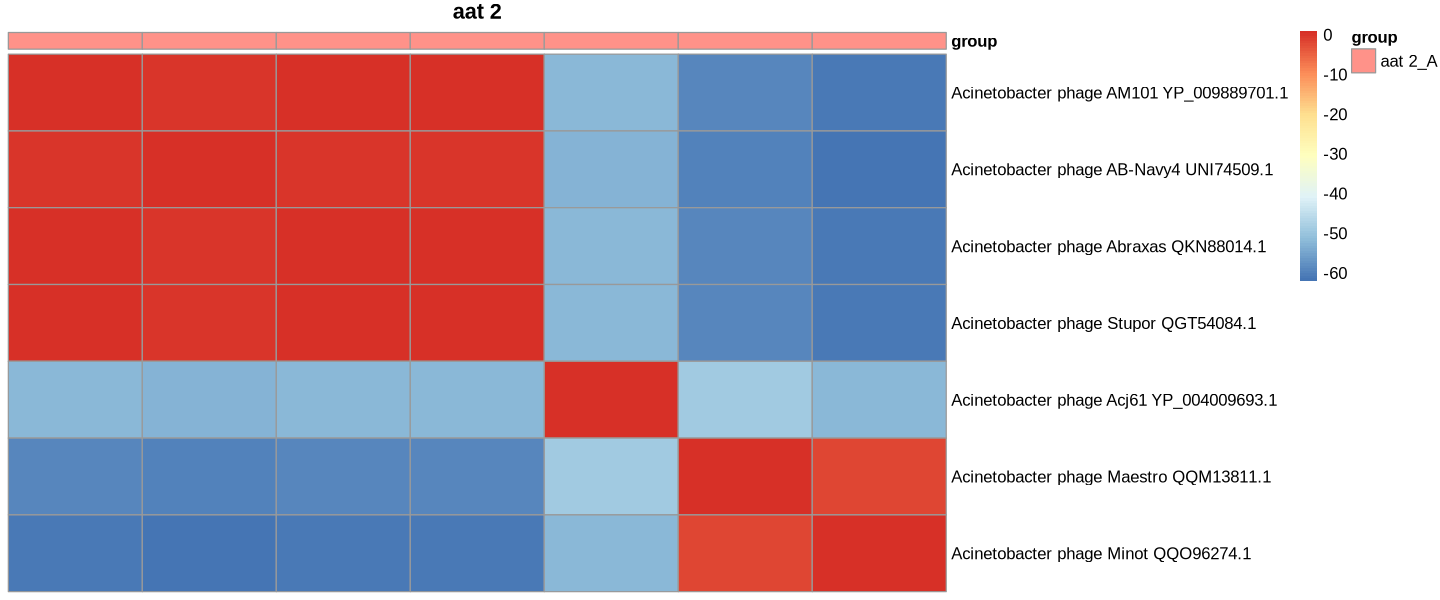

use default substitution matrix


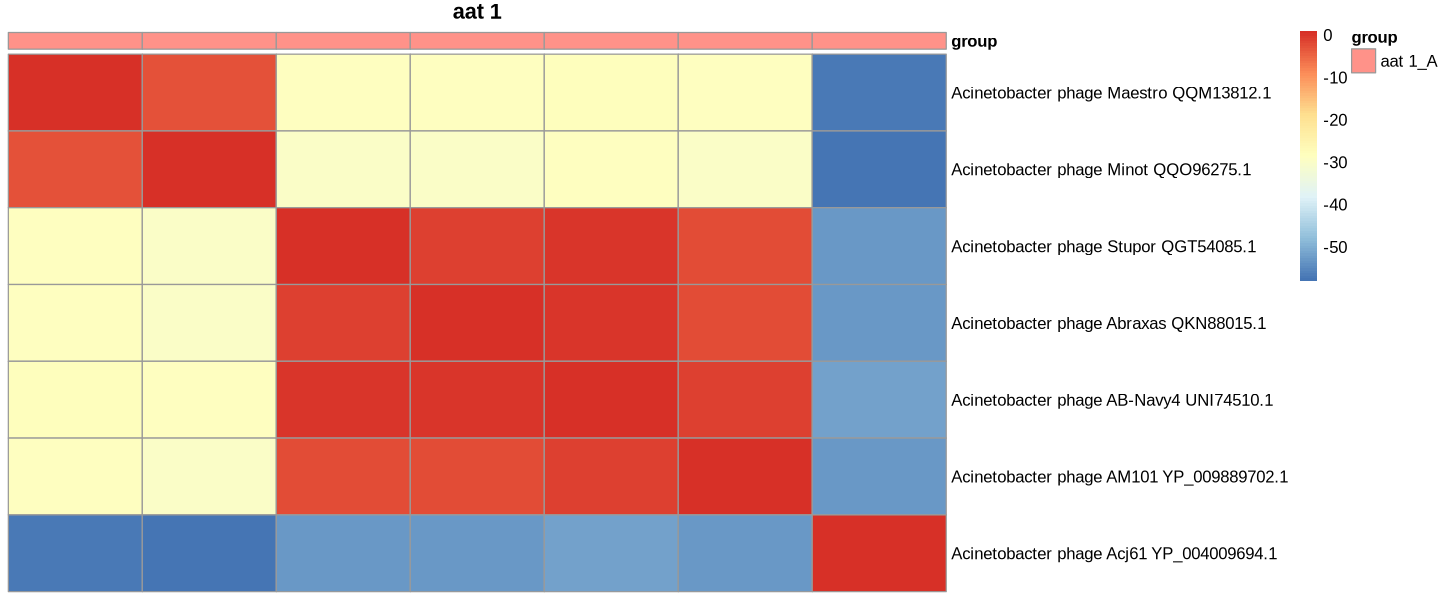

use default substitution matrix


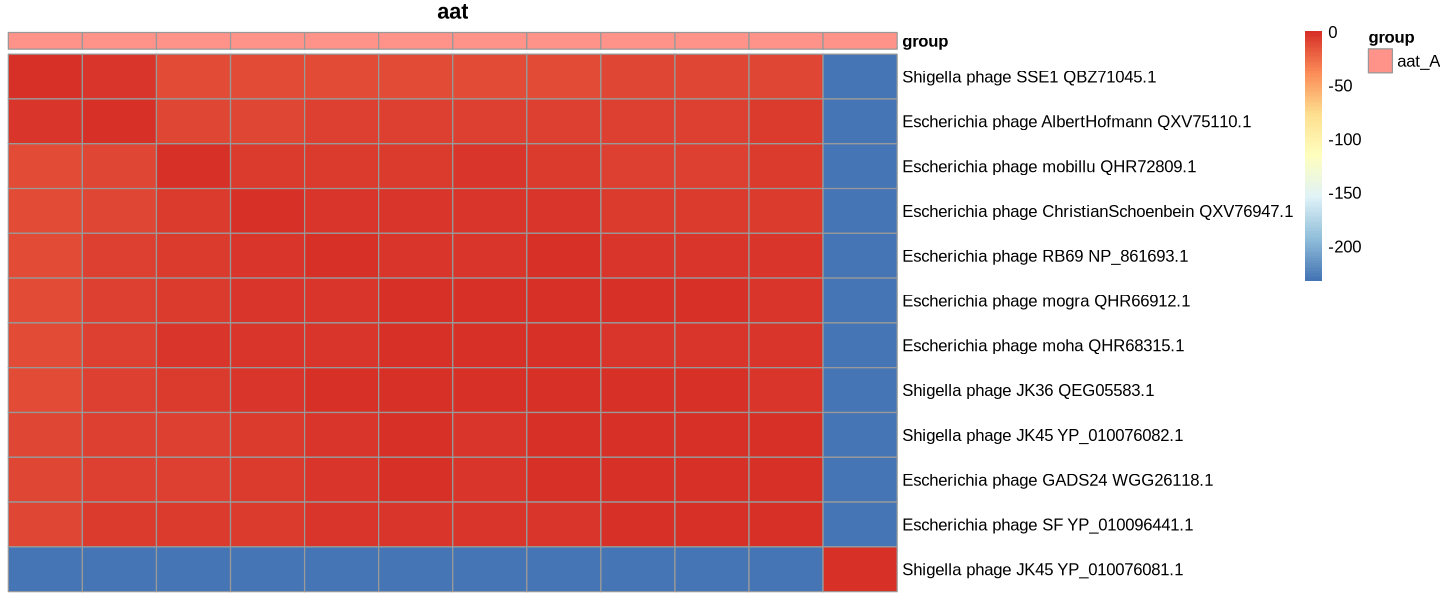

use default substitution matrix


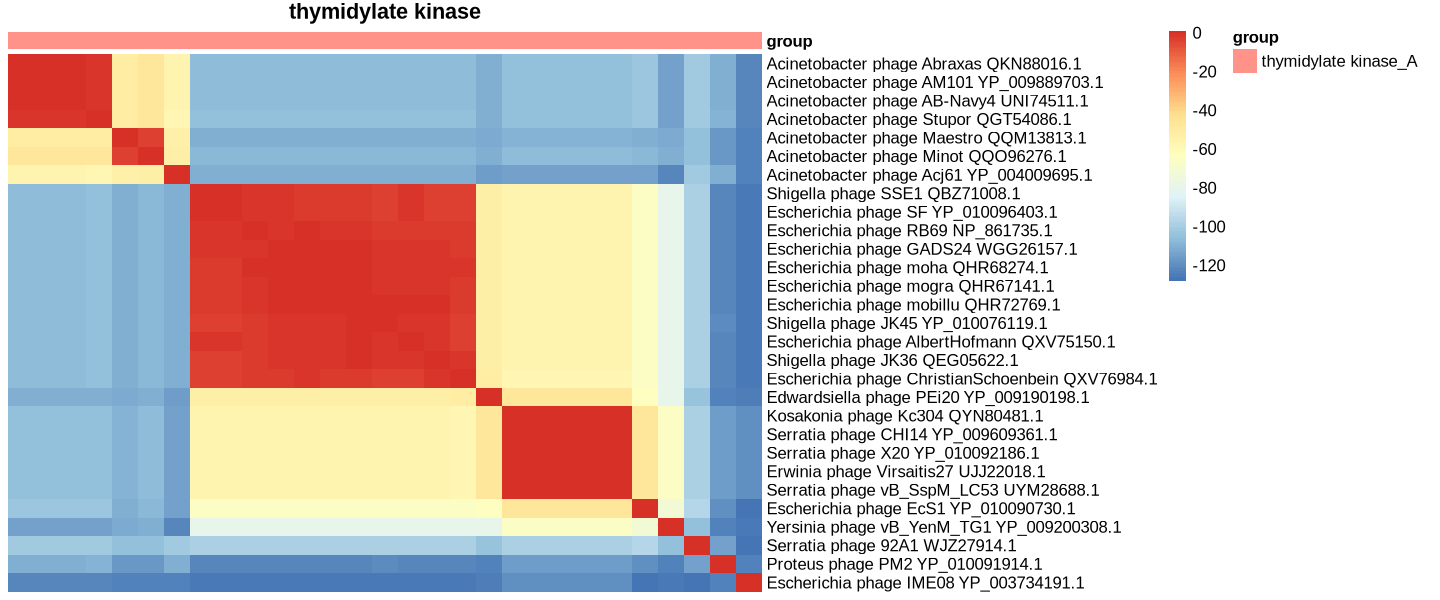

use default substitution matrix


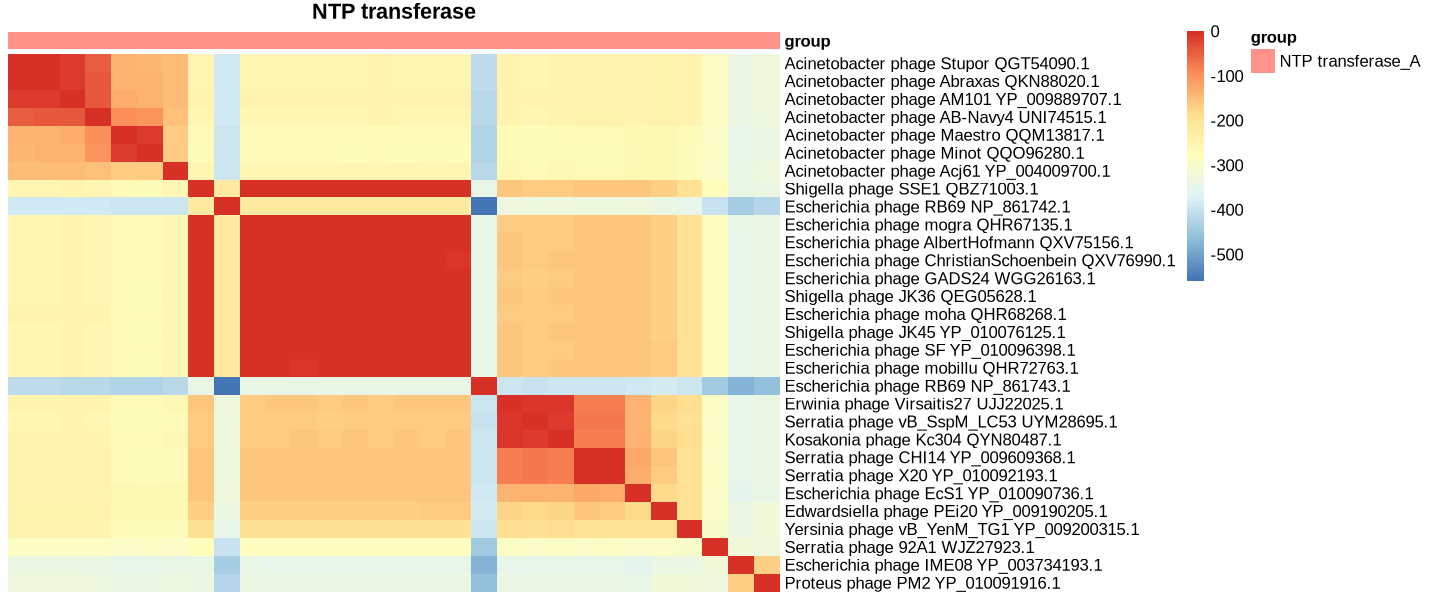

use default substitution matrix


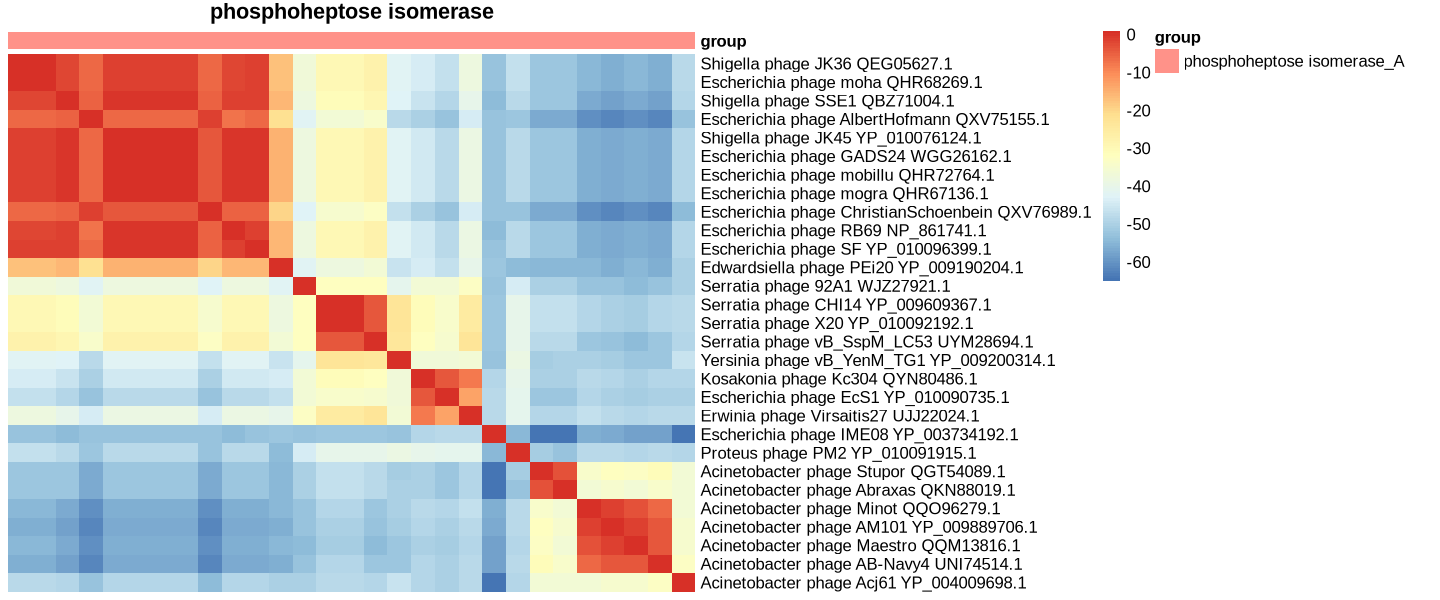

use default substitution matrix


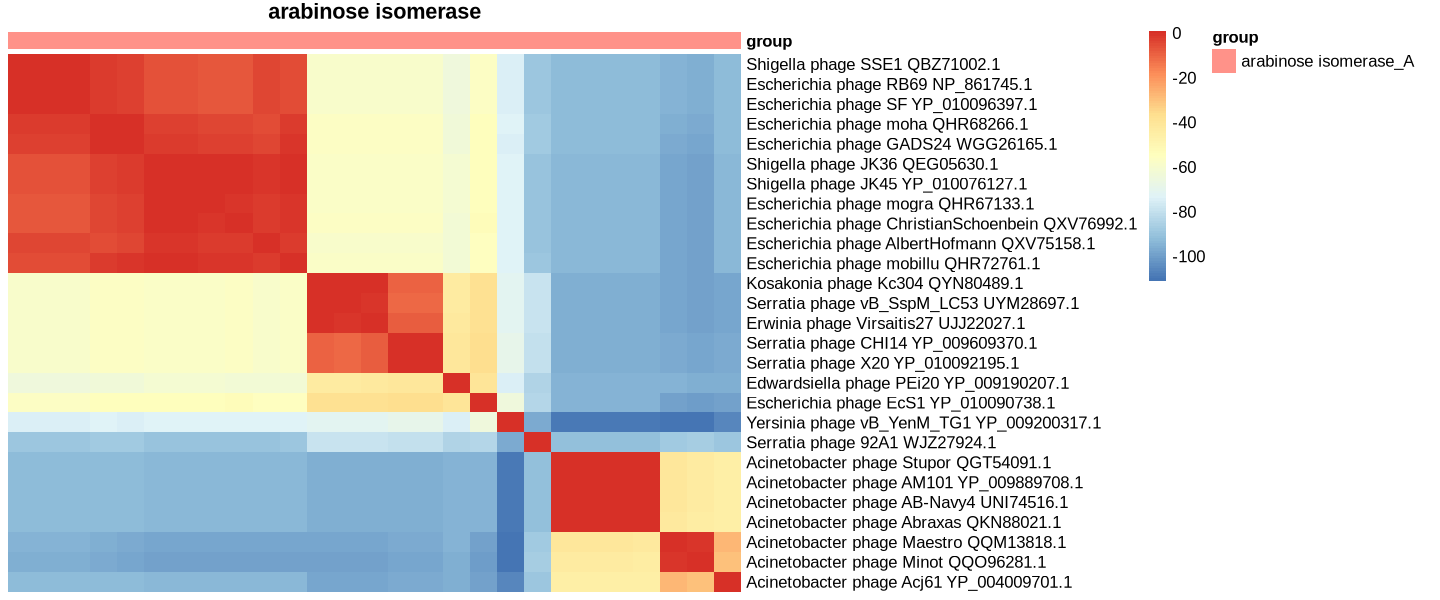

use default substitution matrix


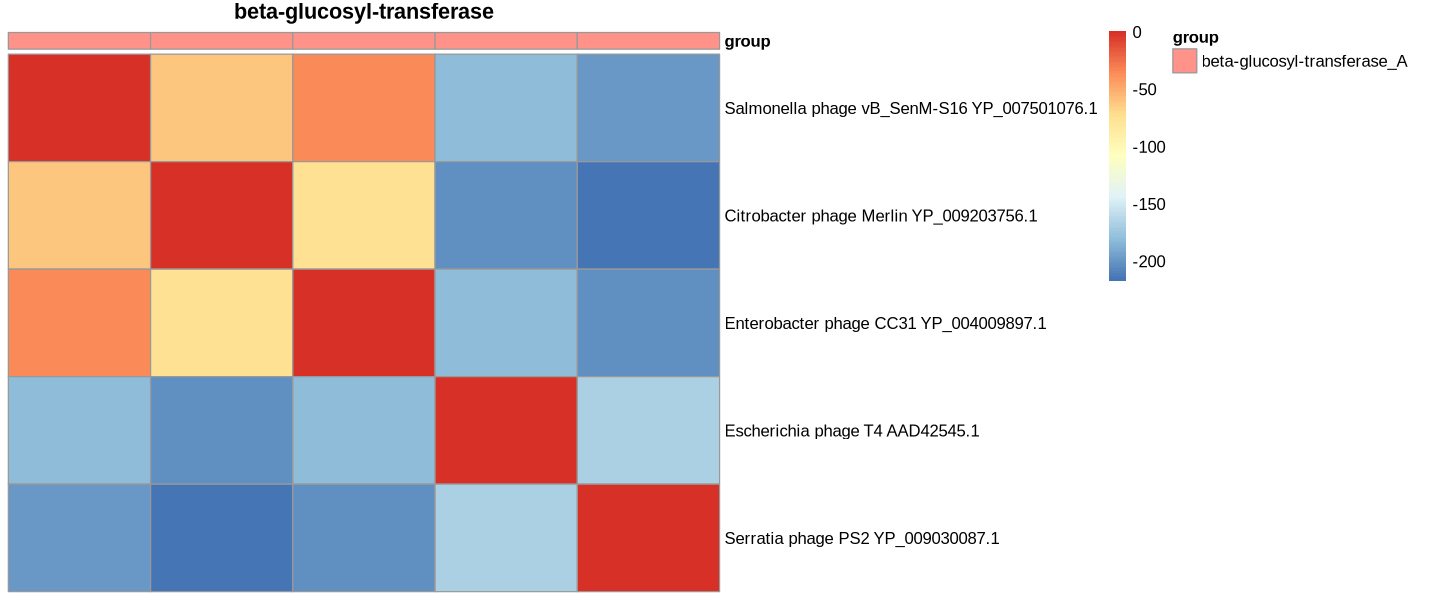

use default substitution matrix


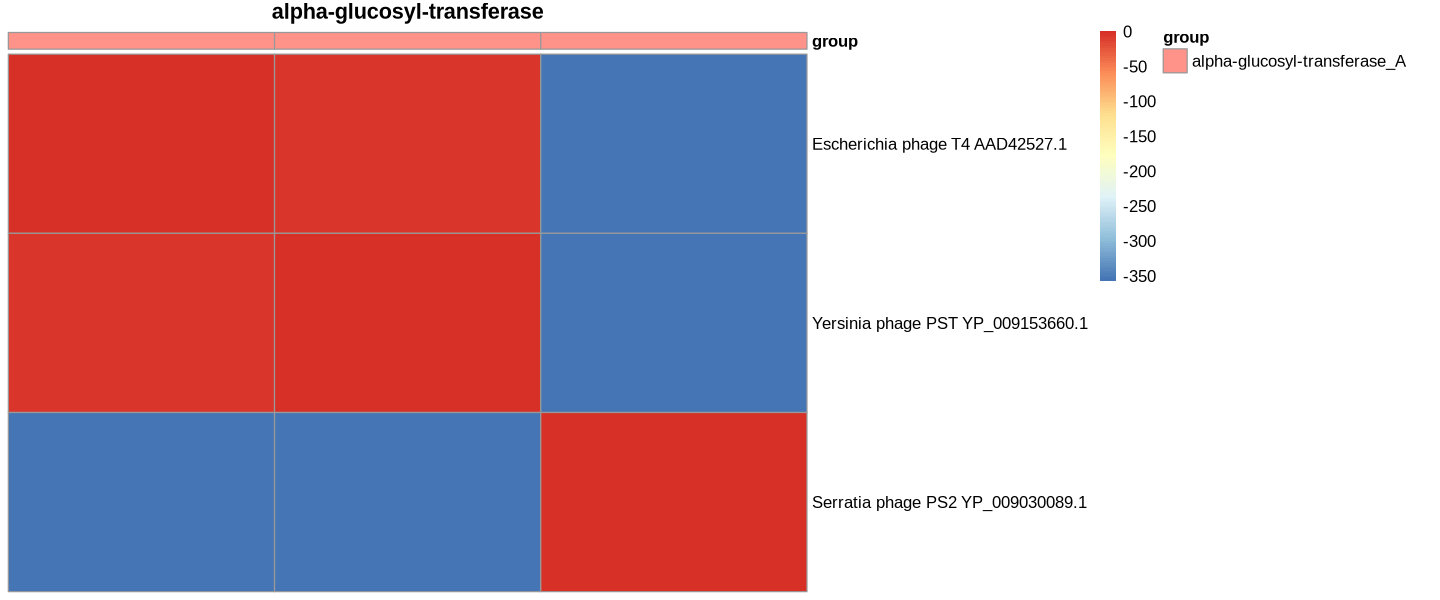

use default substitution matrix


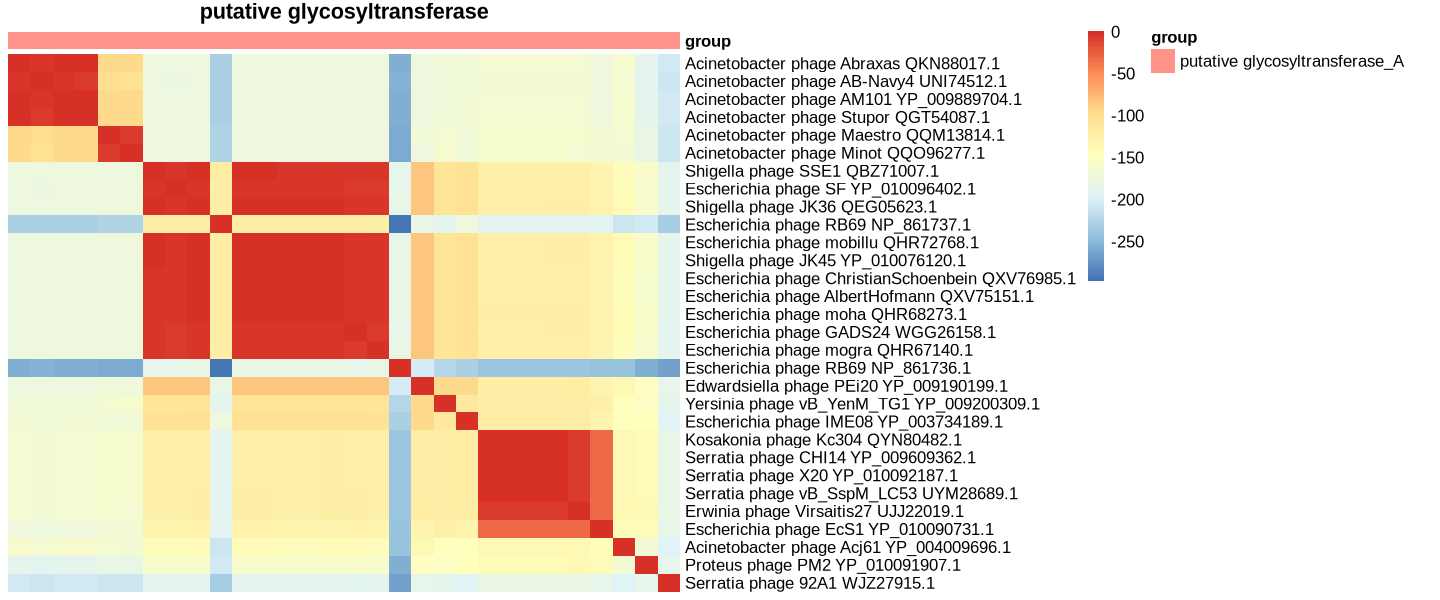

use default substitution matrix


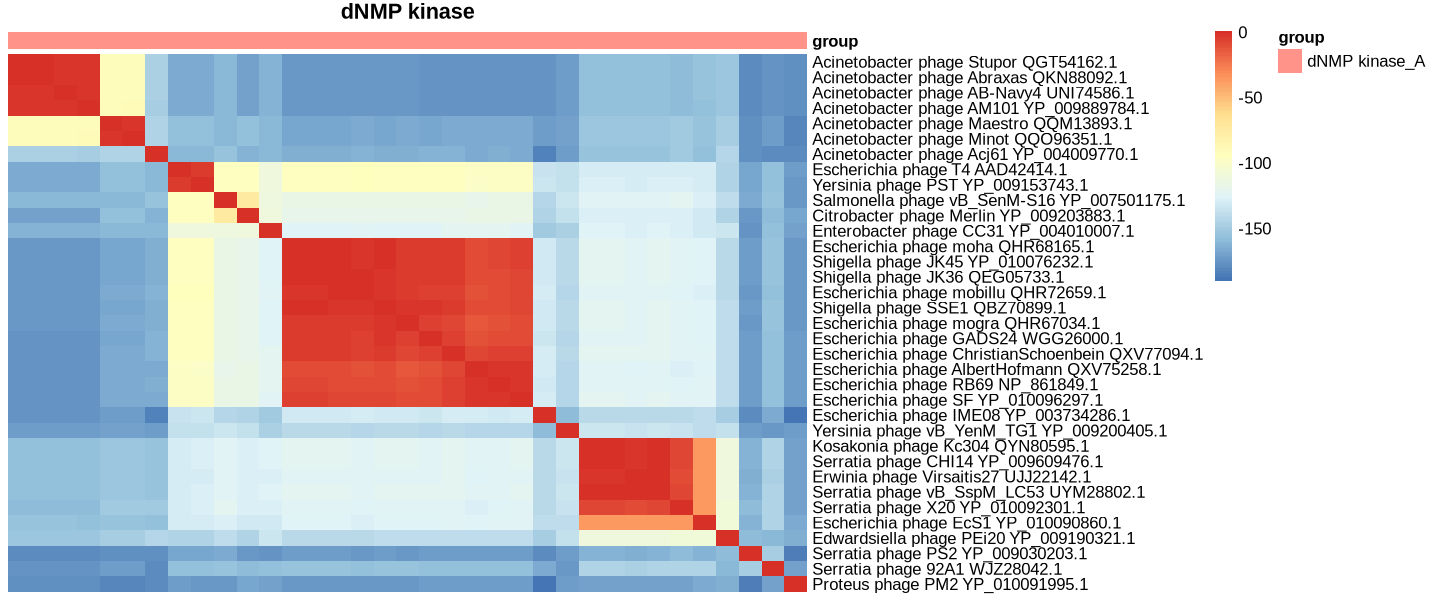

use default substitution matrix


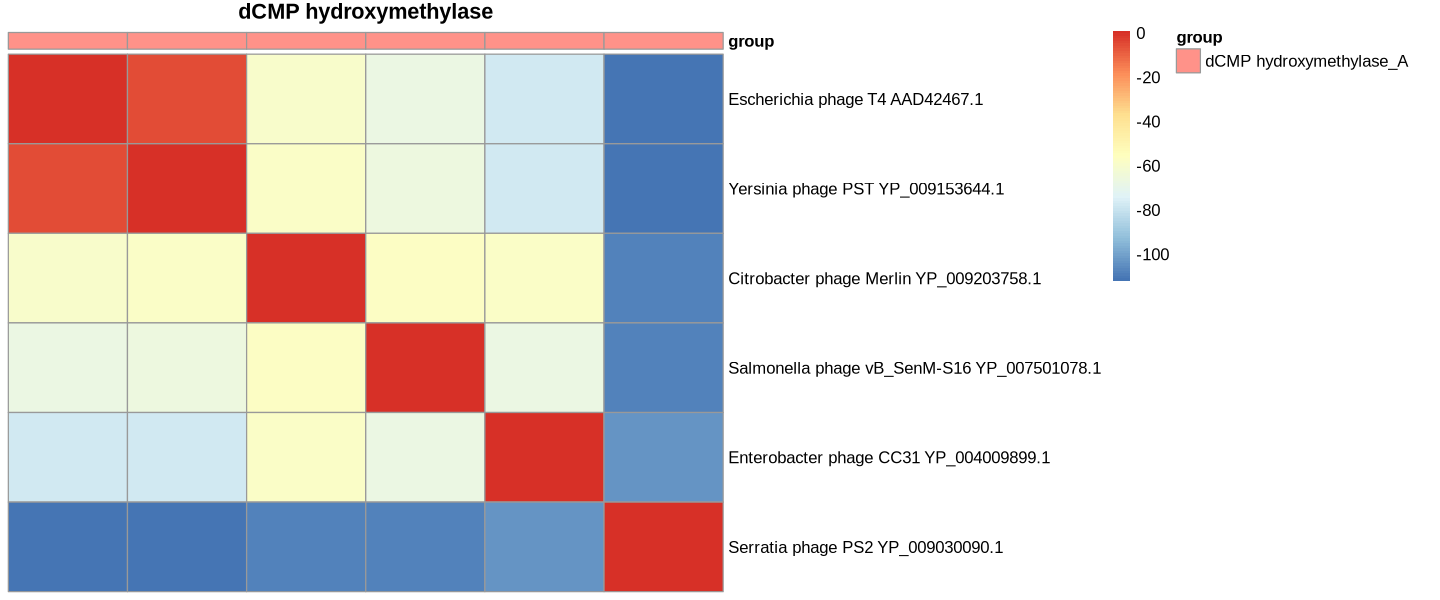

use default substitution matrix


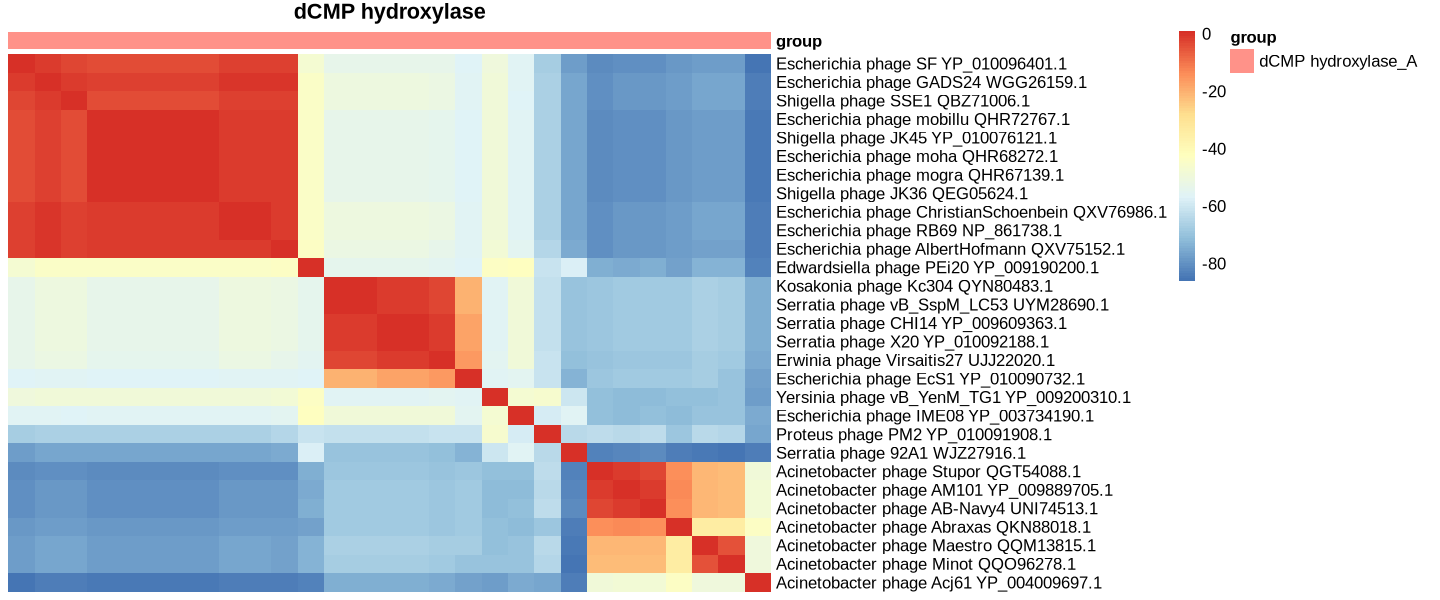

use default substitution matrix


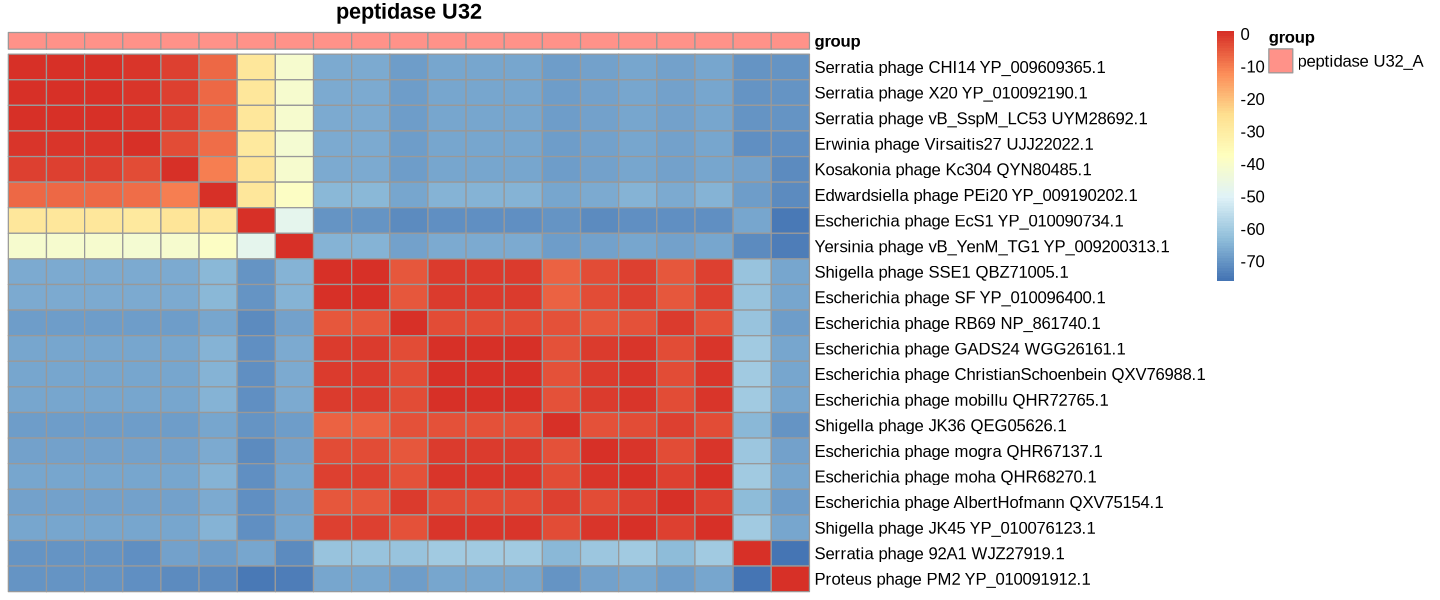

use default substitution matrix


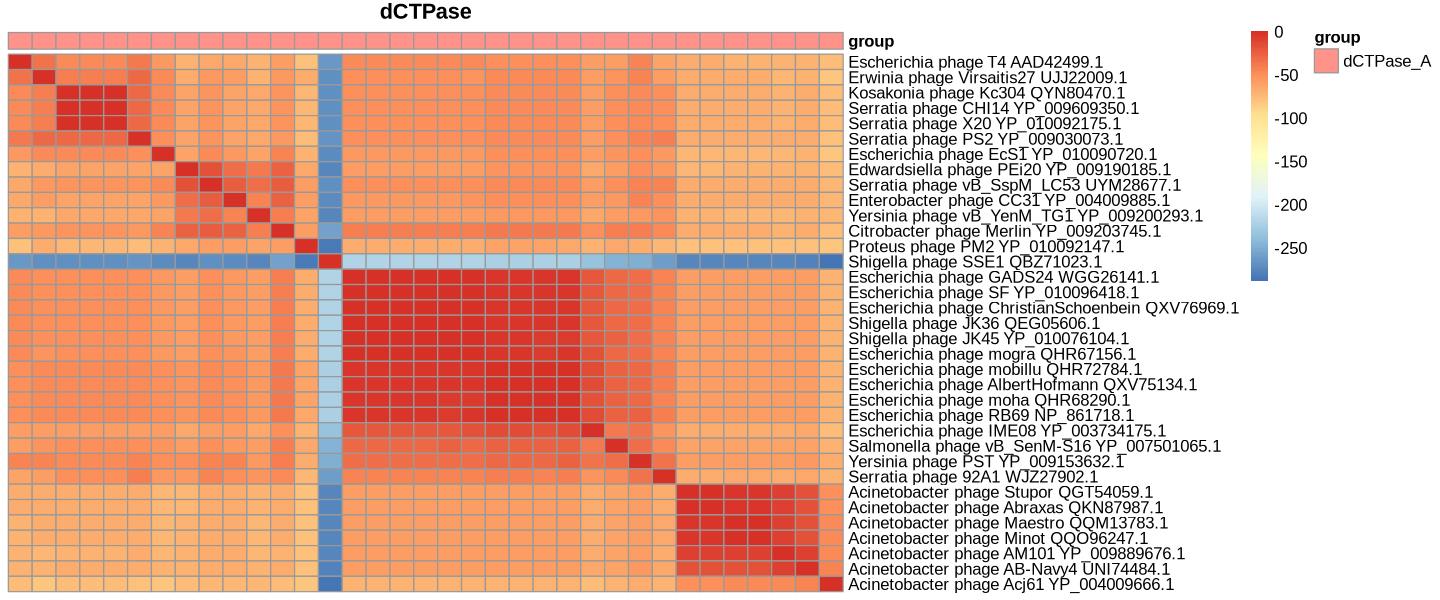

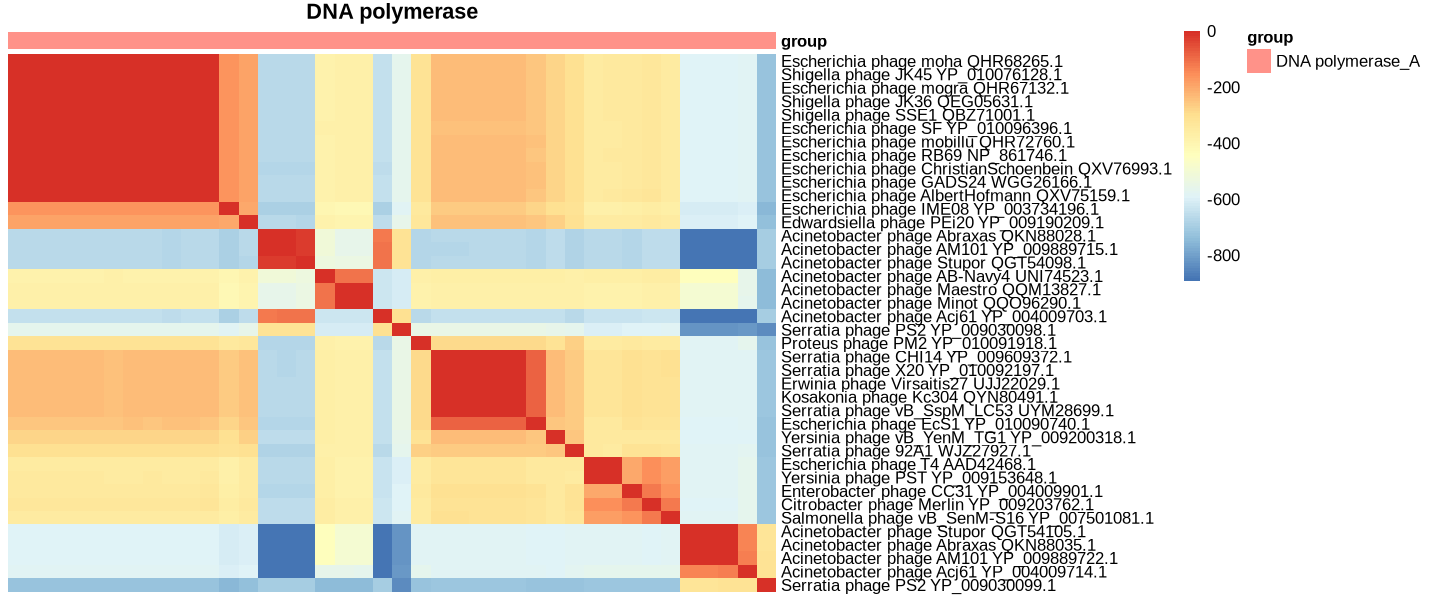

In [43]:
# Clean gene annotations
options(repr.plot.width=12, repr.plot.height=5)

## Variables
dist_threshold <- 1000
data$key <- paste(data$Name, data$Gene.CDS.Protein.FASTA.Accession)

## Set up ann_level_2
data$ann_level_2 <- 'Other'

## Fetch genes
genes <- levels(data$annotation)
genes <- genes[genes != 'Other']
genes <- rev(genes)

## Iterate over genes
for (i in genes) {
    index <- which(data$annotation == i)

    if (length(index) < 2) {
        data$ann_level_2[index] <- i
        next
    }
    
    ## MSA
    seq <- AAStringSet(data$protein_seq[index])
    names(seq) <- data$key[index]
    result <- msa(seq)
    result
    
    ## Distance matrix
    dist <- as.matrix(dist.gene(as.AAbin(result)))

    ## Split alignment to homogeneous groups
    x <- dist < dist_threshold
    x <- apply(x, 1, which, simplify = FALSE)
    x <- lapply(x, paste0, collapse='-')
    x <- unlist(x)
    lookup <- LETTERS[1:length(unique(x))]
    names(lookup) <- unique(x)

    ## Annotate groups
    cann <- data.frame(
        row.names = rownames(dist),
        group = paste(i, lookup[x], sep = '_')
    )

    ## Transfer annotation
    index <- match(rownames(cann), data$key)
    data$ann_level_2[index] <- cann$group
    
    ## Plot
    pheatmap(1-dist, 
             cluster_cols = FALSE, cluster_rows = FALSE,
             annotation_col = cann, show_colnames=FALSE,
             show_rownames = TRUE, labels_row = result@unmasked@ranges@NAMES, fontsize=10, main=i
            )
}

In [44]:
# Convert ann_level to factor
data$ann_level_2 <- factor(data$ann_level_2, unique(data$ann_level_2[order(data$annotation, decreasing = FALSE)]))
levels(data$ann_level_2)

[1] "DNA polymerase_A"               "dCTPase_A"                     
 [3] "peptidase U32_A"                "dCMP hydroxylase_A"            
 [5] "dCMP hydroxymethylase_A"        "dNMP kinase_A"                 
 [7] "putative glycosyltransferase_A" "alpha-glucosyl-transferase_A"  
 [9] "beta-glucosyl-transferase_A"    "arabinose isomerase_A"         
[11] "phosphoheptose isomerase_A"     "NTP transferase_A"             
[13] "thymidylate kinase_A"           "aat_A"                         
[15] "aat 1_A"                        "aat 2_A"                       
[17] "Other"

[1] TRUE

Warning message in system(sys_call, intern = TRUE):
“running command 'cat  data/training/ data/validation/ncbi_dataset/data/protein.faa data/test/ncbi_dataset/data/protein.faa data/test2/ncbi_dataset/data/protein.faa > analysis/protein.faa' had status 1”


character(0)
attr(,"status")
[1] 1
attr(,"errmsg")
[1] "Resource temporarily unavailable"

Warning message in dir.create(out_ann):
“'analysis/prediction' already exists”
Warning message in (function (..., deparse.level = 1, make.row.names = TRUE, stringsAsFactors = FALSE, :
“number of columns of result, 10, is not a multiple of vector length 4 of arg 277”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message:
“Removed 57 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 1 row cont

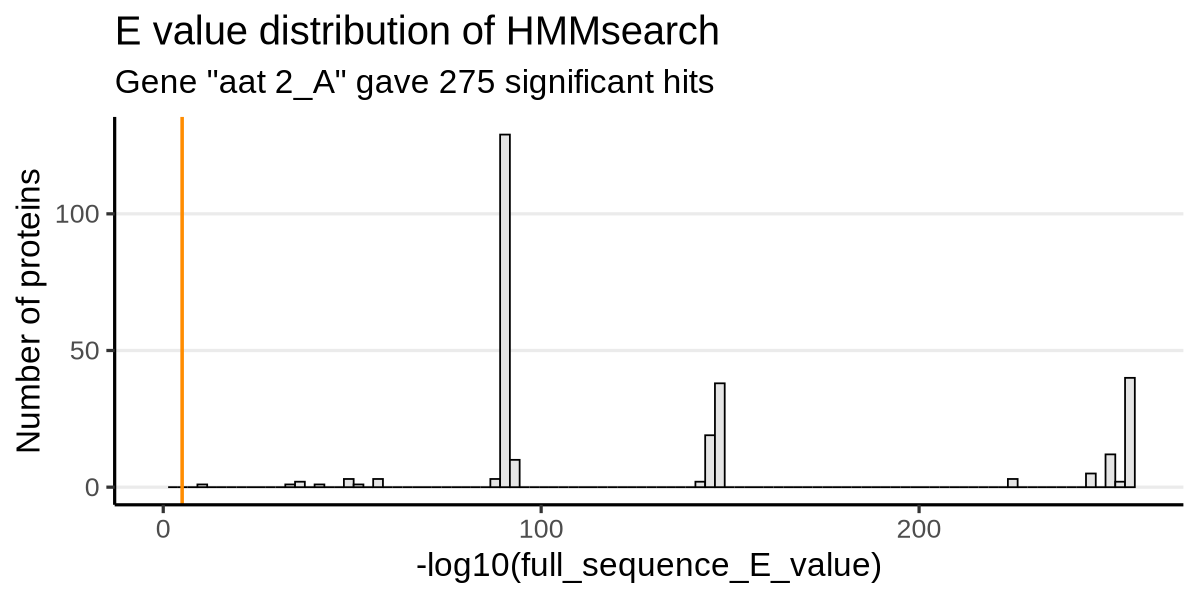

Warning message in dir.create(out_ann):
“'analysis/prediction' already exists”
Warning message in (function (..., deparse.level = 1, make.row.names = TRUE, stringsAsFactors = FALSE, :
“number of columns of result, 10, is not a multiple of vector length 4 of arg 277”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message:
“Removed 15 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 1 row cont

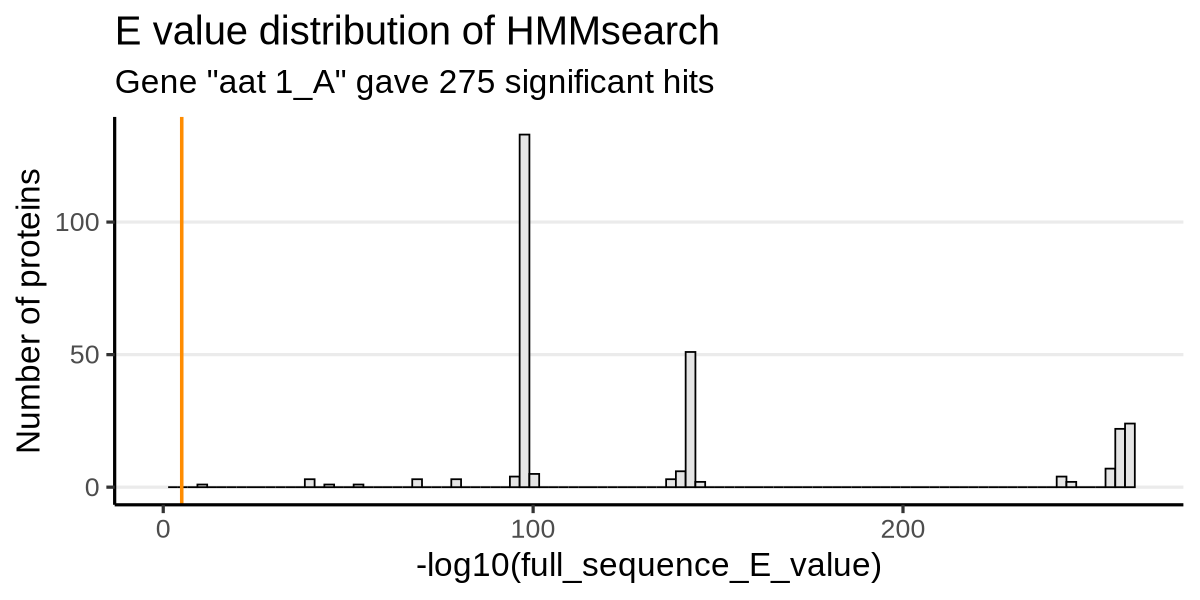

Warning message in dir.create(out_ann):
“'analysis/prediction' already exists”
Warning message in (function (..., deparse.level = 1, make.row.names = TRUE, stringsAsFactors = FALSE, :
“number of columns of result, 10, is not a multiple of vector length 4 of arg 716”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message:
“Removed 299 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 1 row con

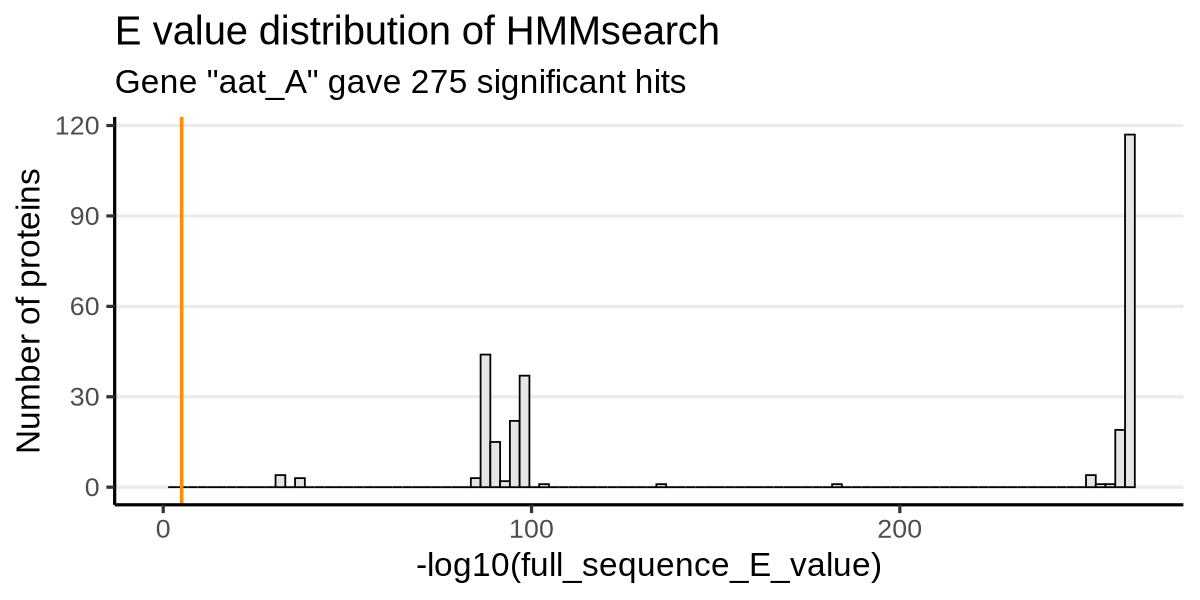

Warning message in dir.create(out_ann):
“'analysis/prediction' already exists”
Warning message in (function (..., deparse.level = 1, make.row.names = TRUE, stringsAsFactors = FALSE, :
“number of columns of result, 10, is not a multiple of vector length 4 of arg 442”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message:
“Removed 151 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 1 row con

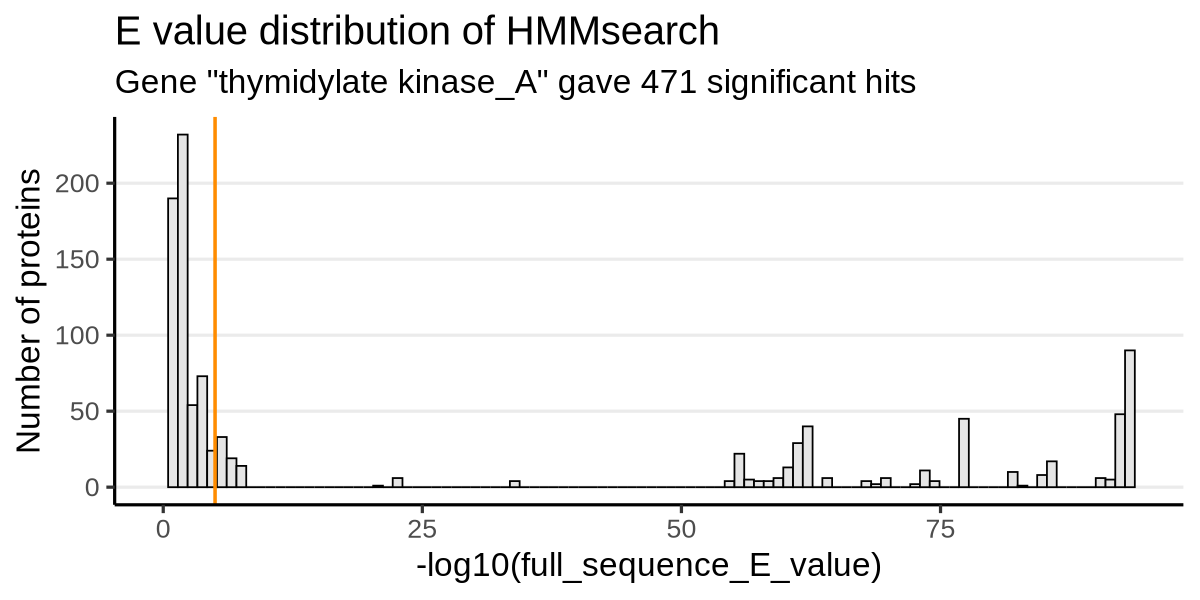

Warning message in dir.create(out_ann):
“'analysis/prediction' already exists”
Warning message in (function (..., deparse.level = 1, make.row.names = TRUE, stringsAsFactors = FALSE, :
“number of columns of result, 10, is not a multiple of vector length 4 of arg 507”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message:
“Removed 160 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 1 row con

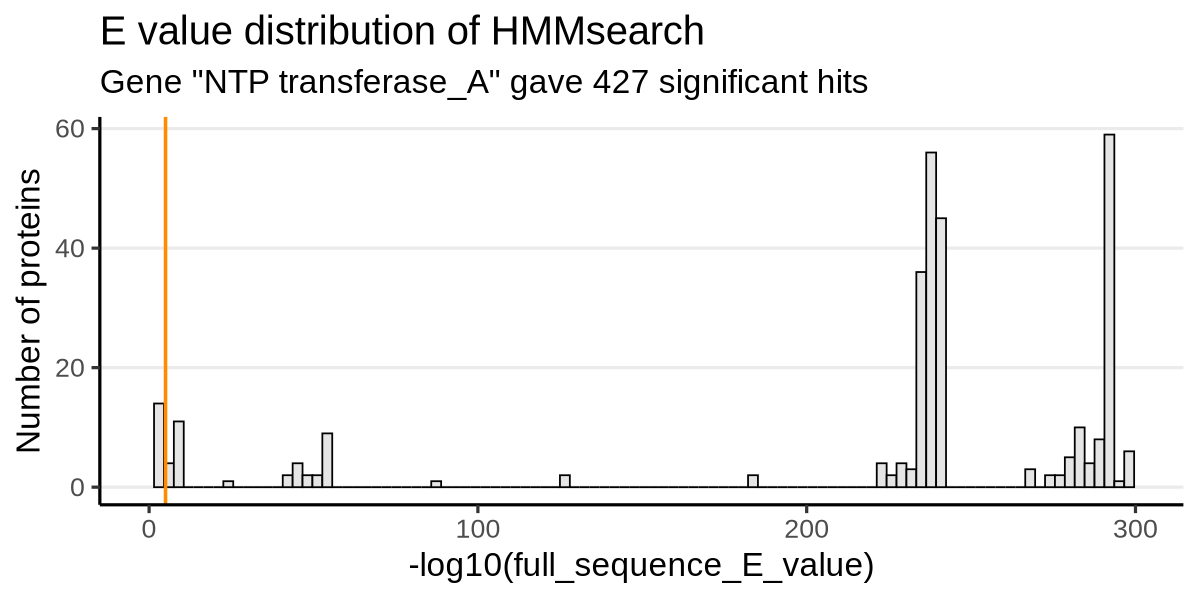

Warning message in dir.create(out_ann):
“'analysis/prediction' already exists”
Warning message in (function (..., deparse.level = 1, make.row.names = TRUE, stringsAsFactors = FALSE, :
“number of columns of result, 10, is not a multiple of vector length 4 of arg 285”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message:
“Removed 10 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 1 row cont

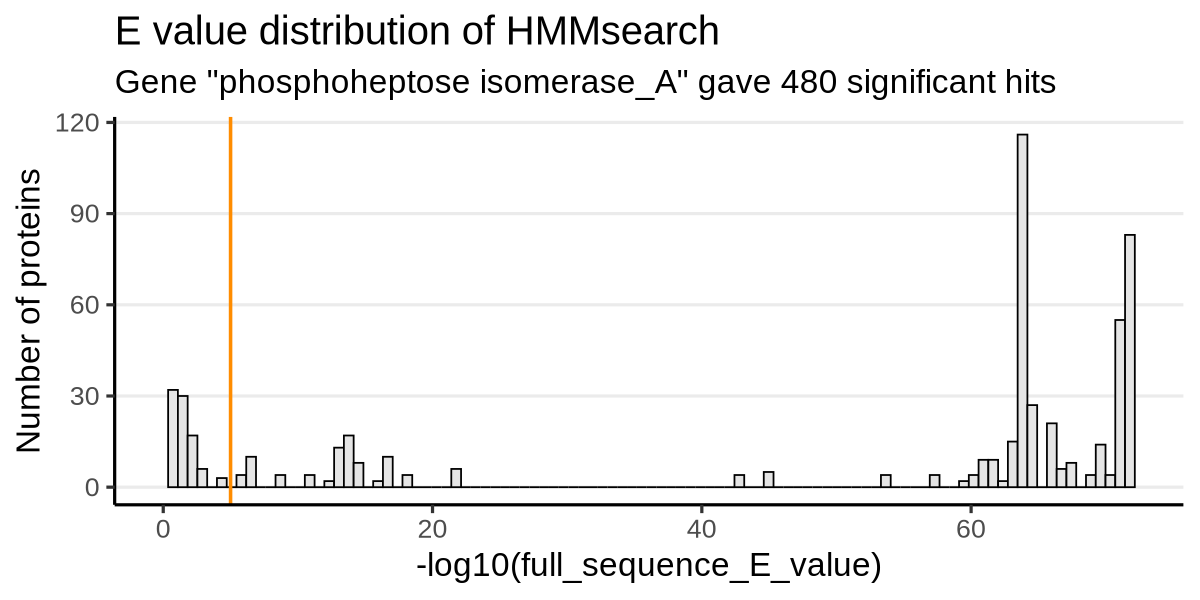

Warning message in dir.create(out_ann):
“'analysis/prediction' already exists”
Warning message in (function (..., deparse.level = 1, make.row.names = TRUE, stringsAsFactors = FALSE, :
“number of columns of result, 10, is not a multiple of vector length 4 of arg 187”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message:
“Removed 14 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 1 row cont

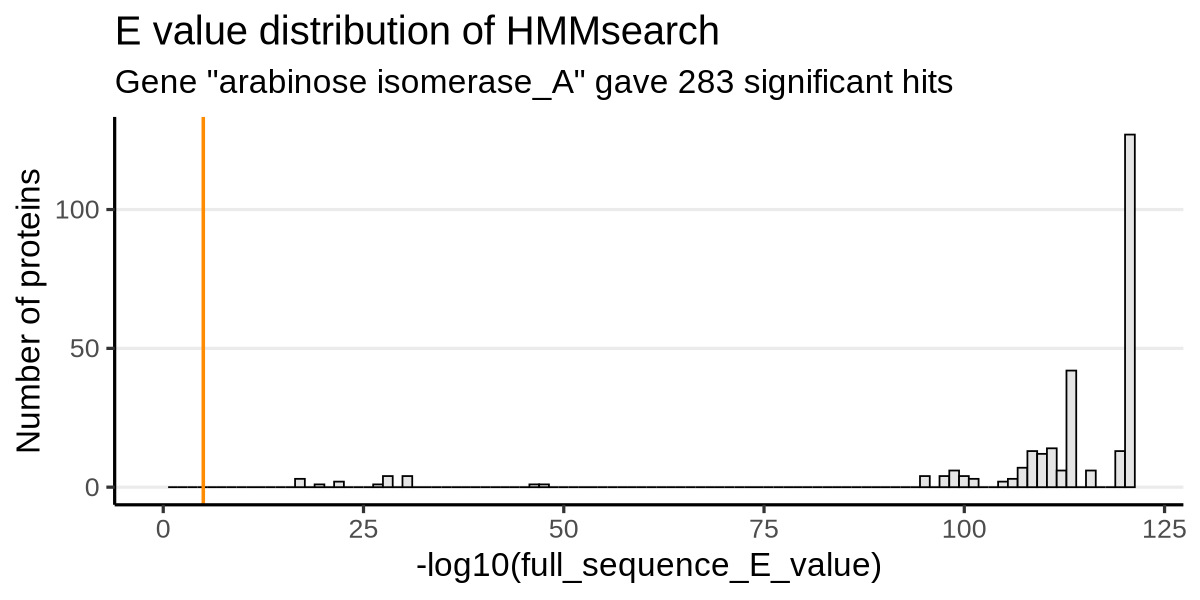

Warning message in dir.create(out_ann):
“'analysis/prediction' already exists”
Warning message in (function (..., deparse.level = 1, make.row.names = TRUE, stringsAsFactors = FALSE, :
“number of columns of result, 10, is not a multiple of vector length 4 of arg 885”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message:
“Removed 3 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 1 row conta

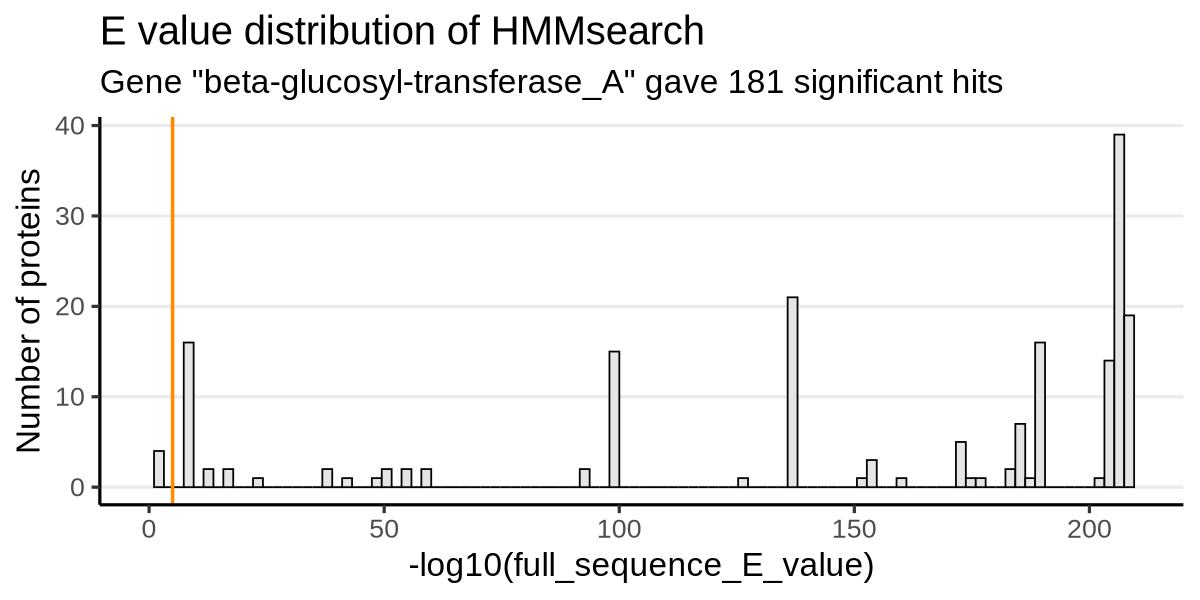

Warning message in dir.create(out_ann):
“'analysis/prediction' already exists”
Warning message in (function (..., deparse.level = 1, make.row.names = TRUE, stringsAsFactors = FALSE, :
“number of columns of result, 10, is not a multiple of vector length 4 of arg 466”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message:
“Removed 21 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 1 row cont

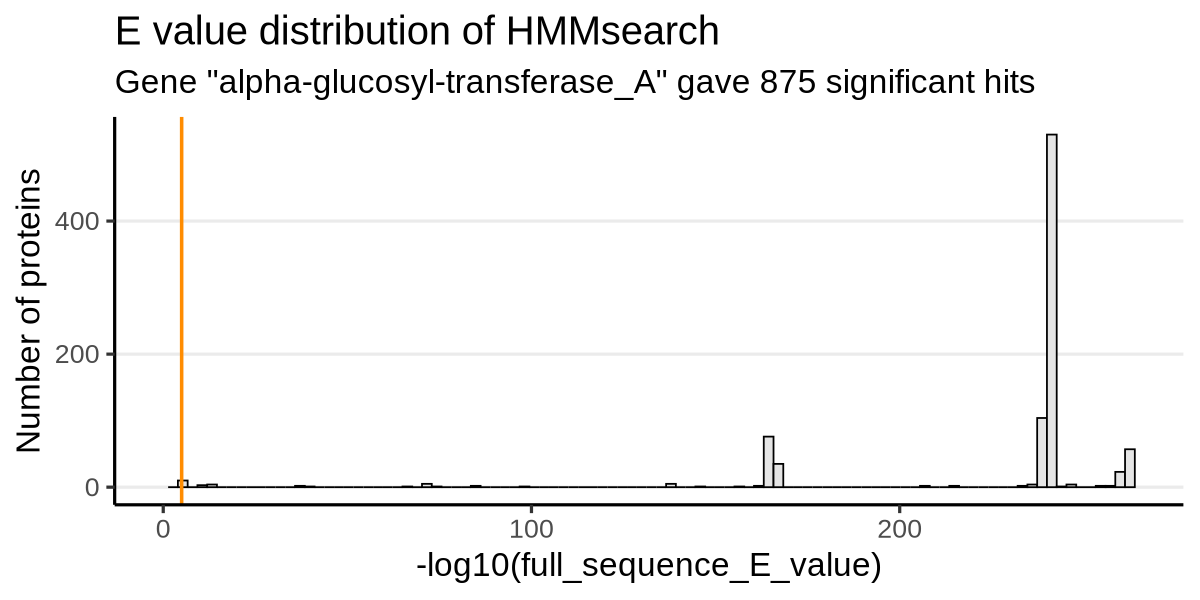

Warning message in dir.create(out_ann):
“'analysis/prediction' already exists”
Warning message in (function (..., deparse.level = 1, make.row.names = TRUE, stringsAsFactors = FALSE, :
“number of columns of result, 10, is not a multiple of vector length 4 of arg 6392”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message:
“Removed 399 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 1 row co

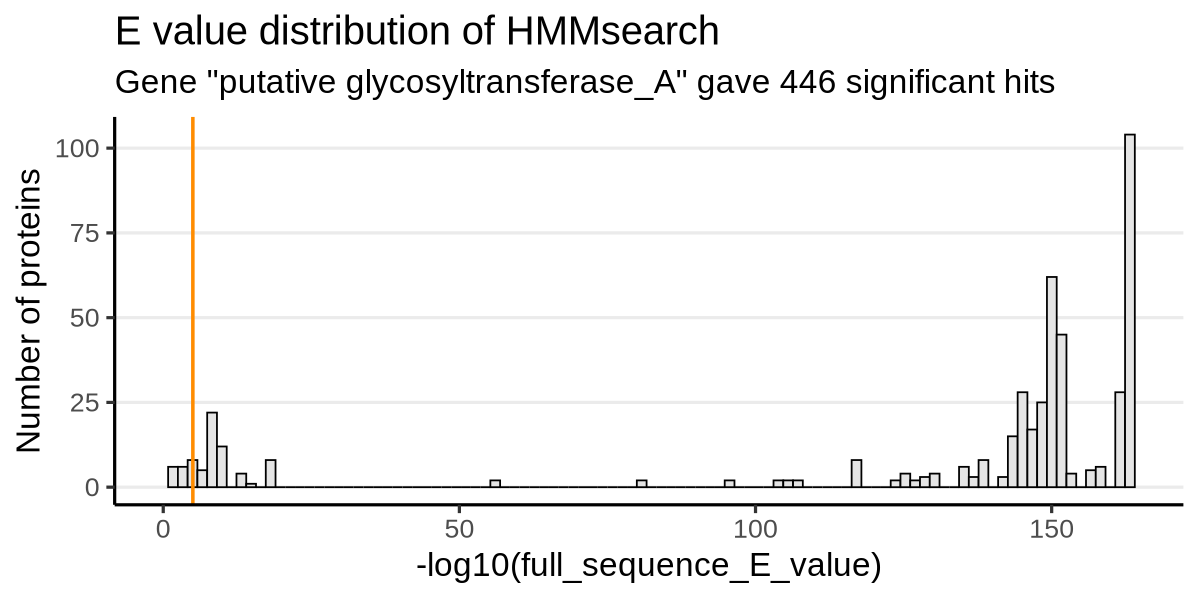

Warning message in dir.create(out_ann):
“'analysis/prediction' already exists”
Warning message in (function (..., deparse.level = 1, make.row.names = TRUE, stringsAsFactors = FALSE, :
“number of columns of result, 10, is not a multiple of vector length 4 of arg 3677”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message:
“Removed 624 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 1 row co

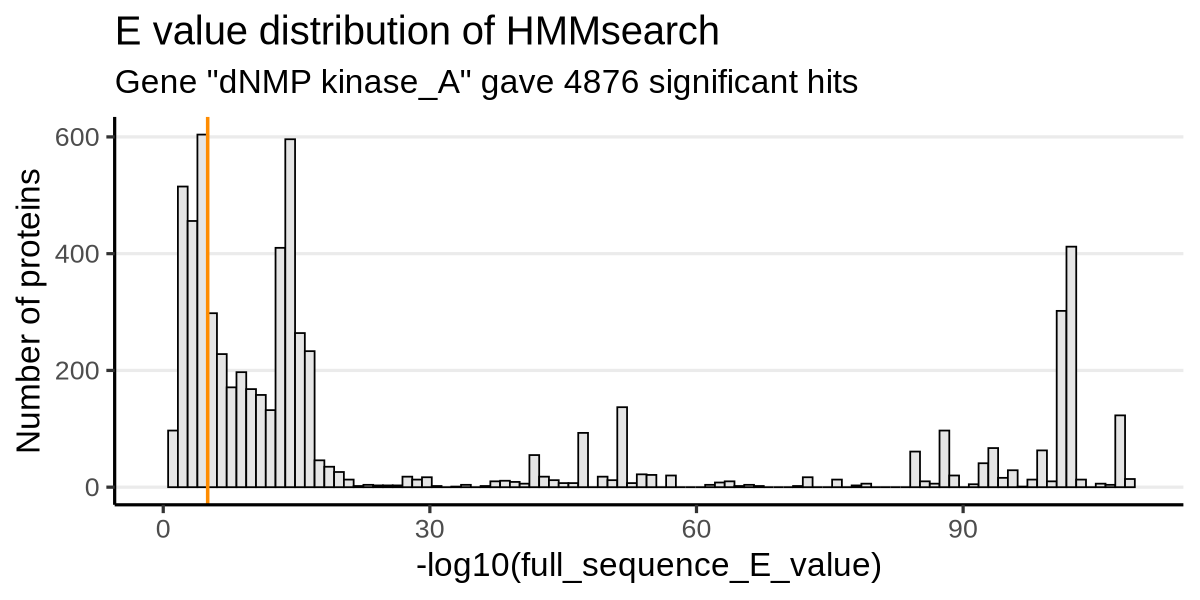

Warning message in dir.create(out_ann):
“'analysis/prediction' already exists”
Warning message in (function (..., deparse.level = 1, make.row.names = TRUE, stringsAsFactors = FALSE, :
“number of columns of result, 10, is not a multiple of vector length 4 of arg 3682”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message:
“Removed 556 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 1 row co

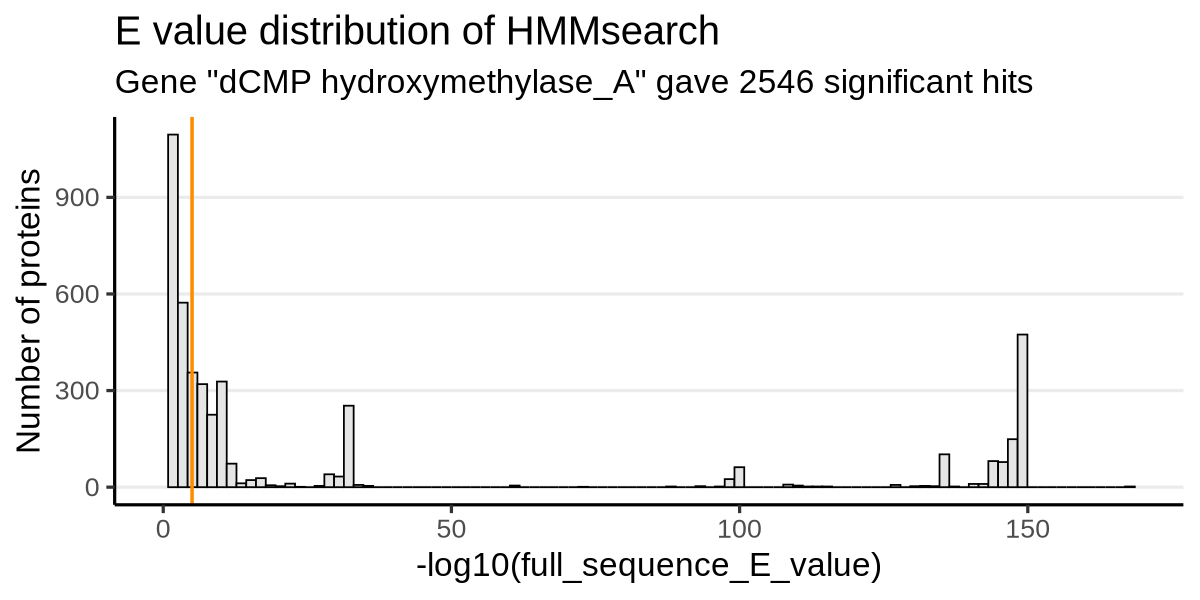

Warning message in dir.create(out_ann):
“'analysis/prediction' already exists”
Warning message in (function (..., deparse.level = 1, make.row.names = TRUE, stringsAsFactors = FALSE, :
“number of columns of result, 10, is not a multiple of vector length 4 of arg 235”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message:
“Removed 12 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 1 row cont

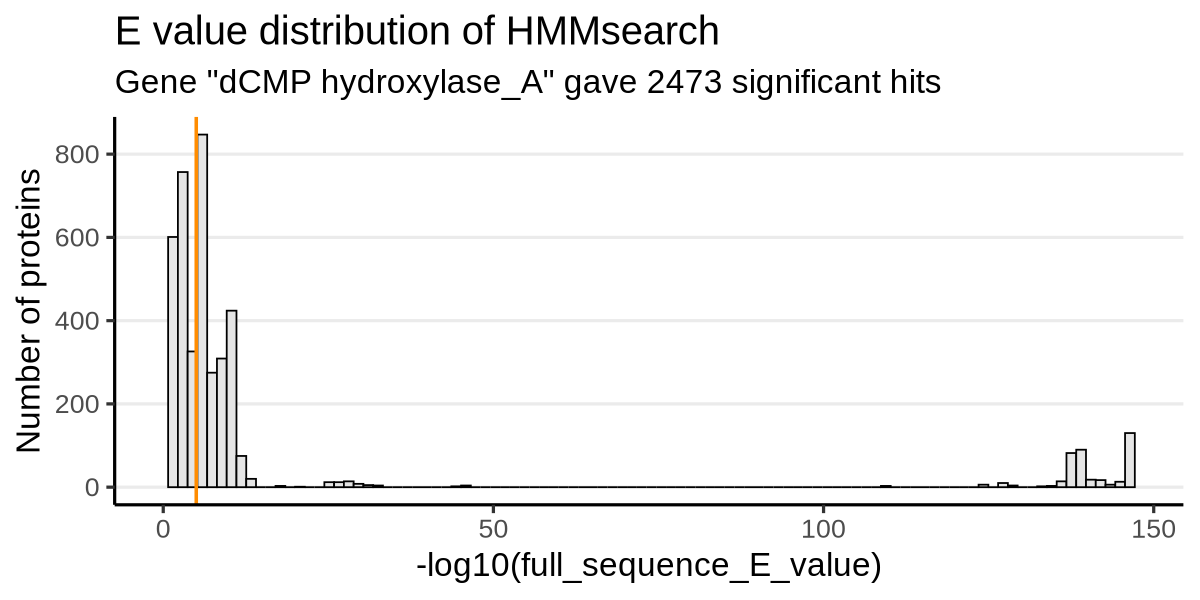

Warning message in dir.create(out_ann):
“'analysis/prediction' already exists”
Warning message in (function (..., deparse.level = 1, make.row.names = TRUE, stringsAsFactors = FALSE, :
“number of columns of result, 10, is not a multiple of vector length 4 of arg 2011”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message:
“Removed 110 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 1 row co

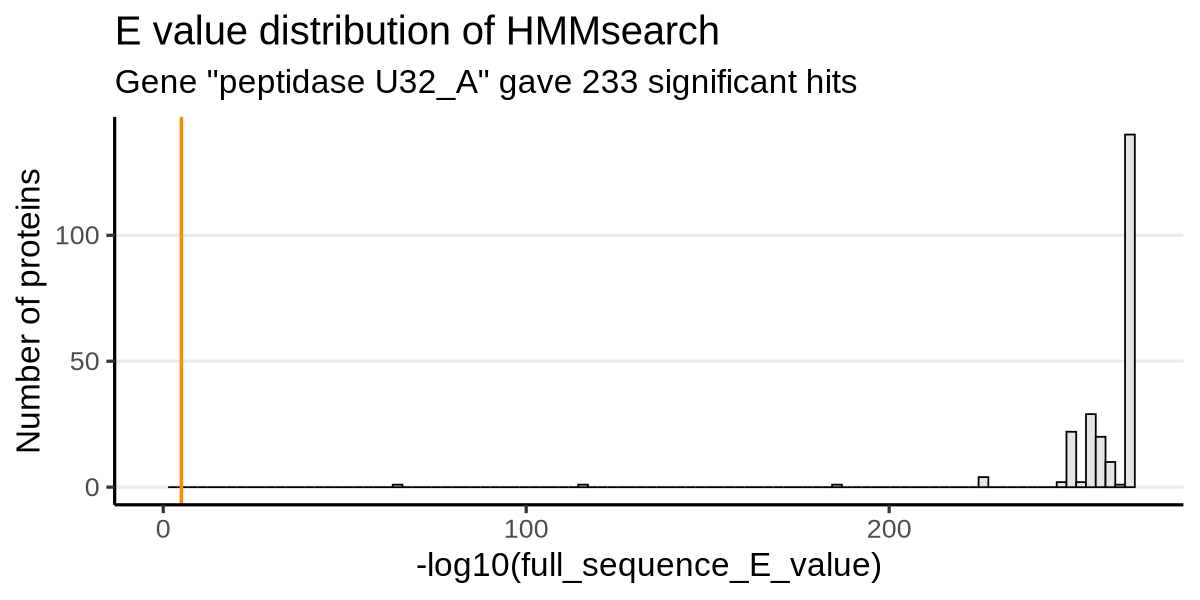

Warning message in dir.create(out_ann):
“'analysis/prediction' already exists”
Warning message in (function (..., deparse.level = 1, make.row.names = TRUE, stringsAsFactors = FALSE, :
“number of columns of result, 10, is not a multiple of vector length 4 of arg 5365”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message in read_HMMsearch(fn.result):
“NAs introduced by coercion”
Warning message:
“Removed 1702 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 1 row c

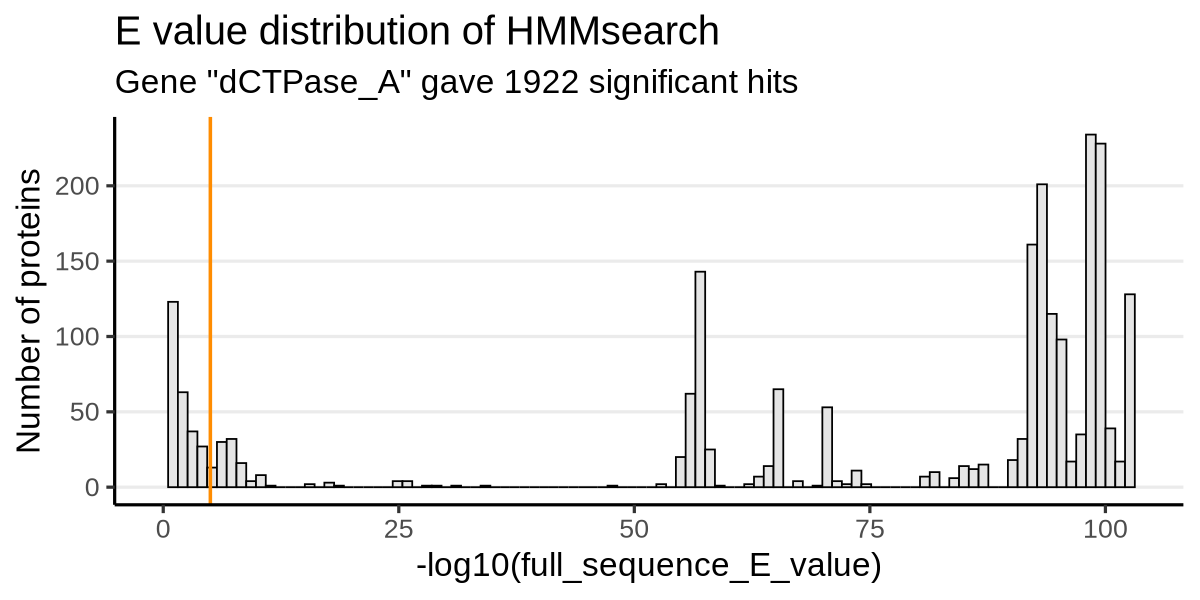

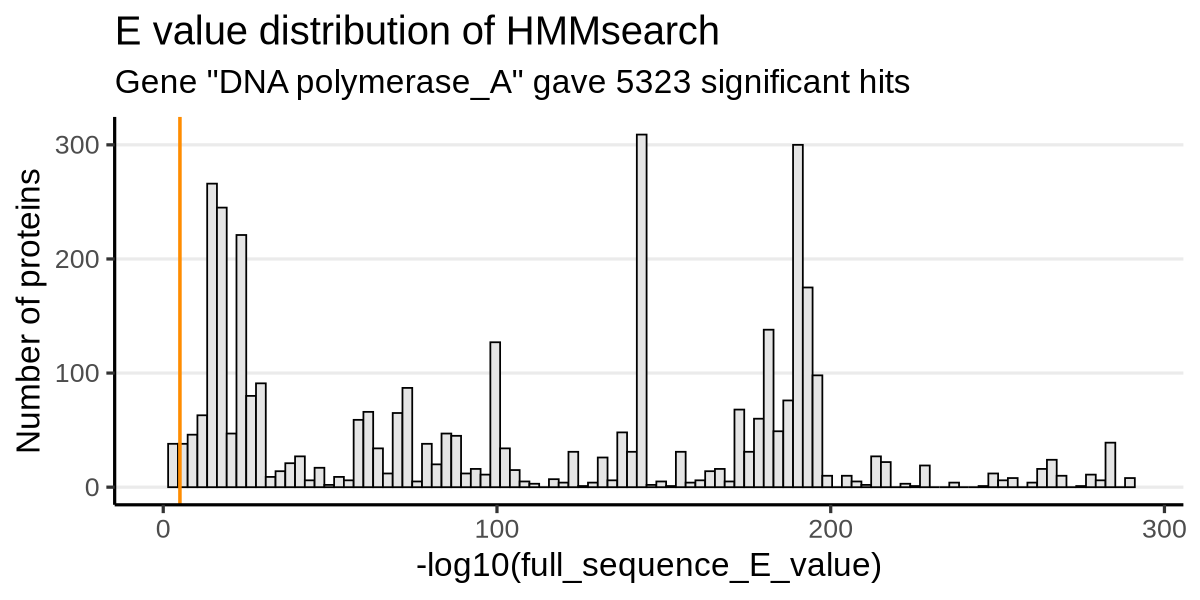

In [45]:
# Refine annotations
options(repr.plot.width=10, repr.plot.height=5)

genes <- levels(data$ann_level_2)
genes <- genes[genes != 'Other']
genes <- rev(genes)

## Check spelling
all(genes %in% levels(data$ann_level_2))

## Combine protein fasta
protein_db <- paste0(out_path,'protein.faa')
sys_call <- paste('cat ',fs$training,fs$validation$protein,fs$test$protein,fs$test2$protein,'>',protein_db)
system(sys_call, intern=TRUE)

## Iterate annotation over genes
pred <- list()
for (gene in genes) {
    pred[[gene]] <- annotate_gene_by_hmm_profile(
        data, annotation = 'ann_level_2', gene = gene, 
        search_db = protein_db, 
        e_value_treshold = 1e-5, dir = out_prediction
    )
    pred[[gene]]$annotation <- gene
}

In [46]:
## Pool
result <- do.call('rbind', pred) %>% select(Sequence, annotation, full_sequence_E_value)
result <- result[!duplicated(result), ]
result <- pivot_wider(result, names_from = Sequence, values_from = full_sequence_E_value, values_fill = 1)
result <- result %>% as.data.frame()
row.names(result) <- result$annotation
result <- result[,-1]
result[result == 0] <- 1e-300

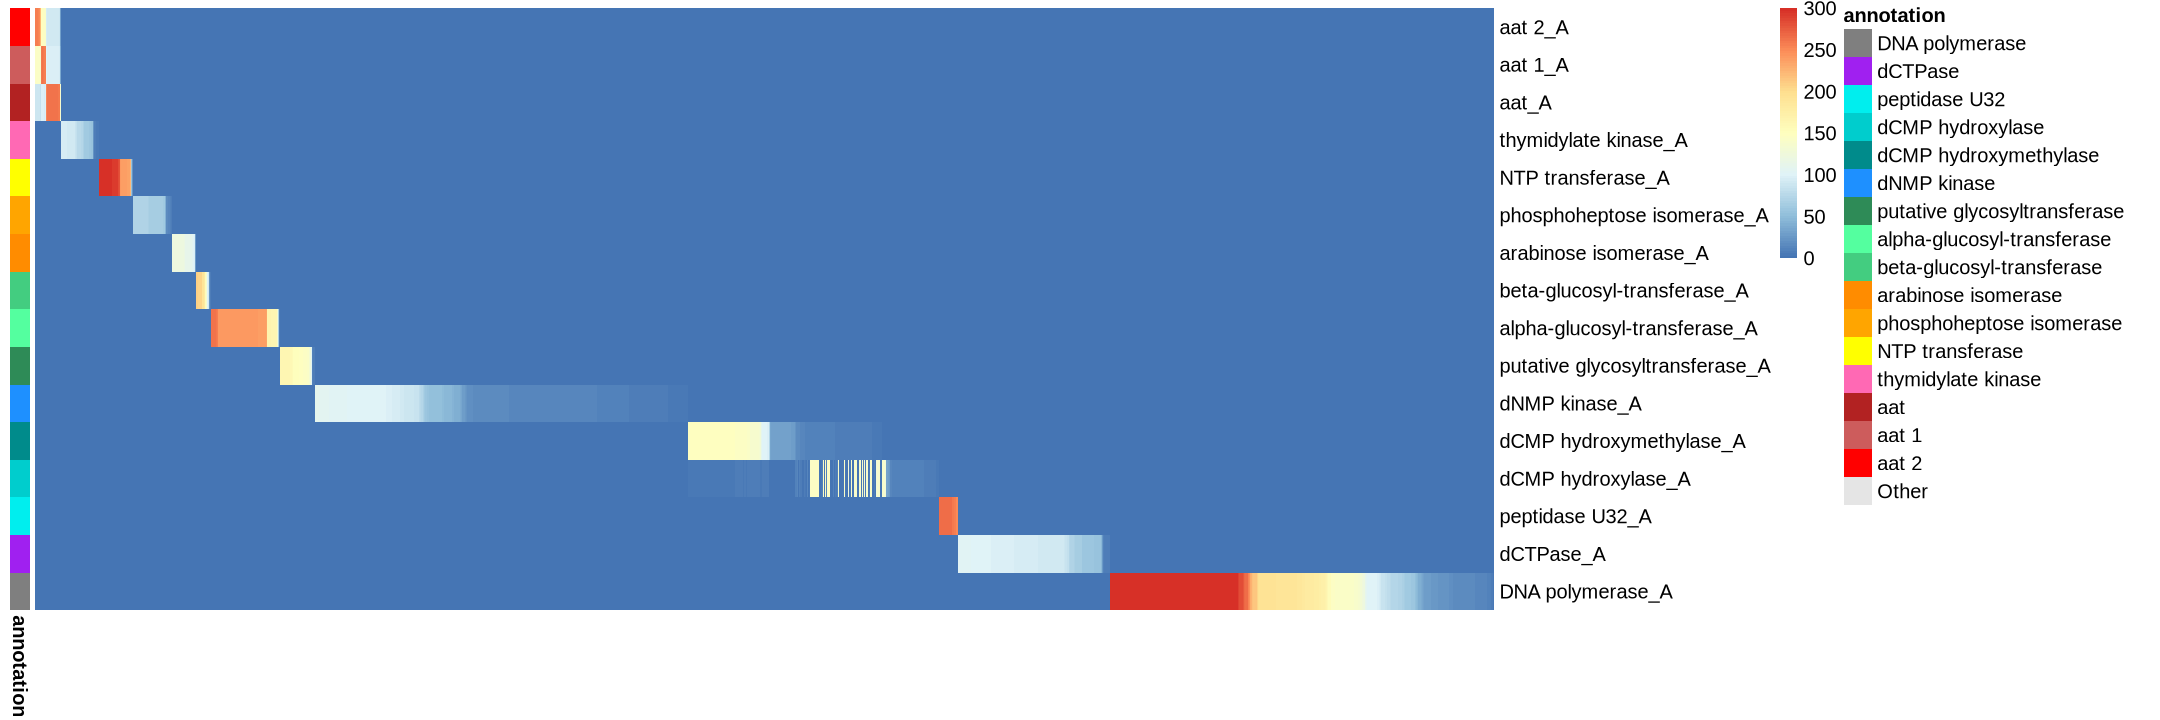

In [47]:
options(repr.plot.width=18, repr.plot.height=6)

## Row annotation
rann <- data.frame(
    row.names = rownames(result),
    annotation = str_split(rownames(result), '_', simplify=TRUE)[,1]
)

## Plot
pheatmap(
    -log10(result), 
    cluster_cols = FALSE, cluster_rows = FALSE,
    annotation_row = rann, annotation_colors = cols,
    show_colnames=FALSE,
    fontsize=12
)

In [48]:
## Vote
lookup <- character(length = ncol(result))
for (n in 1:ncol(result)) {
    v <- result[,n]
    names(v) <- str_split(rownames(result), '_', simplify = TRUE)[,1]
    n_min <- min(v)
    lookup[[n]] <- unique(names(which(v == min(v))))
}
names(lookup) <- colnames(result)
#index <- match(colnames(result), features$Gene.CDS.Protein.FASTA.Sequence.ID)
features$annotation <- lookup[features$Gene.CDS.Protein.FASTA.Sequence.ID]

`summarise()` has grouped output by 'Accession'. You can override using the
`.groups` argument.


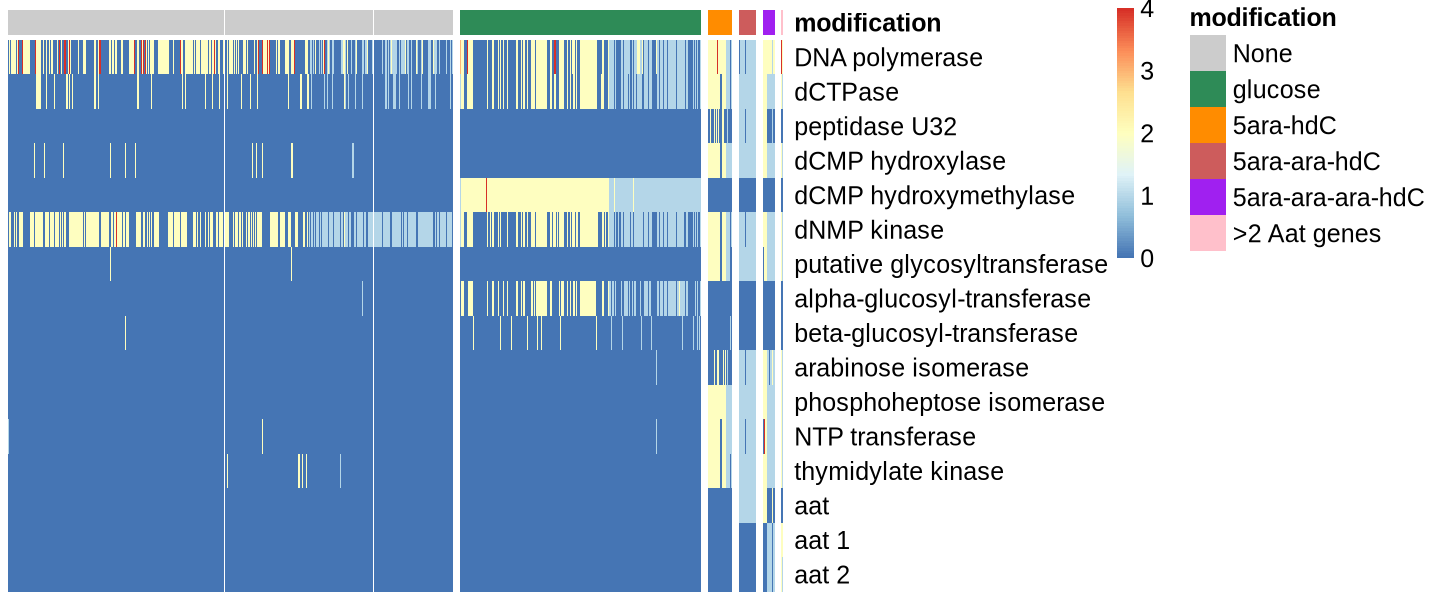

In [49]:
# Feature quantification
options(repr.plot.width=12, repr.plot.height=5)

heatmap_genes <- c('DNA pol','DNA clamp','NTP transfer','Thy syn','dCTPase','Hydroxylase','Pep U32','dNMP kinase','Glu transfer',
                   'Ara iso','pHep iso','Thy kin','Aat')
heatmap_genes <- levels(data$annotation)
heatmap_genes <- heatmap_genes[!heatmap_genes %in% c('Other')]

## Summarize gene counts
df <- features %>% mutate(N=1) %>% group_by(Accession, annotation) %>% summarize(total = sum(N))

## Filter
index <- df$annotation %in% heatmap_genes
df <- df[index,]

## Reshape
mat <- df %>% pivot_wider(names_from = Accession, values_from = total, values_fill = 0) %>% as.data.frame()
rownames(mat) <- mat$annotation
mat <- mat[heatmap_genes, -1] %>% as.matrix()

## Set max
mat[mat >= 4] <- 4

### Row
rann <- data.frame(
    row.names = rownames(mat)#, group = c('Generic','Generic','Generic','Glucosylation','Arabinosylation','Arabinosylation','Generic','Generic','Arabinosylation','Arabinosylation','Arabinosylation')
)
#rann$group <- factor(rann$group, names(cols$group))

### Col
index <- match(colnames(mat), data$Accession)
cann <- data.frame(
    row.names = colnames(mat),
    modification = data$modification[index]
)

##  Cluster

### Level 1
cann$group <- 'None'
cann$group[mat['dCMP hydroxymethylase',] > 0] <- 'Glucosylation'
cann$group[mat['phosphoheptose isomerase',] > 0] <- 'Arabinosylation'
cann$group <- factor(cann$group, names(cols$group))

### Level 2
cann$modification <- 'None'
cann$modification[cann$group == 'Glucosylation'] <- 'glucose'
cann$modification[cann$group == 'Arabinosylation' & colSums(mat[c('aat','aat 1','aat 2'),]) < 1] <- '5ara-hdC'
cann$modification[cann$group == 'Arabinosylation' & colSums(mat[c('aat','aat 1','aat 2'),]) == 1] <- '5ara-ara-hdC'
cann$modification[cann$group == 'Arabinosylation' & colSums(mat[c('aat','aat 1','aat 2'),]) == 2] <- '5ara-ara-ara-hdC'
cann$modification[cann$group == 'Arabinosylation' & colSums(mat[c('aat','aat 1','aat 2'),]) > 2] <- '>2 Aat genes'
cann$modification <- factor(cann$modification)

# Add modification to report
index_predict <- match(rownames(cann), report$Accession)

### Group
report$group <- 'None'
report$group[index_predict] <- as.character(cann$group)
report$group <- factor(report$group, rev(names(cols$group)))

### Modification
report$modification <- 'None'
report$modification[index_predict] <- as.character(cann$modification)
report$modification <- factor(report$modification, rev(names(cols$modification)))

## Order
#mat <- mat[,order(cann$group, cann$modification, decreasing = c(FALSE, TRUE), method = 'radix')]
mat <- mat[,order(cann$modification, decreasing = c(TRUE), method = 'radix')]
cann$group <- NULL

## Plot
p1 <- pheatmap(mat, 
               cluster_rows = FALSE, cluster_cols=FALSE,
               show_colnames=FALSE, annotation_colors=cols,
               annotation_col = cann,
               fontsize = 15,
               gaps_col             = head(as.numeric(cumsum(rev(table(cann$modification)[table(cann$modification) > 0])), -1)),
               #gaps_row             = head(as.numeric(cumsum(table(rann$group)[table(rann$group) > 0])), -1)
              )

In [50]:
## Quantify
dim(mat)
length(unique(features$Accession))
ncol(mat) / length(unique(features$Accession))
table(report$group)
table(report$modification)
levels(data$annotation)

[1]   16 2780

[1] 18891

[1] 0.14716


Arabinosylation   Glucosylation         Generic            None 
            205             907               0           17779 


    >2 Aat genes 5ara-ara-ara-hdC     5ara-ara-hdC         5ara-hdC 
               5               44               66               90 
         glucose             None 
             907            17779 

[1] "DNA polymerase"               "dCTPase"                     
 [3] "peptidase U32"                "dCMP hydroxylase"            
 [5] "dCMP hydroxymethylase"        "dNMP kinase"                 
 [7] "putative glycosyltransferase" "alpha-glucosyl-transferase"  
 [9] "beta-glucosyl-transferase"    "arabinose isomerase"         
[11] "phosphoheptose isomerase"     "NTP transferase"             
[13] "thymidylate kinase"           "aat"                         
[15] "aat 1"                        "aat 2"                       
[17] "Other"

In [51]:
205/2780 * 100
205/18891 * 100

[1] 7.374101

[1] 1.085173

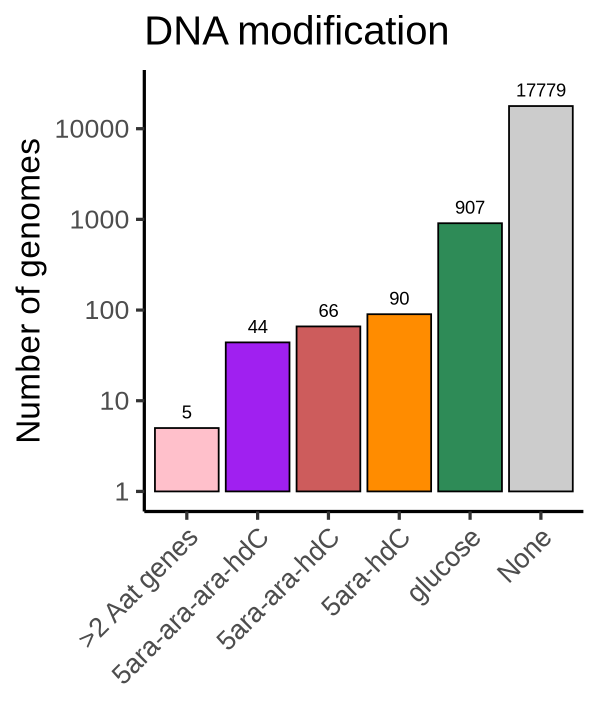

In [52]:
# Visualize groups
options(repr.plot.width=5, repr.plot.height=6)

## Fetch
df <- as.data.frame(table(report$modification))
names(df) <- c('group','freq')

## Order
df <- df[order(df$freq, decreasing = TRUE), ]
#df$group <- factor(df$group, unique(df$group))

## Plot
p2 <- ggplot(df, aes(group, freq, fill=group, label=freq)) +
  geom_col(position = 'stack', col='black') +
  geom_text(aes(y = freq*1.5)) +
  scale_fill_manual(values = cols$modification) +
  scale_y_continuous(trans='log10') +
  theme_classic(20) +
  theme(
      axis.text.x = element_text(angle=45,hjust=1,vjust=1)
  ) +
  guides(
      fill = guide_none()
  ) +
  labs(title='DNA modification',y='Number of genomes',x=NULL,fill='Group')
p2

'data.frame':	18891 obs. of  61 variables:



Arabinosylation   Glucosylation         Generic            None 
            205             907               0           17779 


    >2 Aat genes 5ara-ara-ara-hdC     5ara-ara-hdC         5ara-hdC 
               5               44               66               90 
         glucose             None 
             907            17779 

`summarise()` has grouped output by 'set', 'genus_cleaned', 'modification'. You
can override using the `.groups` argument.


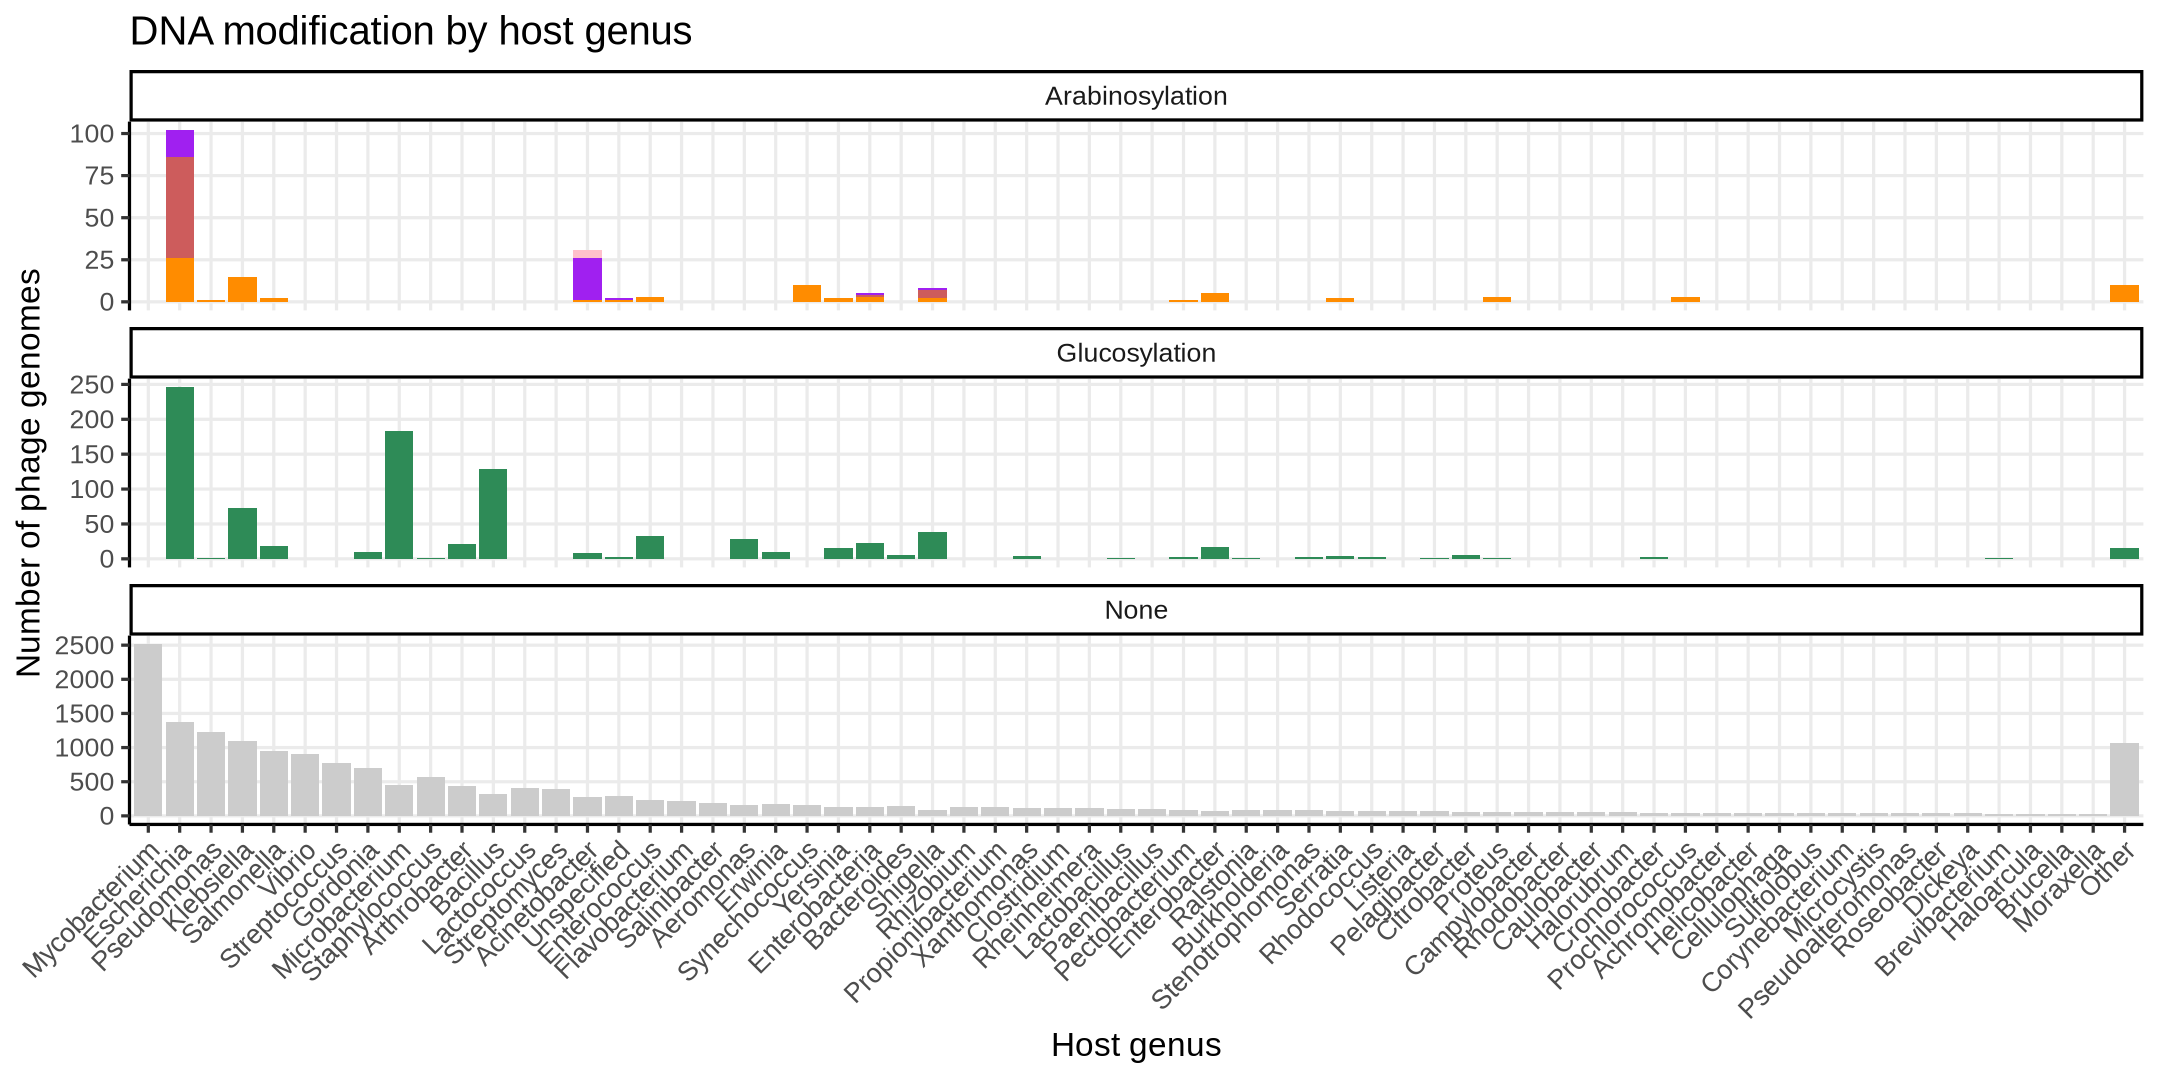

In [53]:
# Representativeness of data sets
options(repr.plot.width=18, repr.plot.height=9)

## Select
df <- report
df$N <- 1

## Quantify
str(df, max.level = 0)
table(df$group)
table(df$modification)

## Summarize
df <- df %>% group_by(set, genus_cleaned, modification, group) %>% summarize(total = sum(N))

## Create facets
df$facet <- NA
df$facet[df$set %in% c('training')] <- 'in study'
df$facet[df$set %in% c('test','test2','validation')] <- 'NCBI databases'

## Plot
ggplot(df, aes(genus_cleaned, total, fill=modification)) +
  geom_col() +
  facet_wrap(~group, nrow = 8, scales = 'free_y') +
  scale_fill_manual(values = cols$modification) +
  theme_classic(20) +
  theme(
      axis.text.x = element_text(angle=45,hjust=1,vjust=1),
      panel.grid.major.y = element_line(),
      panel.grid.major.x = element_line()
  ) +
  guides(
      fill = guide_none()
  ) +
  labs(title='DNA modification by host genus', x = 'Host genus', y='Number of phage genomes')

`summarise()` has grouped output by 'set', 'genus_cleaned', 'modification'. You
can override using the `.groups` argument.


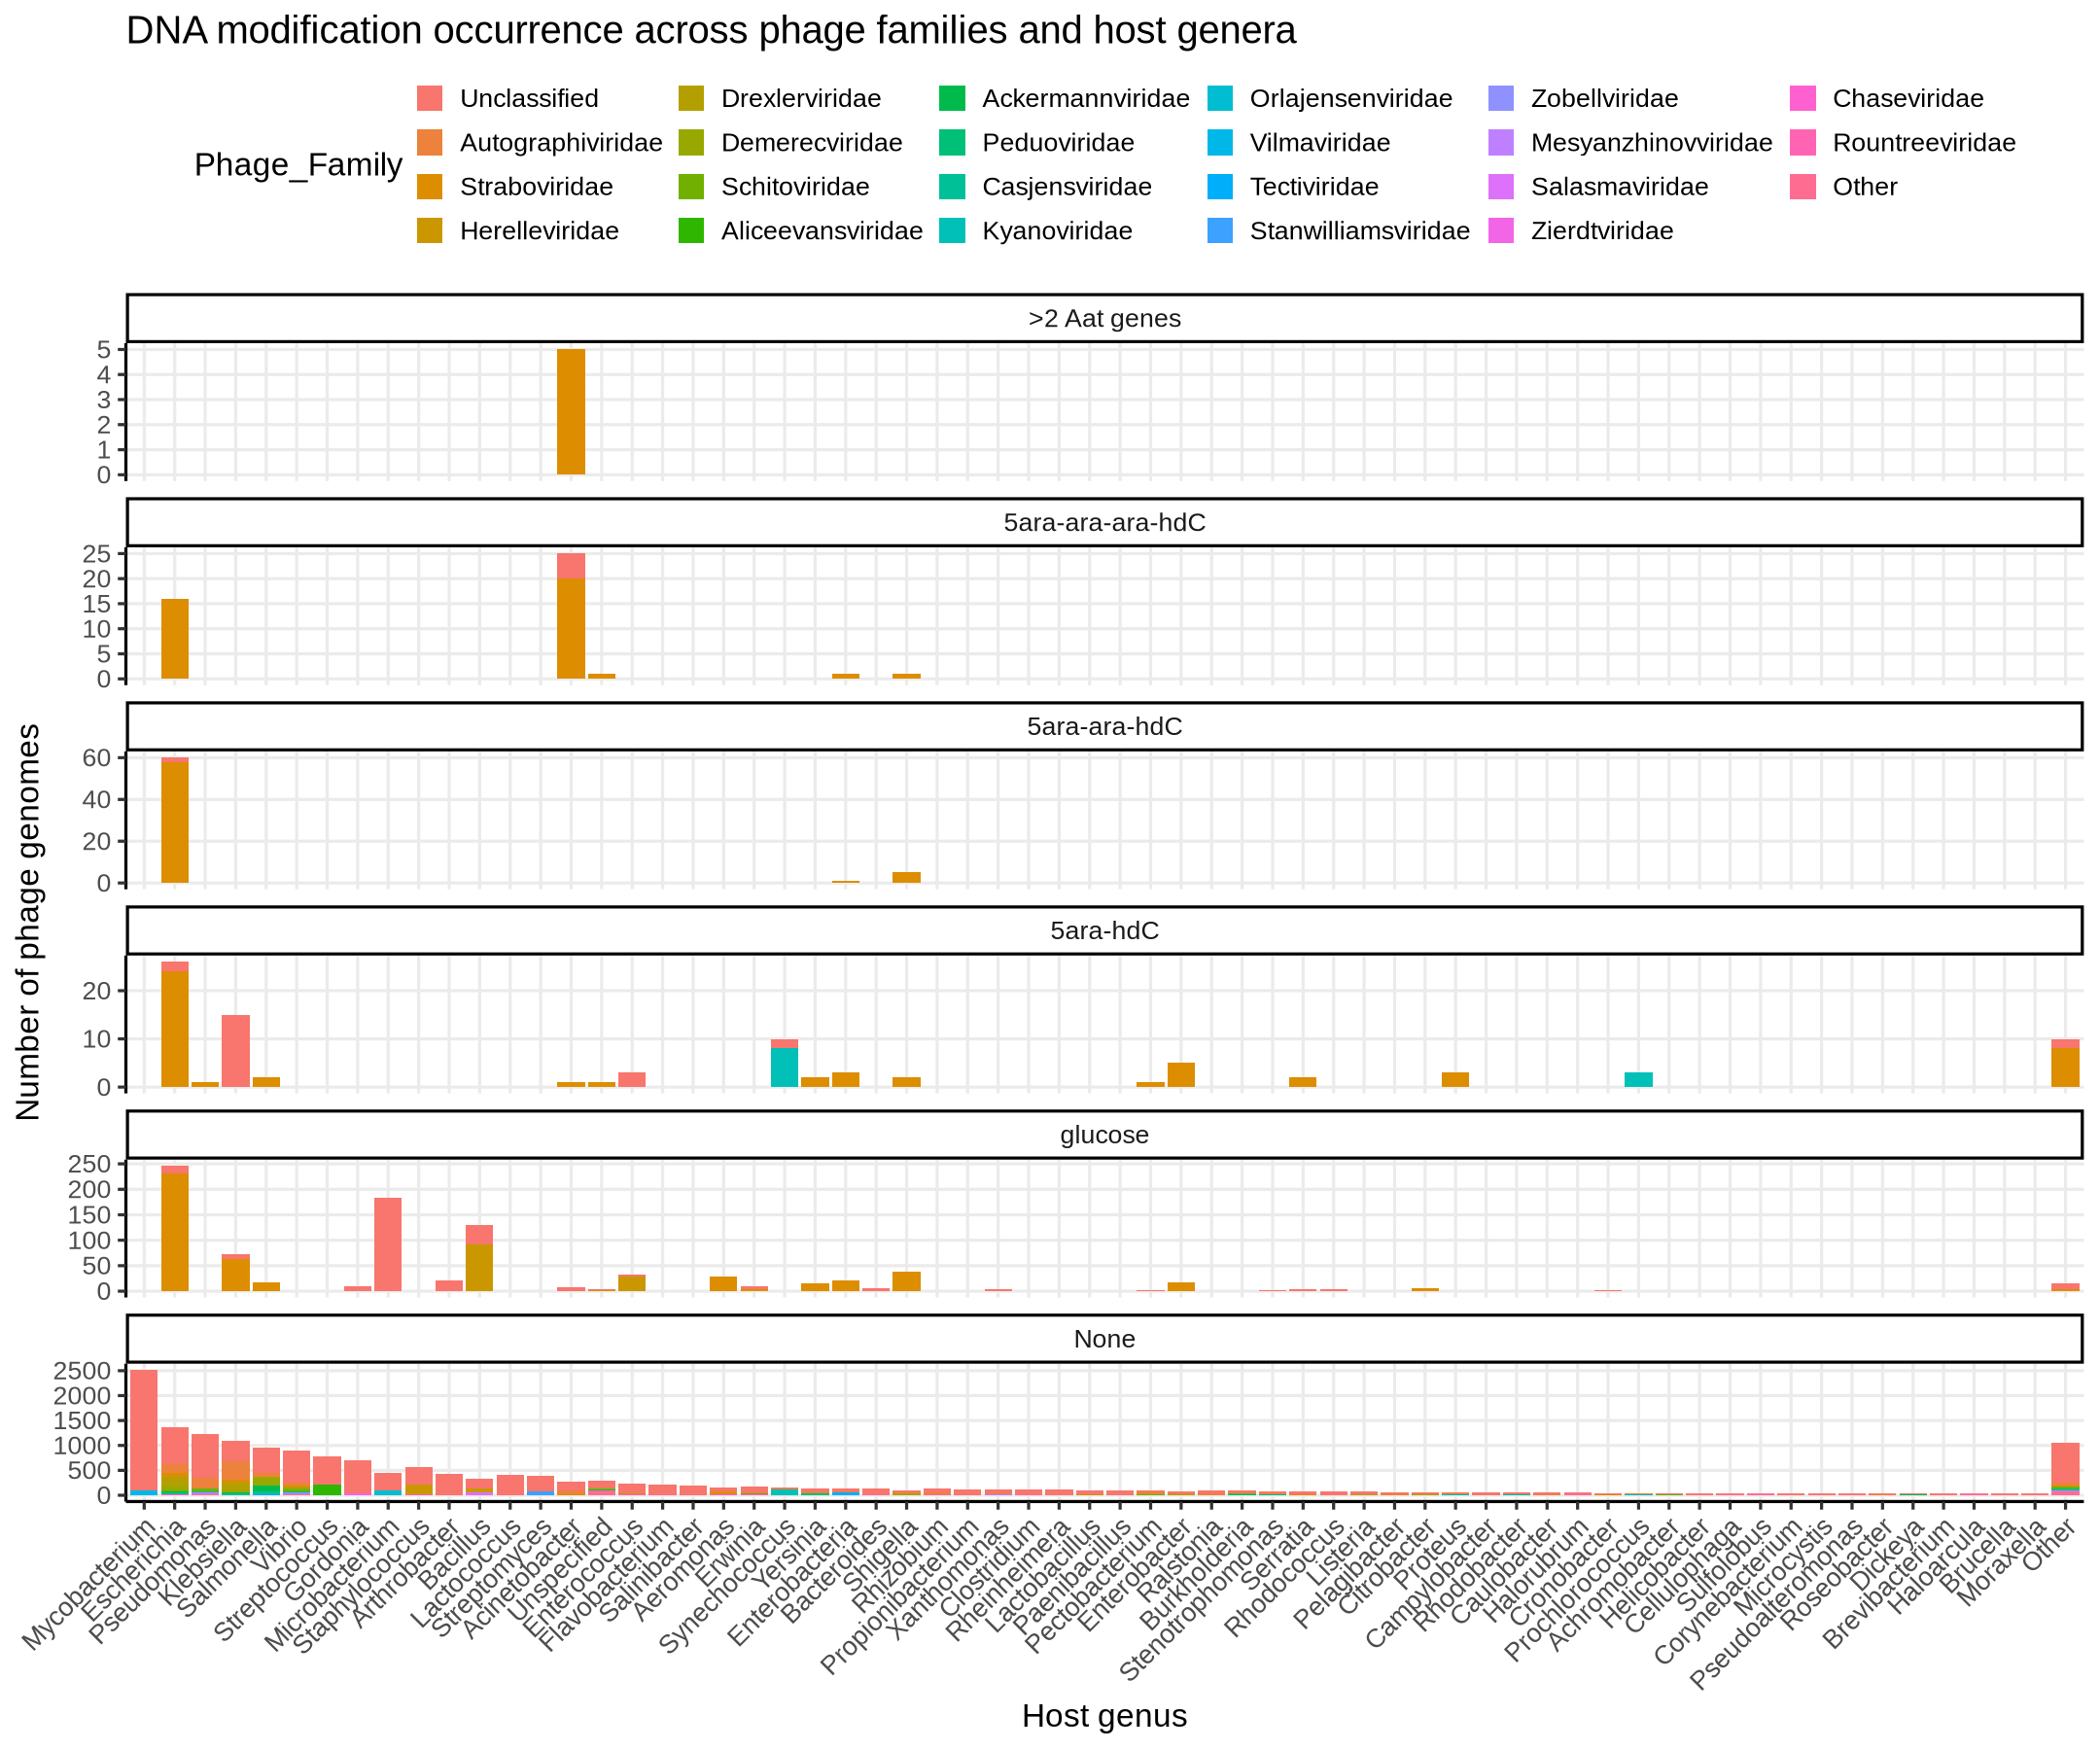

In [54]:
# Representativeness of data sets
options(repr.plot.width=18, repr.plot.height=15)

## Select
df <- report
df$N <- 1

## Summarize
df <- df %>% group_by(set, genus_cleaned, modification, Phage_Family) %>% summarize(total = sum(N))

## Create facets
df$facet <- NA
df$facet[df$set %in% c('training')] <- 'in study'
df$facet[df$set %in% c('test','test2','validation')] <- 'NCBI databases'

## Plot
ggplot(df, aes(genus_cleaned, total, fill=Phage_Family)) +
  geom_col() +
  facet_wrap(~modification, nrow = 8, scales = 'free_y') +
  #scale_fill_manual(values = cols$modification) +
  theme_classic(20) +
  theme(
      axis.text.x = element_text(angle=45,hjust=1,vjust=1),
      panel.grid.major.y = element_line(),
      panel.grid.major.x = element_line()
  ) +
  guides(
      fill = guide_legend(position='top', nrow = 4)
  ) +
  labs(title='DNA modification occurrence across phage families and host genera', x = 'Host genus', y='Number of phage genomes')

`summarise()` has grouped output by 'modification'. You can override using the
`.groups` argument.


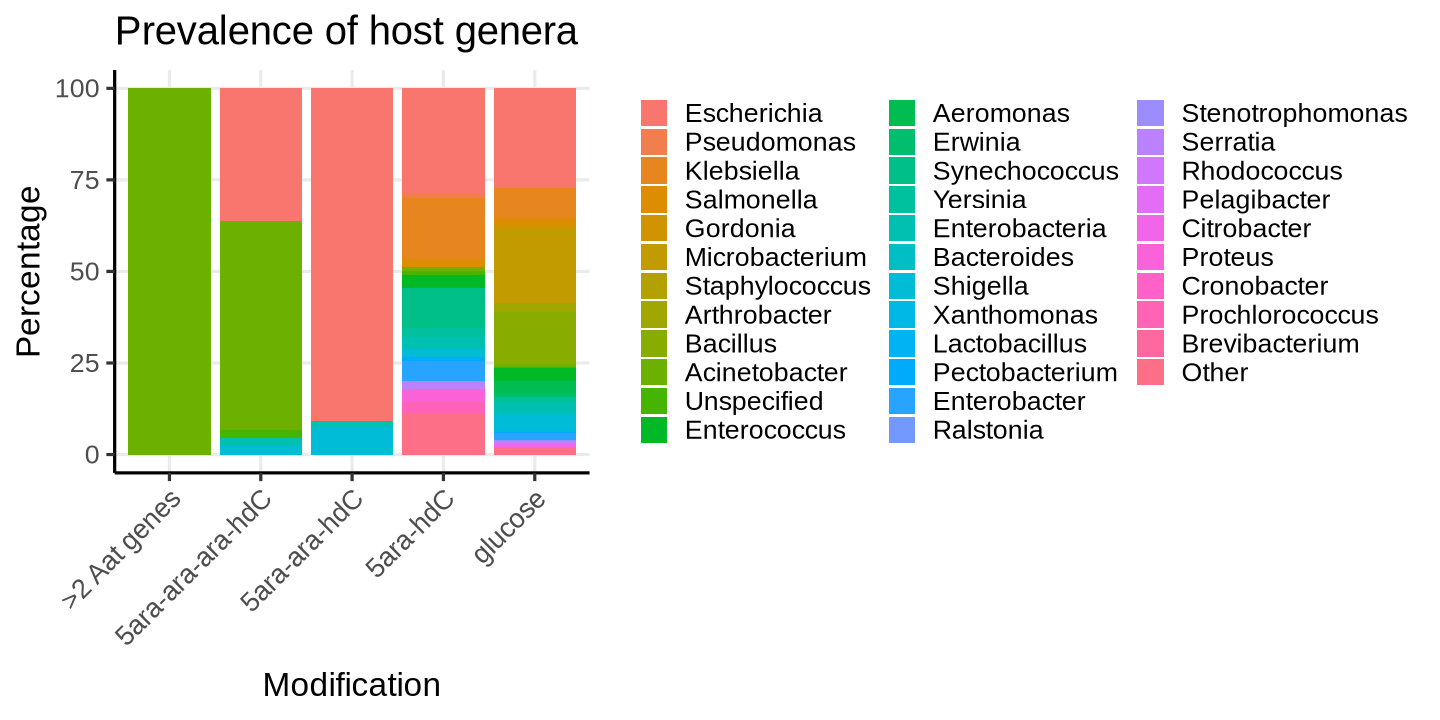

In [55]:
# Quantify host genus across modifications
options(repr.plot.width=12, repr.plot.height=6)

## Format data
df <- report %>% mutate(N=1) %>% group_by(modification, genus_cleaned) %>% summarize(count=sum(N))
df <- df %>% group_by(modification) %>% mutate(total=sum(count), perc=count/total*100)

## Subset
index <- which(df$modification != 'None')
df <- df[index,]

## Plot
ggplot(df, aes(modification, perc, fill=genus_cleaned)) +
  geom_col() +
  theme_classic(20) +
  theme(
      axis.text.x = element_text(angle=45,hjust=1,vjust=1),
      panel.grid.major.y = element_line(),
      panel.grid.major.x = element_line()
  ) +
  guides(
      fill = guide_legend(position='right', ncol = 3)
  ) +
  labs(title='Prevalence of host genera', x = 'Modification', y='Percentage', fill=NULL)

`summarise()` has grouped output by 'modification'. You can override using the
`.groups` argument.


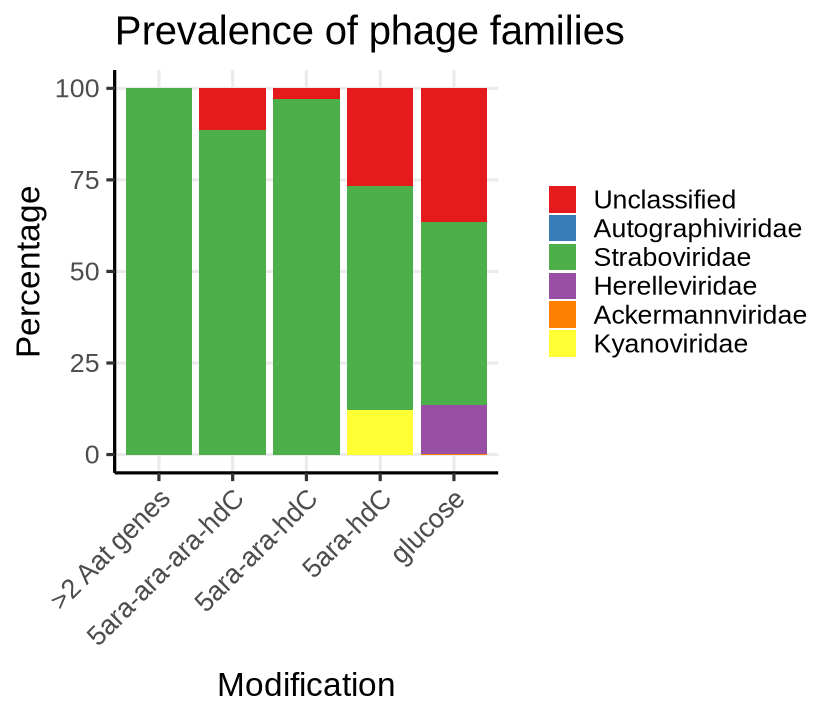

In [56]:
# Quantify host genus across modifications
options(repr.plot.width=7, repr.plot.height=6)

## Format data
df <- report %>% mutate(N=1) %>% group_by(modification, Phage_Family) %>% summarize(count=sum(N))
df <- df %>% group_by(modification) %>% mutate(total=sum(count), perc=count/total*100)

## Subset
index <- which(df$modification != 'None')
df <- df[index,]

## Plot
ggplot(df, aes(modification, perc, fill=Phage_Family)) +
  geom_col() +
  theme_classic(20) +
  scale_fill_brewer(palette = 'Set1', direction = 1) +
  theme(
      axis.text.x = element_text(angle=45,hjust=1,vjust=1),
      panel.grid.major.y = element_line(),
      panel.grid.major.x = element_line()
  ) +
  guides(
      fill = guide_legend(position='right')
  ) +
  labs(title='Prevalence of phage families', x = 'Modification', y='Percentage', fill=NULL)

In [57]:
dim(report)
dim(features)
table(features$annotation)

[1] 18891    60

[1] 3420814      76


                         aat                        aat 1 
                         103                           36 
                       aat 2   alpha-glucosyl-transferase 
                          35                          642 
         arabinose isomerase    beta-glucosyl-transferase 
                         175                          123 
            dCMP hydroxylase        dCMP hydroxymethylase 
                         373                         1478 
                     dCTPase               DNA polymerase 
                        1362                         2711 
                 dNMP kinase              NTP transferase 
                        2859                          274 
               peptidase U32     phosphoheptose isomerase 
                         159                          294 
putative glycosyltransferase           thymidylate kinase 
                         283                          303 

In [58]:
sessionInfo()

R version 4.4.2 (2024-10-31)
Platform: x86_64-conda-linux-gnu
Running under: Ubuntu 22.04.4 LTS

Matrix products: default
BLAS/LAPACK: /home/dieol22p/miniconda3/envs/arabinosylation-anti-crispr/lib/libopenblasp-r0.3.28.so;  LAPACK version 3.12.0

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

time zone: Etc/UTC
tzcode source: system (glibc)

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] pheatmap_1.0.12     ape_5.8-1           msa_1.38.0         
 [4] Biostrings_2.74.0   GenomeInfoDb_1.42.0 XVector_0.46.0     
 [7] IRanges_2.40.0      S4Vectors_0.44.0    BiocGenerics_0.52.0
[10] ggtree_3.14.0       gggenes_0.5.1       cowplot_1.1.3      
